# Prepare data for training
To-do:
- preload images
- separate images into train and test set (maybe 90:10)

In [2]:
import tensorflow as tf

import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

from sklearn.utils import class_weight

import sys
sys.path.append(r"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Code/Brain_Mets_Classification")

import brain_mets_classification.custom_funcs as funcs

from tqdm import tqdm

import shutil

import imageio
import cv2

### Imfusion Lables Preparation

export .txt file and convert segmentation masks to unsigned char for ImFusion Label annotations

In [9]:
# move only the fully preprocessed files into new patient folders
path_to_auto_segmented_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/segmented_AURORA_n4_20240614-170748")
path_to_all_preprocessed_files = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")
path_to_unsigned_segmentations = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations")

path_to_txt_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/files_to_segment.txt"

In [12]:
# create txt file that lists all the paths to the preprocessed t1c images and after that separated by a semi-colon the path to the multilabel segmentation

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    t1c_file = [file for file in os.listdir(str(path_to_perc_normalized)) if "t1c" in file][0]
    path_to_t1c_file = path_to_perc_normalized / t1c_file

    path_to_segmentation = path_to_auto_segmented_files / patient
    if not path_to_segmentation.exists():
        print(f"directory {path_to_segmentation} does not exist")
        continue

    multimodal_segmentation_file = [file for file in os.listdir(str(path_to_segmentation)) if "multi-modal" in file][0]
    path_to_multimodal_segmentation_file = path_to_segmentation / multimodal_segmentation_file

    mask = nib.load(path_to_multimodal_segmentation_file)
    data = mask.get_fdata()

    # Convert to unsigned bytes
    data_uint8 = data.astype(np.uint8)

    # Create a new Nifti1Image
    new_img = nib.Nifti1Image(data_uint8, affine = mask.affine)

    new_img.header.set_data_dtype(np.uint8)
    new_img.header['datatype'] = 2  # 2 corresponds to unsigned char in NIfTI format
    new_img.header['bitpix'] = 8  # 8 bits per voxel

    path_to_unsinged_mask = path_to_unsigned_segmentations / multimodal_segmentation_file

    nib.save(new_img, path_to_unsinged_mask)

    f = open(path_to_txt_file, "a")
    f.write(f"{path_to_t1c_file};{path_to_unsinged_mask}\n")
    f.close()

100%|██████████| 492/492 [00:13<00:00, 35.90it/s]


In [13]:
output_file = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/unsigned_segmentations/sub-01009590_multi-modal_segmentation.nii.gz"

img = nib.load(output_file)
print(img.get_data_dtype())  # This should print uint8

uint8


prints patients that have been removed from the training

In [16]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

training_patients = pd.read_csv(path_to_tsv, sep="\t")

patient_ids = training_patients["participant_id"].tolist()
print(patient_ids)

preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in preprocessed_patients:
    if patient not in patient_ids:
        print(patient)

['sub-01005097', 'sub-01005630', 'sub-01006290', 'sub-01009590', 'sub-01015961', 'sub-01018613', 'sub-01021714', 'sub-01021993', 'sub-01022787', 'sub-01025630', 'sub-01031243', 'sub-01038520', 'sub-01040149', 'sub-01041137', 'sub-01055292', 'sub-01056598', 'sub-01056884', 'sub-01064662', 'sub-01071055', 'sub-01072344', 'sub-01083248', 'sub-01087386', 'sub-01098043', 'sub-01099901', 'sub-01104996', 'sub-01106844', 'sub-01108350', 'sub-01109318', 'sub-01111974', 'sub-01117914', 'sub-01117958', 'sub-01119720', 'sub-01122863', 'sub-01125016', 'sub-01130173', 'sub-01130856', 'sub-01131702', 'sub-01134825', 'sub-01138456', 'sub-01147272', 'sub-01150136', 'sub-01152379', 'sub-01164049', 'sub-01164986', 'sub-01169240', 'sub-01188297', 'sub-01189050', 'sub-01190670', 'sub-01190738', 'sub-01196057', 'sub-01199093', 'sub-01201117', 'sub-01201482', 'sub-01204563', 'sub-01205171', 'sub-01205745', 'sub-01207036', 'sub-01213140', 'sub-01214172', 'sub-01214417', 'sub-01216717', 'sub-01220269', 'sub-01

In [ ]:
import nibabel as nib
import numpy as np

# Load the .nii file
img = nib.load('path_to_your_label.nii')
data = img.get_fdata()

# Convert to unsigned bytes
data_uint8 = data.astype(np.uint8)

# Create a new Nifti1Image
new_img = nib.Nifti1Image(data_uint8, img.affine, img.header)

# Save the new .nii file
nib.save(new_img, 'path_to_your_label_uint8.nii')

In [4]:
# copy preprocessed files into new patient folders
preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

for patient in tqdm(preprocessed_patients):

    # go into perc_normalized dir
    # create new patient dir in path_to_only_preprocessed
    # copy contents
    
    path_to_perc_normalized = path_to_all_preprocessed_files / patient / "perc_normalized"

    path_to_new_patient_folder = path_to_only_preprocessed / patient
    os.mkdir(path_to_new_patient_folder)

    files_to_copy = [file for file in os.listdir(str(path_to_perc_normalized)) if not file.endswith(".nii.gz")]

    for file in files_to_copy:
        shutil.copy(path_to_perc_normalized / file, path_to_new_patient_folder)

## Regensburg

### Clean up data

CAVE: remove patient sub-01383503 from training as the cerebellum is not fully displayed

In [3]:
# set pandas random seed to 42
np.random.seed(42)

In [4]:
#path_to_patients_tsv = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/rawdata/participants.tsv")
#path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv")
path_to_patients_tsv = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/participants_04_09_24.tsv")

# old: path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
# path_to_preprocessed_images = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/preprocessed_brainlesion_allpatients")
#path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")
path_to_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/preprocessed_n4_brainlesion_percentile_20240612-083743")

Read .tsv file with all the patients

In [5]:
training_patients = pd.read_csv(path_to_patients_tsv, sep="\t", index_col=False)

# drop patient sub-01383503
patient_to_drop_index = training_patients.index[training_patients["participant_id"] == "sub-01383503"]
training_patients.drop(index=patient_to_drop_index, inplace=True)
training_patients.reset_index(drop=True, inplace=True)
#training_patients = training_patients.sample(frac=1) #shuffles the dataset

print(f"Before removing unfit files: {len(training_patients)}")
patient_files_list = os.listdir(path_to_preprocessed_images)
for index, row in training_patients.iterrows():
    if training_patients["participant_id"][index] not in patient_files_list:
        training_patients.drop(index=index, inplace=True)

print(f"After removing unfit files: {len(training_patients)}")
training_patients.reset_index(drop=True, inplace=True)

# shuffle dataset
training_patients = training_patients.sample(frac=1).reset_index(drop=True)

patient_ids = training_patients["participant_id"].tolist()

Before removing unfit files: 472
After removing unfit files: 470


### Unify primary classes

In [ ]:
#copy of cancer_primaries_dict from config.py (22_07_2024)

# cancer_primaries_dict = {   '1a': 'small cell lung cancer',
#                             '1b': 'squamous cell lung cancer',
#                             '1c': 'adenocarcinoma of the lung',
#                             '1d': 'large cell lung cancer',
#                             '1e': 'NSCLC',
#                             '1f': 'lung cancer, other',
#                             '1g': 'lung cancer, exact histology unknown',
#                             '2': 'breast cancer',
#                             '3': 'prostate cancer',
#                             '4': 'testicular cancer',
#                             '5': 'renal cell carcinoma',
#                             '6': 'transitional cell carcinoma', # also called urothelial carcinoma
#                             '7': 'vulvar carcinoma',
#                             '8': 'cervical cancer',
#                             '9': 'endometrial cancer',
#                             '10': 'ovarian cell carcinoma',
#                             '11a': 'osteosarcoma',
#                             '11b': 'liposarcoma',
#                             '11c': 'leiomyosarcoma',
#                             '11d': 'rhabdomyosarcoma',
#                             '11e': 'synovial sarcoma',
#                             '11f': 'solitary fibrous tumor',
#                             '11g': 'sarcoma, other',
#                             '11h': 'sarcoma, exact histology unknown',
#                             '12': 'melanoma',
#                             '13': 'lacrimal gland carcinoma',
#                             '14': 'salivary gland cancer',
#                             '15': 'oral squamous cell carcinoma',
#                             '16': 'adenoid cystic carcinoma',
#                             '17': 'laryngeal cancer',
#                             '18': 'thyroid cancer',
#                             '19': 'esophageal cancer',
#                             '20': 'gastric cancer',
#                             '21': 'pancreatic cancer',
#                             '22': 'cholangiocellular carcinoma',
#                             '23': 'colorectal cancer',
#                             '24': 'NET', # = neuroendocrine tumors
#                             '25': 'MiNEN', # = mixed neuroendocrine non-neuroendocine neuroplasms
#                             '26a': 'DSRCT', # = Desmoplastic small-round-cell Tumor
#                             '26b': 'mesothelioma, other',
#                             '27': 'thymoma',
#                             '28': 'plasmacytoma',
#                             '29': 'cancer of unknown primary'
# }

In [6]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()

print("Original Primaries Dict:")
print(primaries_array_dict)
print()

def compress_primaries_dict(primaries_dict):

    #primaries_dict_copy = primaries_dict.copy()

    for key, value in primaries_dict.items():
        clean_primary = ''.join(filter(str.isdigit, value))
        primaries_dict[key] = clean_primary
    
    print(primaries_dict)

    for key, value in primaries_dict.items():
        primary_num = int(value)

        renamed_primary = 0

        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num

        primaries_dict[key] = renamed_primary
    
    print(primaries_dict)
    return primaries_dict


def return_specific_primaries_dict(primaries_dict, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    
                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101

                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 12:
                            primaries_dict[key] = 102
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 103
                case 4: # genito urinary

                    for key, value in primaries_dict.items():
                        if value == 3:
                            primaries_dict[key] = 104
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 19:
                            primaries_dict[key] = 105
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 101
                    #primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma

                    for key, value in primaries_dict.items():
                        if value == 4:
                            primaries_dict[key] = 102
                    #primaries_array = primaries_array.replace(4, 102)
                case 3: # breast

                    for key, value in primaries_dict.items():
                        if value == 1:
                            primaries_dict[key] = 103
                    #primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    
                    for key, value in primaries_dict.items():
                        if value == 6:
                            primaries_dict[key] = 104
                    #primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro

                    for key, value in primaries_dict.items():
                        if value == 2:
                            primaries_dict[key] = 105
                    #primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    print(primaries_dict)

    for key, value in primaries_dict.items():
        if value < 100:
            primaries_dict[key] = 0

    print(primaries_dict)

    counter = 0

    for specific_class in specific_classes:
        specific_class = specific_class + 100
        counter += 1

        for key, value in primaries_dict.items():
            if value == specific_class:
                primaries_dict[key] = counter
    
    print(primaries_dict)

    return primaries_dict

print("Compress Primaries Dict Function output:")
compressed = compress_primaries_dict(primaries_array_dict)
print()

print("Return Specific Primaries Dict Function output:")
specific_primaries_dict = return_specific_primaries_dict(compressed, [1,2,3,4,5], "Regensburg")

print(pd.Series(specific_primaries_dict.values()).value_counts())

Original Primaries Dict:
{'sub-01205745': '12', 'sub-01288350': '23', 'sub-01125016': '11b', 'sub-02184584': '1c', 'sub-02146286': '1a', 'sub-01710250': '1c', 'sub-01686968': '1f', 'sub-01025630': '1a', 'sub-02055312': '1c', 'sub-01281168': '12', 'sub-01314225': '1b', 'sub-02178883': '1c', 'sub-02127770': '2', 'sub-02154718': '1c', 'sub-80011453': '2', 'sub-02139997': '1e', 'sub-01515235': '12', 'sub-01381621': '8', 'sub-02148372': '10', 'sub-01311383': '1c', 'sub-01005097': '1e', 'sub-93003757': '5', 'sub-01038520': '1a', 'sub-01771120': '1a', 'sub-01309950': '23', 'sub-01677324': '12', 'sub-02174928': '2', 'sub-01307298': '1a', 'sub-01117958': '1f', 'sub-01587295': '6', 'sub-01421533': '1c', 'sub-01732889': '1c', 'sub-01398968': '1a', 'sub-02124336': '1a', 'sub-01071055': '5', 'sub-01147272': '1a', 'sub-02095181': '15', 'sub-93002557': '23', 'sub-01947074': '23', 'sub-01484016': '12', 'sub-01895825': '12', 'sub-01773716': '1e', 'sub-01505384': '12', 'sub-01565091': '23', 'sub-0201573

In [7]:
# primaries are written like this: 1e, 25, 13, 2f, etc., for the full list see config.py
# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
primaries_array_dict = pd.Series(training_patients.primary.values, index=training_patients.participant_id).to_dict()
primaries_array = training_patients["primary"]

#print(primaries_array)

#print(primaries_array.value_counts())




def compress_primaries(primaries_array):
    '''moves all the primaries from different subclasses into one class, e.g. 1a-f become 1 etc.'''
    
    letters_removed_primaries = []

    # remove any letters from the list
    for primary in primaries_array:
        clean_primary = ''.join(filter(str.isdigit, primary))
        letters_removed_primaries.append(clean_primary)

    compressed_primaries = []

    for primary in letters_removed_primaries:
        primary_num = int(primary)
        renamed_primary = 0
        # compress all the genitourinary cancers togehter (3-10)
        if primary_num >= 3 and primary_num <= 10:
            renamed_primary = 3
        # compress all the gastrointestinal cancers together (19-25)
        elif primary_num >= 19 and primary_num <= 25:
            renamed_primary = 19
        # compress all the head and neck cancers together (13-18)
        elif primary_num >= 13 and primary_num <= 18:
            renamed_primary = 13
        else:
            renamed_primary = primary_num
        
        compressed_primaries.append(renamed_primary)
        
    return compressed_primaries

compressed_list = pd.Series(compress_primaries(primaries_array))
#print(compressed_list.value_counts())

def return_specific_primaries(primaries_array, specific_classes, dataset):
    """
    Replace items in the primaries_array that are not in the specified classes with "other".
    
    Args:
    primaries_array (array): Array of primary classes.
    specific_classes (array): Array of specific classes to include.
    dataset (str): Name of the dataset ("Regensburg" or "Yale").
    
    Returns:
    array: Updated primaries_array with classes replaced as specified.
    """

    # go through the list and replace each iteam that is not in the specified classes with "other"

    if dataset == "Regensburg":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(1, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(12, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(2, 103)
                case 4: # genito urinary
                    primaries_array = primaries_array.replace(3, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(19, 105)
                case _:
                    pass
    
    elif dataset == "Yale":

        for specific_class in specific_classes:

            match specific_class:
                case 1: # lung
                    primaries_array = primaries_array.replace(0, 101)
                case 2: # melanoma
                    primaries_array = primaries_array.replace(4, 102)
                case 3: # breast
                    primaries_array = primaries_array.replace(1, 103)
                case 4: # genito urinary, actually in this case only renal cell carcinoma
                    primaries_array = primaries_array.replace(6, 104)
                case 5: # gastro
                    primaries_array = primaries_array.replace(2, 105)
                case _:
                    pass

    for primary in primaries_array:
            if primary < 100:
                primaries_array = primaries_array.replace(primary, 0)
    
    counter = 0

    for specific_class in specific_classes:
        
        specific_class = specific_class + 100

        counter += 1

        primaries_array = primaries_array.replace(specific_class, counter)

    #print(primaries_array.value_counts())

    return primaries_array

def return_modified_primaries(primaries_array, num_classes):
    '''returns an array where all the items are grouped into x classes depending on num_classes
    e.g. if num_classes = 2, then only the most frequent category (lung cancer) gets returned while all the other categories are grouped as \'other\''''
    
    # get most frequent classes
    # go through the list and replace each item that is not in the most frequent classes with "other"
    # the following code is probably one the least efficient ways to solve this problem
    # but it works so who am I to change it
    different_primaries = []

    for primary in primaries_array:
        if primary not in different_primaries:
            different_primaries.append(primary)
    
    count_dict = {}

    #print(different_primaries)

    for dif_primary in different_primaries:
        count = list(primaries_array).count(dif_primary)
        count_dict[count] = dif_primary
    
    sorted_dict = sorted(count_dict, reverse=True)

    white_list_count = []

    for n in range(num_classes - 1):
        white_list_count.append(sorted_dict[n])

    white_list = []
    for n in white_list_count:
        white_list.append(count_dict[n])

    modified_array = []

    for primary in primaries_array:
        modified_primary = 0

        if primary not in white_list:
            modified_primary = 0
        else:
            modified_primary = primary
        
        modified_array.append(modified_primary)
    
    return modified_array

test_class_primaries = return_specific_primaries(compressed_list, specific_classes = [1,2,3,4,5], dataset="Regensburg")
#print(test_class_primaries)
print(test_class_primaries.value_counts())
# two_classes_primaries = pd.Series(return_modified_primaries(compressed_list, num_classes=2))

# print(two_classes_primaries)
# print(two_classes_primaries.value_counts())

# # create dict of patient IDs to primaries
patient_primaries_dict = dict(zip(patient_ids, test_class_primaries))
print(patient_primaries_dict)

1    255
2     74
4     42
3     39
5     32
0     28
Name: count, dtype: int64
{'sub-01205745': 2, 'sub-01288350': 5, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 1, 'sub-01686968': 1, 'sub-01025630': 1, 'sub-02055312': 1, 'sub-01281168': 2, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 3, 'sub-02154718': 1, 'sub-80011453': 3, 'sub-02139997': 1, 'sub-01515235': 2, 'sub-01381621': 4, 'sub-02148372': 4, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 4, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 5, 'sub-01677324': 2, 'sub-02174928': 3, 'sub-01307298': 1, 'sub-01117958': 1, 'sub-01587295': 4, 'sub-01421533': 1, 'sub-01732889': 1, 'sub-01398968': 1, 'sub-02124336': 1, 'sub-01071055': 4, 'sub-01147272': 1, 'sub-02095181': 0, 'sub-93002557': 5, 'sub-01947074': 5, 'sub-01484016': 2, 'sub-01895825': 2, 'sub-01773716': 1, 'sub-01505384': 2, 'sub-01565091': 5, 'sub-02015730': 1, 'sub-01432274': 2, 'sub-01942928': 3, 'sub-01288245': 4, 'sub-01

### Compute class weights for weighted loss function

In [6]:
labels = two_classes_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.92352941 1.09027778]


### One hot encode sex

In [8]:
# 0 = male
# 1 = female

sex_array_dict = pd.Series(training_patients["sex (m/f)"].values, index=training_patients.participant_id).to_dict()

for key, value in sex_array_dict.items():
    if value == "m":
        sex_array_dict[key] = 0
    elif value == "f":
        sex_array_dict[key] = 1
    else:
        print(f"unknown sex: {value}")

print(sex_array_dict)

sex_array = training_patients["sex (m/f)"]

print(sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

sex_encoded = []

for sex in sex_array:
    if sex == "m":
        sex_encoded.append(0)
    elif sex == "f":
        sex_encoded.append(1)
    else:
        print(f"unknown sex: {sex}")
        #sex_encoded.append([0, 0])

print(sex_encoded)
sex_encoded_dict = dict(zip(patient_ids, sex_encoded))

{'sub-01205745': 0, 'sub-01288350': 1, 'sub-01125016': 0, 'sub-02184584': 1, 'sub-02146286': 1, 'sub-01710250': 0, 'sub-01686968': 1, 'sub-01025630': 0, 'sub-02055312': 0, 'sub-01281168': 0, 'sub-01314225': 1, 'sub-02178883': 1, 'sub-02127770': 1, 'sub-02154718': 0, 'sub-80011453': 1, 'sub-02139997': 0, 'sub-01515235': 1, 'sub-01381621': 1, 'sub-02148372': 1, 'sub-01311383': 1, 'sub-01005097': 1, 'sub-93003757': 0, 'sub-01038520': 1, 'sub-01771120': 1, 'sub-01309950': 0, 'sub-01677324': 0, 'sub-02174928': 1, 'sub-01307298': 1, 'sub-01117958': 0, 'sub-01587295': 0, 'sub-01421533': 0, 'sub-01732889': 0, 'sub-01398968': 0, 'sub-02124336': 1, 'sub-01071055': 0, 'sub-01147272': 0, 'sub-02095181': 0, 'sub-93002557': 1, 'sub-01947074': 0, 'sub-01484016': 0, 'sub-01895825': 0, 'sub-01773716': 0, 'sub-01505384': 0, 'sub-01565091': 1, 'sub-02015730': 0, 'sub-01432274': 0, 'sub-01942928': 1, 'sub-01288245': 1, 'sub-01373833': 1, 'sub-01450871': 0, 'sub-02137062': 0, 'sub-01882333': 0, 'sub-016521

### 3D Images

#### Prepare images for training
- load nifti files
- pad images to be the same size
- rotate images 90 degrees
- rescale the values to be between -1 and 1
- compress all 4 sequences into one array (while using the different sequences as different "colors")

In [137]:
def load_rgb_patient(patientID):
    """loads the images for a specific patient and returns a tensorflow tensor"""
    images = []
    # get all four sequences
    patientID = str(patientID)
    patient_path = Path(patientID)
    image_names = os.listdir(path_to_preprocessed_images / patient_path / "perc_normalized")
    
    # load them
    for name in image_names:
        path_to_image = path_to_preprocessed_images / patient_path / "perc_normalized" / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images

def rotate_90_deg_rgb(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 270)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)

    # return back
    return rotated_images

def pad_images(images, target_shape = (155,185,149)): # for further information why this specific values is used please take a look at dataset_analysis.ipynb
    """adds \"zero\" padding to the images, the value of a corner of the image gets used to padding"""
    padded_images = []

    # get value to use for padding
    for image in images:
        # gets value of an image corner
        min_value = image[:,:,0][0][0]

        # Calculate the padding amounts for each dimension
        current_shape = image.shape
        pad_widths = []

        for target_dim, current_dim in zip(target_shape, current_shape):
            total_padding = max(0, target_dim - current_dim)
            padding_before = total_padding // 2
            padding_after = total_padding - padding_before
            pad_widths.append((padding_before, padding_after))
        
        # pad the image
        padded_image = np.pad(
            array = image,
            pad_width = pad_widths,
            mode = "constant",
            constant_values = min_value)
        # padded_image = tf.pad(tensor = image,
        #        paddings = pad_widths,
        #        mode = "CONSTANT",
        #        constant_values = int(min_value))
        
        padded_images.append(padded_image)

    # return images
    return padded_images

def rescale_images(images):
    """rescales the values for each image pixel (or voxel) to be between -1 and 1"""

    # rescale images
    rescaled_images = []

    for image in images:
        min_val = np.min(image)
        max_val = np.max(image)
        # min_val = tf.reduce_min(image)
        # max_val = tf.reduce_max(image)

        #scaled_image = (image - min_val) / (max_val - min_val) * 2 - 1
        scaled_image = (image - min_val) / (max_val - min_val)

        rescaled_images.append(scaled_image)

    # return images
    return rescaled_images

def merge_and_transpose_images_rgb(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    rgb_sequence_order = [1, 3, 0, 2]
    rgb_sequence_images = transposed[..., rgb_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return rgb_sequence_images

def prepare_images(patientID):
    loaded_images = load_rgb_patient(patientID)
    #padded_images = pad_images(loaded_images)
    rotated_images = rotate_90_deg_rgb(loaded_images)
    #rescaled_images = rescale_images(rotated_images)
    return merge_and_transpose_images_rgb(rotated_images)

#### Data Augmentation for the images
- random horizontal flip
- random brightness
- random contrast
- random rotation
- random translation

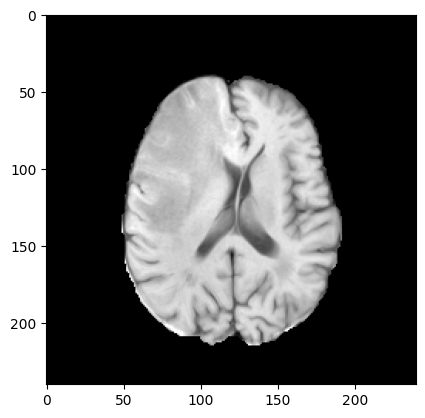

In [141]:
images = merge_and_transpose_images_rgb(rotate_90_deg_rgb(load_rgb_patient("sub-02063373")))
plt.imshow(images[80,:,:,0], cmap = "gray")

shape: (155, 240, 240, 4)
Max value: 1.0
Min value: 0.0


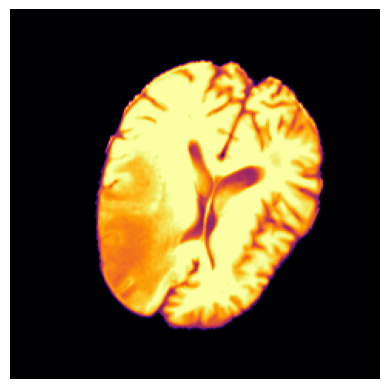

In [48]:
patient_images = prepare_images("sub-02063373")
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4), value_range=(0, 1)),
    #tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomRotation(factor = (-0.07, 0.07), fill_mode = "nearest"),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[80,:,:,1]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Min value:", np.array(augmented_images).min())

#### Data Augmentation - Volumentation

In [66]:
from volumentations import *

def get_augmentation():
    return Compose([Flip(2, p=1),
                    Rotate((-30, 30),(0,0),  (0,0), p=0),
                    RandomGamma(p=1)],
                    p=1.0)
#GaussianNoise(var_limit=(0, 5), p=0.2),
# Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
#                     Flip(0, p=0.5),
#                     Flip(1, p=0.5),
#                     Flip(2, p=0.5),
#                     ElasticTransform((0, 0.25), interpolation=2, p=0.1),
#                     RandomGamma(gamma_limit=(0.5, 1.5), p=0.2)]

def augmentor(img):
    aug = get_augmentation()
    data = {'image': img}
    aug_data = aug(**data)
    img = aug_data['image']
    return np.ndarray.astype(img , np.float32)

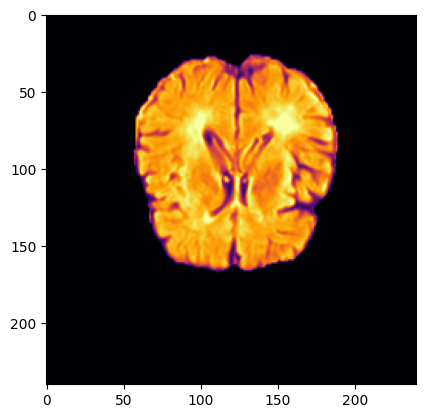

In [89]:

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4])
    image = data_augmentation(image)
    #image = tf.numpy_function(augmentor, [image], tf.float32)

    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)



# numpy_image = parsed_dataset.get_single_element()[0].numpy()
# plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    numpy_image = image.numpy()
    plt.imshow(numpy_image[80,:,:,0], cmap = "inferno")

#### TFRecord creation

#### Write all the training information to TFRecord

consider adding a seperate patient id to the all the tfrecord entries, to check if any errors occuring during shuffling

In [ ]:
# To-Do:
# shuffle training_patients
# create new tfr file
# go through list of sex, age, created image and primary and write to file
# fucking work

path_to_tfr = Path("/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord")

def write_to_tfr(patient_id, sex, age, primary):

    image = prepare_images(patient_id)
    imag_data = image.tobytes()

    #sex_data = bytes(sex, "utf-8")

    patient_example = Example(
        features = Features(
            feature = {
                "image": Feature(BytesList(value=imag_data)),
                "sex": Feature(BytesList(value=[sex])),
                "age": Feature(Int64List(value=[age])),
                "primary": Feature(Int64List(value=[primary]))
            }
        )
    )

    with tf.io.TFRecordWriter(path_to_tfr) as f:
        f.write(patient_example.SerializeToString())

write_to_tfr("sub-01641510", sex_array[0], training_patients["age"][0], primary=two_classes_primaries[0])


# Assuming you have your dataset in the following format
dataset = [
    {'sex': [1, 0], 'age': 25, 'primary': 1, 'image': np.random.rand(32, 32, 32, 3)},
    {'sex': [0, 1], 'age': 30, 'primary': 0, 'image': np.random.rand(32, 32, 32, 3)},
    # Add more entries as needed
]

# Function to serialize example
def serialize_example(sex, age, primary, image):
    feature = {
        'sex': tf.train.Feature(int64_list=tf.train.Int64List(value=sex)),
        'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
        'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image[:, :, :, :]).numpy()])),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Define the output TFRecord file
output_file = 'dataset.tfrecord'

# Write the dataset to TFRecord
with tf.io.TFRecordWriter(output_file) as writer:
    for data in dataset:
        example = serialize_example(data['sex'], data['age'], data['primary'], data['image'])
        writer.write(example)


 

In [2]:
path_to_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"


safe all patients in one large TFRecord File

In [54]:
def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

# sex_example = sex_encoded[0]
# id_example = training_patients["participant_id"][0]
# age_example = training_patients["age"][0]
# primary_example = two_classes_primaries[0]
# print(sex_example, id_example, age_example, primary_example)

# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset
with tf.io.TFRecordWriter(path_to_tfr, options) as writer:

    for i in tqdm(range(len(training_patients))): # iter over all entities in the dataframe

        sex = sex_encoded[i]
        id = training_patients["participant_id"][i]
        age = training_patients["age"][i]
        primary = two_classes_primaries[i]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

100%|██████████| 491/491 [3:27:22<00:00, 25.34s/it]  


#### Create a TFRecord File for testing

splits the testing tfrecord file into 4 seperate files, basically acting as k-folds

In [16]:
#path_to_testing_tfr = "/Volumes/BrainMets/Rgb_Brain_Mets/brain_mets_classification/derivatives/TFRecords/testing_patient_data_2classes.tfrecord"
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/testing_patient_data_2classes.tfrecord"

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


k = 4
fold_size = 3
testing_patients_lengths = 12


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patient_counter = 0

for fold_idx in range(k):

    file_path = f"/Users/LennartPhilipp/Desktop/Uni/Prowiss/Data.tmp/3D_CNN_whole/fold_{fold_idx}.tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        for i in range(fold_size):

            sex = sex_encoded[patient_counter]
            id = training_patients["participant_id"][patient_counter]
            age = training_patients["age"][patient_counter]
            primary = two_classes_primaries[patient_counter]
            example = serialize_patient(id, sex, age, primary)
            writer.write(example)
            patient_counter += 1
# with tf.io.TFRecordWriter(path_to_testing_tfr, options) as writer:

#     for i in tqdm(range(12)): # iter over all entities in the dataframe (prev. 8)

#         sex = sex_encoded[i]
#         id = training_patients["participant_id"][i]
#         age = training_patients["age"][i]
#         primary = two_classes_primaries[i]
#         example = serialize_patient(id, sex, age, primary)
#         writer.write(example)

#### Write one TFRecord per patient

In [15]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/testing_data/derivatives/preprocessed_n4_brainlesion_percentile_20240611-125716")

def serialize_patient(patientID, sex, age, primary):

    image_data = prepare_images(patientID)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value= sex)),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value=[age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value=[primary])),
            }   
        )
    )

    return patient_example.SerializeToString()


# Write the dataset to TFRecord
options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

path_to_all_tfr = path_to_derivatives / Path("all_pats_single")
os.makedirs(path_to_all_tfr, exist_ok=True)

for pat in range(len(patients)):

    file_path = str(path_to_all_tfr) + "/" + patients[pat] + ".tfrecord"
    with tf.io.TFRecordWriter(file_path, options) as writer:

        sex = sex_encoded[pat]
        id = training_patients["participant_id"][pat]
        age = training_patients["age"][pat]
        primary = two_classes_primaries[pat]
        example = serialize_patient(id, sex, age, primary)
        writer.write(example)

#### Read TFRecord File

In [3]:
path_to_tsv = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Dateien/dataset_patients_05_24.tsv"

patients = pd.read_csv(path_to_tsv, sep="\t")

[1 0]
46
1


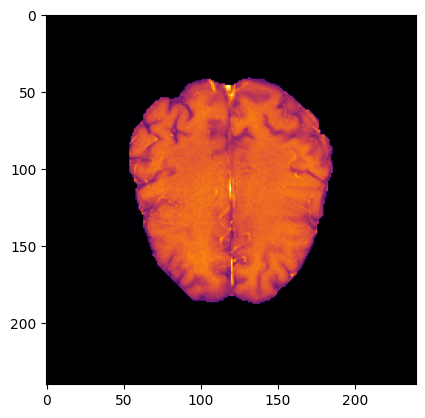

In [7]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/testing_data/derivatives/TFRecords/remote_tfrecords/sub-02063373.tfrecord"

feature_description = {
    "image": tf.io.FixedLenFeature([155, 240, 240, 4], tf.float32),
    "sex": tf.io.FixedLenFeature([2], tf.int64, default_value=[0,0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [155, 240, 240, 4]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    print(sex.numpy())
    print(age.numpy())
    print(primary.numpy())
    numpy_image = image.numpy()
    plt.imshow(numpy_image[100,:,:,0], cmap = "inferno")

# sex
# m = 1, 0
# f = 0, 1

### 2D Images

#### Prepare Images For Training
- load png files
- give options to load mask or cutout
- rotate images 90 degress?
- compress all sequences into one array 

In [9]:
path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")
#path_to_sliced_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_test_slices")

In [10]:
def load_2d_rgb_image(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):
    # order of sequences t1, t1c, t2, flair, maybe mask

    if save_as_rgb:
        cv2_num = 1
    else: # save as a single gray scale image
        cv2_num = 0

    leasions = []

    patient_files = [file for file in os.listdir(path_to_sliced_images / patient_id) if file.endswith(".png")]

    leasion_ids = {}

    counter = 0

    for file in patient_files:

        leasion = int(file.split("_")[3])

        if leasion not in leasion_ids.values():
            leasion_ids[counter] = leasion
            counter += 1

    #print(leasion_ids)

    # max_leasions = 0
    # for file in patient_files:
    #     leasion = int(file.split("_")[3])

    #     if leasion > max_leasions:
    #         max_leasions = leasion
    
    for leasion in range(len(leasion_ids.keys())):
        
        leasion_files = [file for file in patient_files if int(file.split("_")[3]) == (leasion_ids[leasion])]
        
        t1_image = None
        t1c_image = None
        t2_image = None
        flair_image = None
        mask_image = None

        if only_cutout == True:
            # load only cutout of t1, t1c, t2, flair
            leasion_files = [file for file in leasion_files if "cutout" in file]

            for file in leasion_files:
                sequence = file.split("_")[-2]

                path_to_file = str(path_to_sliced_images / patient_id / file)

                match sequence:
                    case "t1":
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]

        elif include_mask == True:
            # load t1, t1c, t2, flair, mask image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]
                
                match sequence:
                    case "t1":
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        pass

                if file.endswith("mask.png") and mask_image is None:
                    mask_image = cv2.imread(path_to_file, 0)

            images = [t1_image, t1c_image, t2_image, flair_image, mask_image]

        else:
            # load t1, t1c, t2, flair image

            for file in leasion_files:

                path_to_file = str(path_to_sliced_images / patient_id / file)

                sequence = file.split("_")[-1].split(".")[0]
                #print(sequence)
                match sequence:
                    case "t1":
                        #print("t1 image loaded")
                        t1_image = cv2.imread(path_to_file, cv2_num)
                    case "t1c":
                        t1c_image = cv2.imread(path_to_file, cv2_num)
                    case "t2":
                        t2_image = cv2.imread(path_to_file, cv2_num)
                    case "fla":
                        flair_image = cv2.imread(path_to_file, cv2_num)
                    case _:
                        #print("Wrong sequence set in the load_2d_rgb_image func, please pick a sequence between t1, t1c, t2, flair")
                        pass

            images = [t1_image, t1c_image, t2_image, flair_image]
        
        leasions.append(images)
    
    return leasions

def merge_2d_rgb_images(leasions):

    merged = []

    for leasion in leasions:
        stacked = tf.stack(leasion, axis = -1)
        merged.append(stacked)
    
    return tf.convert_to_tensor(merged)

def prepare_2d_rgb_images(patient_id, include_mask = False, only_cutout = False, save_as_rgb = False):

    leasions = load_2d_rgb_image(patient_id, include_mask, only_cutout, save_as_rgb)
    merged = merge_2d_rgb_images(leasions)

    return merged

(240, 240)


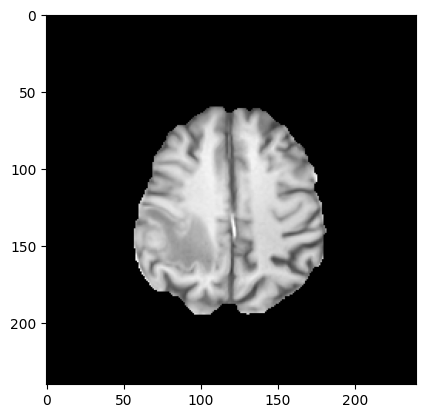

In [11]:
leasions = load_2d_rgb_image(patient_id = "sub-01134825",
                             include_mask = True,
                             only_cutout = False)

plt.imshow(leasions[0][0], cmap = "gray")

print(leasions[0][1].shape)

#merged = merge_2d_rgb_images(leasions)
# plt.imshow(merged[0][:,:,2], cmap = "gray")

#### Data Augmentation

custom layer that adjusts all pixel values to be between 0 and 1

In [62]:
class NormalizeToRange(tf.keras.layers.Layer):
    def __init__(self, zero_to_one=True):
        super(NormalizeToRange, self).__init__()
        self.zero_to_one = zero_to_one

    def call(self, inputs):
        min_val = tf.reduce_min(inputs)
        max_val = tf.reduce_max(inputs)
        if self.zero_to_one:
            # Normalize to [0, 1]
            normalized = (inputs - min_val) / (max_val - min_val)
        else:
            # Normalize to [-1, 1]
            normalized = 2 * (inputs - min_val) / (max_val - min_val) - 1
        return normalized

a simple data augmentation protocol that includes
- horizontal flip
- rescaling to 0 - 1
- random contrast
- random brightness
- random rotation
- rescaling again lol
- random translatio

I had to rescale the images again using a custom layer, so that all images values are between 0 and 1 in the end

shape: (240, 240, 5)
Max value: 1.0
Mean value: 0.18933669
Min value: 0.0


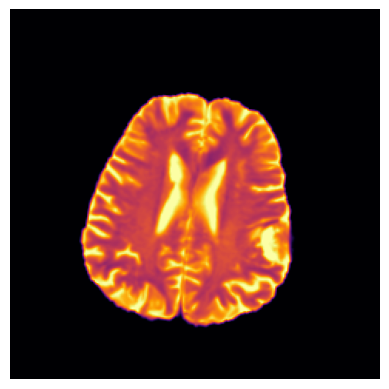

In [69]:
patient_images = merge_2d_rgb_images(load_2d_rgb_image(patient_id = "sub-01921604",
                            include_mask = True,
                            only_cutout = False))[1]
print(f"shape: {patient_images.shape}")

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = "horizontal"),
    #tf.keras.layers.Rescaling(1/255),
    tf.keras.layers.RandomContrast(0.5), # consider removing the random contrast layer as that causes pixel values to go beyond 1
    tf.keras.layers.RandomBrightness(factor = (-0.2, 0.4)), #, value_range=(0, 1)
    tf.keras.layers.RandomRotation(factor = (-0.1, 0.1), fill_mode = "nearest"),
    NormalizeToRange(zero_to_one=True),
    tf.keras.layers.RandomTranslation(
        height_factor = 0.05,
        width_factor = 0.05,
        fill_mode = "nearest"
    )
])

#consider adding some noise

augmented_images = data_augmentation(patient_images)

plt.imshow(np.array(augmented_images[:,:,2]), cmap="inferno")
plt.axis("off")

print("Max value:", np.array(augmented_images).max())
print("Mean value:", np.array(augmented_images).mean())
print("Min value:", np.array(augmented_images).min())

#### TFRecord Creation

In [12]:
path_to_derivatives = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords")
path_to_preprocessed_patients = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices")

tf.experimental.numpy.experimental_enable_numpy_behavior()

def serialize_2d_patient(image_data, sex, age, primary):

    #print(image_data.shape)

    #image_data = prepare_2d_rgb_images(patientID, include_mask = True, only_cutout = False)

    patient_example = Example(
        features = Features(
            feature = {
                'image': tf.train.Feature(float_list=tf.train.FloatList(value = image_data.ravel())),
                'sex': tf.train.Feature(int64_list=tf.train.Int64List(value = [sex])),
                'age': tf.train.Feature(int64_list=tf.train.Int64List(value = [age])),
                'primary': tf.train.Feature(int64_list=tf.train.Int64List(value= [primary])),
            }   
        )
    )

    return patient_example.SerializeToString()

def writeTFRecordFiles(save_as_rgb, save_as_cutout):
    # Write the dataset to TFRecord
    options = tf.io.TFRecordOptions(compression_type="GZIP") # compress the dataset

    patients = [patient for patient in os.listdir(path_to_preprocessed_patients) if os.path.isdir(os.path.join(path_to_preprocessed_patients, patient))]

    # write a check to compare patient_ids with patients
    patients = set(patients).intersection(patient_ids)

    slice_text = "cutout" if save_as_cutout else "slice"
    color_text = "rgb" if save_as_rgb else "gray"

    folder_text = f"all_pats_single_{slice_text}_{color_text}"

    path_to_all_tfr = path_to_derivatives / Path(folder_text)

    os.makedirs(path_to_all_tfr, exist_ok=True)

    # get list of already processed patients
    tfr_already_created_patients = [patient for patient in os.listdir(path_to_all_tfr) if os.path.isdir(os.path.join(path_to_all_tfr, patient))]

    for patient in tfr_already_created_patients:
        # check if the number of leasions equals the number of tfr files
        path_to_patient = path_to_all_tfr / patient
        tfr_files = [f for f in os.listdir(path_to_patient) if f.endswith(".tfrecord")]
        num_leasions = len(tfr_files)
        leasions = prepare_2d_rgb_images(patient, include_mask = True, only_cutout = save_as_cutout, save_as_rgb=save_as_rgb)
        if num_leasions != len(leasions):
            # delete the patient folder
            shutil.rmtree(path_to_patient)
            tfr_already_created_patients.remove(patient)
        

    for pat in tqdm(patients):

        if os.path.exists(path_to_all_tfr):
            if pat in tfr_already_created_patients:
                print(f"Skipping patient {pat}")
                continue

        # create patient folder
        path_to_patient = path_to_all_tfr / pat
        os.makedirs(path_to_patient, exist_ok=False)

        leasions = prepare_2d_rgb_images(pat, include_mask = False, only_cutout = save_as_cutout, save_as_rgb=save_as_rgb)
        print(f"found {len(leasions)} leasion(s) in patient {pat}")

        for i in range(len(leasions)):

            file_path = str(path_to_patient) + "/" + pat + "_" + str(i) + ".tfrecord"
            with tf.io.TFRecordWriter(file_path, options) as writer:

                sex = sex_array_dict[pat]
                leasion_data = leasions[i]
                age = int(list(training_patients[training_patients["participant_id"] == pat]["age"])[0])
                primary = specific_primaries_dict[pat]
                # print("________________")
                # print(age)
                example = serialize_2d_patient(leasion_data, sex, age, primary)
                writer.write(example)

In [13]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = False)

  0%|          | 0/470 [00:00<?, ?it/s]

found 3 leasion(s) in patient sub-01098043


  0%|          | 1/470 [00:37<4:51:33, 37.30s/it]

found 1 leasion(s) in patient sub-01216717


  0%|          | 2/470 [00:49<2:56:12, 22.59s/it]

found 2 leasion(s) in patient sub-01801060


  1%|          | 3/470 [01:14<3:03:35, 23.59s/it]

found 2 leasion(s) in patient sub-01565091


  1%|          | 4/470 [01:39<3:07:18, 24.12s/it]

found 1 leasion(s) in patient sub-01480742


  1%|          | 5/470 [01:51<2:34:36, 19.95s/it]

found 4 leasion(s) in patient sub-02095181


  1%|▏         | 6/470 [02:41<3:52:15, 30.03s/it]

Skipping patient sub-02036130
Skipping patient sub-01169240
found 1 leasion(s) in patient sub-02020169


  2%|▏         | 9/470 [02:53<1:52:43, 14.67s/it]

Skipping patient sub-01362907
found 6 leasion(s) in patient sub-02088404


  2%|▏         | 11/470 [04:08<2:54:07, 22.76s/it]

found 1 leasion(s) in patient sub-02179132


  3%|▎         | 12/470 [04:20<2:37:33, 20.64s/it]

Skipping patient sub-02167792
found 3 leasion(s) in patient sub-01657294


  3%|▎         | 14/470 [04:57<2:30:36, 19.82s/it]

found 2 leasion(s) in patient sub-01496804


  3%|▎         | 15/470 [05:22<2:38:49, 20.94s/it]

found 1 leasion(s) in patient sub-01621161


  3%|▎         | 16/470 [05:34<2:23:32, 18.97s/it]

found 1 leasion(s) in patient sub-02120806


  4%|▎         | 17/470 [05:47<2:10:54, 17.34s/it]

found 1 leasion(s) in patient sub-01393875


  4%|▍         | 18/470 [05:59<2:00:48, 16.04s/it]

found 7 leasion(s) in patient sub-01358619


  4%|▍         | 19/470 [07:26<4:25:14, 35.29s/it]

found 2 leasion(s) in patient sub-01486069


  4%|▍         | 20/470 [07:51<4:02:39, 32.35s/it]

found 1 leasion(s) in patient sub-02036251


  4%|▍         | 21/470 [08:03<3:19:30, 26.66s/it]

found 3 leasion(s) in patient sub-01587295


  5%|▍         | 22/470 [08:40<3:41:12, 29.63s/it]

found 1 leasion(s) in patient sub-93003757


  5%|▍         | 23/470 [08:53<3:03:25, 24.62s/it]

found 2 leasion(s) in patient sub-01038520


  5%|▌         | 24/470 [09:18<3:04:50, 24.87s/it]

Skipping patient sub-01652130
found 2 leasion(s) in patient sub-01921604


  6%|▌         | 26/470 [09:43<2:21:41, 19.15s/it]

found 3 leasion(s) in patient sub-02026964


  6%|▌         | 27/470 [10:20<2:54:51, 23.68s/it]

found 1 leasion(s) in patient sub-01545797


  6%|▌         | 28/470 [10:33<2:32:50, 20.75s/it]

found 1 leasion(s) in patient sub-02146286


  6%|▌         | 29/470 [10:45<2:16:01, 18.51s/it]

Skipping patient sub-01549022
Skipping patient sub-02135803
found 2 leasion(s) in patient sub-01119720


  7%|▋         | 32/470 [11:10<1:35:14, 13.05s/it]

found 3 leasion(s) in patient sub-01420310


  7%|▋         | 33/470 [11:48<2:11:53, 18.11s/it]

found 3 leasion(s) in patient sub-01771120


  7%|▋         | 34/470 [12:25<2:42:58, 22.43s/it]

found 1 leasion(s) in patient sub-01942928


  7%|▋         | 35/470 [12:38<2:25:19, 20.05s/it]

Skipping patient sub-01883957
Skipping patient sub-01781732
Skipping patient sub-01022787
found 1 leasion(s) in patient sub-01607473


  8%|▊         | 39/470 [12:50<1:13:08, 10.18s/it]

found 1 leasion(s) in patient sub-01958155


  9%|▊         | 40/470 [13:03<1:16:15, 10.64s/it]

found 15 leasion(s) in patient sub-01494236


  9%|▊         | 41/470 [16:08<5:22:04, 45.05s/it]

Skipping patient sub-02110064
found 1 leasion(s) in patient sub-02113718


  9%|▉         | 43/470 [16:21<3:40:42, 31.01s/it]

found 1 leasion(s) in patient sub-01584596


  9%|▉         | 44/470 [16:33<3:12:51, 27.16s/it]

found 2 leasion(s) in patient sub-02097980


 10%|▉         | 45/470 [16:57<3:08:10, 26.56s/it]

found 1 leasion(s) in patient sub-01456959


 10%|▉         | 46/470 [17:10<2:43:11, 23.09s/it]

found 1 leasion(s) in patient sub-02015335


 10%|█         | 47/470 [17:22<2:23:26, 20.35s/it]

Skipping patient sub-01578955
found 7 leasion(s) in patient sub-01496608


 10%|█         | 49/470 [18:48<3:29:54, 29.92s/it]

Skipping patient sub-01905848
found 4 leasion(s) in patient sub-02172137


 11%|█         | 51/470 [19:37<3:14:41, 27.88s/it]

Skipping patient sub-01592849
found 1 leasion(s) in patient sub-01117958


 11%|█▏        | 53/470 [19:49<2:20:54, 20.27s/it]

found 1 leasion(s) in patient sub-01005097


 11%|█▏        | 54/470 [20:01<2:09:21, 18.66s/it]

found 2 leasion(s) in patient sub-01548397


 12%|█▏        | 55/470 [20:26<2:18:15, 19.99s/it]

found 6 leasion(s) in patient sub-01641960


 12%|█▏        | 56/470 [21:39<3:46:35, 32.84s/it]

found 3 leasion(s) in patient sub-01390721


 12%|█▏        | 57/470 [22:16<3:52:55, 33.84s/it]

Skipping patient sub-01616246
Skipping patient sub-01681275
found 6 leasion(s) in patient sub-01706146


 13%|█▎        | 60/470 [23:29<3:17:29, 28.90s/it]

found 3 leasion(s) in patient sub-02012594


 13%|█▎        | 61/470 [24:06<3:27:27, 30.43s/it]

found 2 leasion(s) in patient sub-02136965


 13%|█▎        | 62/470 [24:30<3:17:39, 29.07s/it]

found 66 leasion(s) in patient sub-02113470


 13%|█▎        | 63/470 [37:46<24:08:47, 213.58s/it]

Skipping patient sub-01764802
found 1 leasion(s) in patient sub-01214172


 14%|█▍        | 65/470 [37:58<14:30:58, 129.03s/it]

Skipping patient sub-01381621
found 1 leasion(s) in patient sub-01125016


 14%|█▍        | 67/470 [38:10<9:22:35, 83.76s/it]  

found 5 leasion(s) in patient sub-02119712


 14%|█▍        | 68/470 [39:11<8:48:57, 78.95s/it]

found 5 leasion(s) in patient sub-01596127


 15%|█▍        | 69/470 [40:11<8:18:15, 74.55s/it]

found 2 leasion(s) in patient sub-01450871


 15%|█▍        | 70/470 [40:34<6:53:43, 62.06s/it]

Skipping patient sub-01391534
found 1 leasion(s) in patient sub-01402283


 15%|█▌        | 72/470 [40:46<4:17:57, 38.89s/it]

found 4 leasion(s) in patient sub-02036053


 16%|█▌        | 73/470 [41:36<4:33:09, 41.28s/it]

found 8 leasion(s) in patient sub-02015217


 16%|█▌        | 74/470 [43:14<6:04:28, 55.22s/it]

found 1 leasion(s) in patient sub-02075769


 16%|█▌        | 75/470 [43:26<4:50:00, 44.05s/it]

found 1 leasion(s) in patient sub-02181503


 16%|█▌        | 76/470 [43:38<3:52:47, 35.45s/it]

Skipping patient sub-01798755
found 2 leasion(s) in patient sub-01414189


 17%|█▋        | 78/470 [44:03<2:45:47, 25.38s/it]

found 3 leasion(s) in patient sub-02140670


 17%|█▋        | 79/470 [44:40<3:03:25, 28.15s/it]

found 1 leasion(s) in patient sub-01659187


 17%|█▋        | 80/470 [44:53<2:37:02, 24.16s/it]

found 1 leasion(s) in patient sub-02036854


 17%|█▋        | 81/470 [45:05<2:16:03, 20.99s/it]

Skipping patient sub-01691369
found 1 leasion(s) in patient sub-01957247


 18%|█▊        | 83/470 [45:17<1:33:56, 14.56s/it]

Skipping patient sub-01882333
found 3 leasion(s) in patient sub-01619086


 18%|█▊        | 85/470 [45:53<1:42:31, 15.98s/it]

found 1 leasion(s) in patient sub-02086122


 18%|█▊        | 86/470 [46:06<1:37:25, 15.22s/it]

found 2 leasion(s) in patient sub-01056884


 19%|█▊        | 87/470 [46:31<1:51:15, 17.43s/it]

found 2 leasion(s) in patient sub-01274157


 19%|█▊        | 88/470 [46:55<2:02:19, 19.21s/it]

found 3 leasion(s) in patient sub-01906150


 19%|█▉        | 89/470 [47:32<2:32:05, 23.95s/it]

found 24 leasion(s) in patient sub-02190209


 19%|█▉        | 90/470 [52:24<10:15:13, 97.14s/it]

found 1 leasion(s) in patient sub-01288036


 19%|█▉        | 91/470 [52:36<7:42:53, 73.28s/it] 

found 1 leasion(s) in patient sub-01391984


 20%|█▉        | 92/470 [52:48<5:50:57, 55.71s/it]

found 1 leasion(s) in patient sub-01041137


 20%|█▉        | 93/470 [53:00<4:30:28, 43.05s/it]

Skipping patient sub-01616767
found 2 leasion(s) in patient sub-02063986


 20%|██        | 95/470 [53:24<3:01:16, 29.00s/it]

found 3 leasion(s) in patient sub-01005630


 20%|██        | 96/470 [54:00<3:11:10, 30.67s/it]

found 2 leasion(s) in patient sub-01214417


 21%|██        | 97/470 [54:24<3:00:14, 28.99s/it]

Skipping patient sub-01357275
found 1 leasion(s) in patient sub-01830168


 21%|██        | 99/470 [54:36<1:58:56, 19.24s/it]

found 8 leasion(s) in patient sub-02173158


 21%|██▏       | 100/470 [56:13<3:49:15, 37.18s/it]

found 2 leasion(s) in patient sub-01099901


 21%|██▏       | 101/470 [56:36<3:28:15, 33.86s/it]

Skipping patient sub-01441531
found 5 leasion(s) in patient sub-02014467


 22%|██▏       | 103/470 [57:37<3:17:35, 32.30s/it]

found 1 leasion(s) in patient sub-02119444


 22%|██▏       | 104/470 [57:49<2:48:40, 27.65s/it]

found 1 leasion(s) in patient sub-01819252


 22%|██▏       | 105/470 [58:01<2:25:15, 23.88s/it]

Skipping patient sub-02031868
Skipping patient sub-01419998
found 1 leasion(s) in patient sub-01935938


 23%|██▎       | 108/470 [58:13<1:22:34, 13.69s/it]

found 1 leasion(s) in patient sub-01703264


 23%|██▎       | 109/470 [58:25<1:20:40, 13.41s/it]

found 1 leasion(s) in patient sub-02019520


 23%|██▎       | 110/470 [58:37<1:18:38, 13.11s/it]

found 4 leasion(s) in patient sub-80004059


 24%|██▎       | 111/470 [59:25<2:08:03, 21.40s/it]

found 21 leasion(s) in patient sub-02127770


 24%|██▍       | 112/470 [1:03:38<7:58:03, 80.12s/it]

found 2 leasion(s) in patient sub-02116290


 24%|██▍       | 113/470 [1:04:02<6:28:11, 65.24s/it]

found 2 leasion(s) in patient sub-02096374


 24%|██▍       | 114/470 [1:04:26<5:19:58, 53.93s/it]

found 1 leasion(s) in patient sub-01457167


 24%|██▍       | 115/470 [1:04:38<4:08:52, 42.06s/it]

found 0 leasion(s) in patient sub-02100576
found 3 leasion(s) in patient sub-01443624


 25%|██▍       | 117/470 [1:05:14<3:04:04, 31.29s/it]

found 3 leasion(s) in patient sub-01713725


 25%|██▌       | 118/470 [1:05:51<3:10:59, 32.55s/it]

found 2 leasion(s) in patient sub-01220269


 25%|██▌       | 119/470 [1:06:15<2:57:46, 30.39s/it]

found 1 leasion(s) in patient sub-96004436


 26%|██▌       | 120/470 [1:06:27<2:28:46, 25.51s/it]

found 1 leasion(s) in patient sub-01905692


 26%|██▌       | 121/470 [1:06:39<2:06:29, 21.75s/it]

Skipping patient sub-01370265
found 45 leasion(s) in patient sub-01812578


 26%|██▌       | 123/470 [1:15:39<12:40:28, 131.49s/it]

found 5 leasion(s) in patient sub-01021714


 26%|██▋       | 124/470 [1:16:39<10:59:18, 114.33s/it]

found 1 leasion(s) in patient sub-01373703


 27%|██▋       | 125/470 [1:16:51<8:27:18, 88.23s/it]  

Skipping patient sub-01936520
found 1 leasion(s) in patient sub-01377175


 27%|██▋       | 127/470 [1:17:03<5:06:11, 53.56s/it]

found 15 leasion(s) in patient sub-01241505


 27%|██▋       | 128/470 [1:20:02<7:51:19, 82.69s/it]

found 5 leasion(s) in patient sub-01483723


 27%|██▋       | 129/470 [1:21:02<7:17:39, 77.01s/it]

Skipping patient sub-01164049
Skipping patient sub-02155605
found 1 leasion(s) in patient sub-01395836


 28%|██▊       | 132/470 [1:21:14<3:41:43, 39.36s/it]

Skipping patient sub-01018613
found 2 leasion(s) in patient sub-01309950


 29%|██▊       | 134/470 [1:21:38<2:49:45, 30.31s/it]

Skipping patient sub-01961554
found 1 leasion(s) in patient sub-01543367


 29%|██▉       | 136/470 [1:21:50<2:05:30, 22.55s/it]

found 1 leasion(s) in patient sub-01213140


 29%|██▉       | 137/470 [1:22:03<1:54:38, 20.66s/it]

found 2 leasion(s) in patient sub-02014068


 29%|██▉       | 138/470 [1:22:27<1:58:13, 21.36s/it]

found 3 leasion(s) in patient sub-01147272


 30%|██▉       | 139/470 [1:23:03<2:16:21, 24.72s/it]

Skipping patient sub-02047436
found 1 leasion(s) in patient sub-90005031


 30%|███       | 141/470 [1:23:14<1:34:36, 17.25s/it]

found 1 leasion(s) in patient sub-01947074


 30%|███       | 142/470 [1:23:27<1:28:11, 16.13s/it]

found 3 leasion(s) in patient sub-01542729


 30%|███       | 143/470 [1:24:03<1:54:10, 20.95s/it]

found 17 leasion(s) in patient sub-01804484


 31%|███       | 144/470 [1:27:27<6:07:42, 67.68s/it]

Skipping patient sub-01702596
Skipping patient sub-02010452
found 1 leasion(s) in patient sub-01796937


 31%|███▏      | 147/470 [1:27:39<3:05:29, 34.46s/it]

Skipping patient sub-01885520
found 1 leasion(s) in patient sub-01650072


 32%|███▏      | 149/470 [1:27:51<2:13:42, 24.99s/it]

found 1 leasion(s) in patient sub-02088565


 32%|███▏      | 150/470 [1:28:03<2:00:04, 22.51s/it]

found 1 leasion(s) in patient sub-02063373


 32%|███▏      | 151/470 [1:28:15<1:47:34, 20.23s/it]

found 2 leasion(s) in patient sub-01673701


 32%|███▏      | 152/470 [1:28:39<1:52:00, 21.13s/it]

found 2 leasion(s) in patient sub-02178883


 33%|███▎      | 153/470 [1:29:03<1:55:53, 21.94s/it]

Skipping patient sub-01696845
Skipping patient sub-01589112
found 1 leasion(s) in patient sub-01130856


 33%|███▎      | 156/470 [1:29:15<1:06:02, 12.62s/it]

Skipping patient sub-01729917
found 1 leasion(s) in patient sub-01661279


 34%|███▎      | 158/470 [1:29:27<54:05, 10.40s/it]  

found 5 leasion(s) in patient sub-02131818


 34%|███▍      | 159/470 [1:30:27<1:42:45, 19.82s/it]

Skipping patient sub-01892684
found 3 leasion(s) in patient sub-01311383


 34%|███▍      | 161/470 [1:31:03<1:39:02, 19.23s/it]

found 3 leasion(s) in patient sub-01307298


 34%|███▍      | 162/470 [1:31:39<1:55:54, 22.58s/it]

found 11 leasion(s) in patient sub-01705952


 35%|███▍      | 163/470 [1:33:52<4:01:15, 47.15s/it]

found 2 leasion(s) in patient sub-01421533


 35%|███▍      | 164/470 [1:34:15<3:31:41, 41.51s/it]

found 9 leasion(s) in patient sub-01695094


 35%|███▌      | 165/470 [1:36:03<4:57:48, 58.58s/it]

found 3 leasion(s) in patient sub-01979317


 35%|███▌      | 166/470 [1:36:40<4:26:22, 52.57s/it]

Skipping patient sub-01547588
found 1 leasion(s) in patient sub-01572564


 36%|███▌      | 168/470 [1:36:52<2:42:53, 32.36s/it]

found 1 leasion(s) in patient sub-01660211


 36%|███▌      | 169/470 [1:37:04<2:18:07, 27.53s/it]

Skipping patient sub-01717958
found 24 leasion(s) in patient sub-01373833


 36%|███▋      | 171/470 [1:41:52<6:11:27, 74.54s/it]

Skipping patient sub-02073198
Skipping patient sub-01478990
Skipping patient sub-01812518
found 7 leasion(s) in patient sub-01502083


 37%|███▋      | 175/470 [1:43:15<3:45:24, 45.85s/it]

found 12 leasion(s) in patient sub-01870024


 37%|███▋      | 176/470 [1:45:39<5:01:24, 61.51s/it]

found 2 leasion(s) in patient sub-01882989


 38%|███▊      | 177/470 [1:46:03<4:26:33, 54.58s/it]

found 1 leasion(s) in patient sub-90003562


 38%|███▊      | 178/470 [1:46:15<3:41:57, 45.61s/it]

found 7 leasion(s) in patient sub-90005297


 38%|███▊      | 179/470 [1:47:39<4:23:45, 54.38s/it]

found 1 leasion(s) in patient sub-01698789


 38%|███▊      | 180/470 [1:47:51<3:31:50, 43.83s/it]

Skipping patient sub-02082498
found 2 leasion(s) in patient sub-01732456


 39%|███▊      | 182/470 [1:48:15<2:27:06, 30.65s/it]

Skipping patient sub-01699532
found 5 leasion(s) in patient sub-02154718


 39%|███▉      | 184/470 [1:49:15<2:25:30, 30.53s/it]

found 3 leasion(s) in patient sub-01990699


 39%|███▉      | 185/470 [1:49:51<2:30:22, 31.66s/it]

found 1 leasion(s) in patient sub-01762556


 40%|███▉      | 186/470 [1:50:03<2:08:22, 27.12s/it]

found 1 leasion(s) in patient sub-01709242


 40%|███▉      | 187/470 [1:50:15<1:50:08, 23.35s/it]

found 11 leasion(s) in patient sub-01879950


 40%|████      | 188/470 [1:52:27<4:02:55, 51.69s/it]

found 1 leasion(s) in patient sub-01415245


 40%|████      | 189/470 [1:52:39<3:11:26, 40.88s/it]

found 1 leasion(s) in patient sub-02106388


 40%|████      | 190/470 [1:52:51<2:33:01, 32.79s/it]

found 9 leasion(s) in patient sub-01190738


 41%|████      | 191/470 [1:54:39<4:12:01, 54.20s/it]

found 2 leasion(s) in patient sub-01189050


 41%|████      | 192/470 [1:55:03<3:30:32, 45.44s/it]

found 1 leasion(s) in patient sub-01405609


 41%|████      | 193/470 [1:55:14<2:44:23, 35.61s/it]

found 1 leasion(s) in patient sub-01196057


 41%|████▏     | 194/470 [1:55:26<2:11:32, 28.60s/it]

Skipping patient sub-02152734
found 4 leasion(s) in patient sub-01021993


 42%|████▏     | 196/470 [1:56:14<2:01:04, 26.51s/it]

found 3 leasion(s) in patient sub-01914558


 42%|████▏     | 197/470 [1:56:50<2:11:20, 28.87s/it]

found 5 leasion(s) in patient sub-01055292


 42%|████▏     | 198/470 [1:57:51<2:47:57, 37.05s/it]

found 4 leasion(s) in patient sub-02167890


 42%|████▏     | 199/470 [1:58:39<3:00:48, 40.03s/it]

found 4 leasion(s) in patient sub-02000864


 43%|████▎     | 200/470 [1:59:27<3:10:08, 42.25s/it]

found 1 leasion(s) in patient sub-01583797


 43%|████▎     | 201/470 [1:59:39<2:30:42, 33.61s/it]

found 2 leasion(s) in patient sub-01109318


 43%|████▎     | 202/470 [2:00:03<2:17:58, 30.89s/it]

found 2 leasion(s) in patient sub-02128777


 43%|████▎     | 203/470 [2:00:27<2:08:24, 28.85s/it]

found 1 leasion(s) in patient sub-01997658


 43%|████▎     | 204/470 [2:00:39<1:45:50, 23.87s/it]

found 28 leasion(s) in patient sub-02105939


 44%|████▎     | 205/470 [2:06:14<8:32:32, 116.05s/it]

found 1 leasion(s) in patient sub-01674416


 44%|████▍     | 206/470 [2:06:26<6:14:22, 85.08s/it] 

found 3 leasion(s) in patient sub-01795656


 44%|████▍     | 207/470 [2:07:02<5:08:50, 70.46s/it]

found 1 leasion(s) in patient sub-02020631


 44%|████▍     | 208/470 [2:07:14<3:51:27, 53.00s/it]

found 1 leasion(s) in patient sub-01483526


 44%|████▍     | 209/470 [2:07:26<2:57:07, 40.72s/it]

Skipping patient sub-01805334
found 1 leasion(s) in patient sub-01134825


 45%|████▍     | 211/470 [2:07:38<1:46:33, 24.68s/it]

found 3 leasion(s) in patient sub-01492723


 45%|████▌     | 212/470 [2:08:14<1:58:11, 27.49s/it]

found 11 leasion(s) in patient sub-02094837


 45%|████▌     | 213/470 [2:10:25<3:54:29, 54.75s/it]

Skipping patient sub-02094018
found 1 leasion(s) in patient sub-01518885


 46%|████▌     | 215/470 [2:10:37<2:24:08, 33.92s/it]

found 0 leasion(s) in patient sub-02145622
Skipping patient sub-02051037
found 1 leasion(s) in patient sub-01188297


 46%|████▋     | 218/470 [2:10:49<1:22:18, 19.60s/it]

found 10 leasion(s) in patient sub-01489395


 47%|████▋     | 219/470 [2:12:50<2:40:48, 38.44s/it]

found 7 leasion(s) in patient sub-02066445


 47%|████▋     | 220/470 [2:14:14<3:19:47, 47.95s/it]

found 3 leasion(s) in patient sub-02184584


 47%|████▋     | 221/470 [2:14:50<3:07:20, 45.14s/it]

found 2 leasion(s) in patient sub-01435731


 47%|████▋     | 222/470 [2:15:14<2:45:23, 40.01s/it]

found 3 leasion(s) in patient sub-01410317


 47%|████▋     | 223/470 [2:15:50<2:39:53, 38.84s/it]

Skipping patient sub-01710250
found 28 leasion(s) in patient sub-01111974


 48%|████▊     | 225/470 [2:21:26<6:24:14, 94.10s/it]

Skipping patient sub-01288350
found 1 leasion(s) in patient sub-01952689


 48%|████▊     | 227/470 [2:21:38<4:05:45, 60.68s/it]

found 2 leasion(s) in patient sub-01269967


 49%|████▊     | 228/470 [2:22:02<3:33:20, 52.89s/it]

found 4 leasion(s) in patient sub-01201482


 49%|████▊     | 229/470 [2:22:51<3:28:09, 51.82s/it]

found 1 leasion(s) in patient sub-02073121


 49%|████▉     | 230/470 [2:23:03<2:47:28, 41.87s/it]

found 2 leasion(s) in patient sub-02197683


 49%|████▉     | 231/470 [2:23:26<2:27:45, 37.10s/it]

Skipping patient sub-02095303
found 1 leasion(s) in patient sub-02165732


 50%|████▉     | 233/470 [2:23:38<1:33:51, 23.76s/it]

found 2 leasion(s) in patient sub-01763867


 50%|████▉     | 234/470 [2:24:03<1:33:52, 23.87s/it]

found 1 leasion(s) in patient sub-01594137


 50%|█████     | 235/470 [2:24:15<1:22:13, 20.99s/it]

found 1 leasion(s) in patient sub-02094355


 50%|█████     | 236/470 [2:24:27<1:12:34, 18.61s/it]

found 2 leasion(s) in patient sub-01893873


 50%|█████     | 237/470 [2:24:51<1:17:51, 20.05s/it]

found 1 leasion(s) in patient sub-01243841


 51%|█████     | 238/470 [2:25:03<1:08:53, 17.82s/it]

Skipping patient sub-02122538
found 1 leasion(s) in patient sub-01130173


 51%|█████     | 240/470 [2:25:15<48:15, 12.59s/it]  

found 1 leasion(s) in patient sub-01710310


 51%|█████▏    | 241/470 [2:25:27<47:29, 12.44s/it]

found 3 leasion(s) in patient sub-01515235


 51%|█████▏    | 242/470 [2:26:03<1:10:29, 18.55s/it]

found 3 leasion(s) in patient sub-01505384


 52%|█████▏    | 243/470 [2:26:39<1:27:33, 23.14s/it]

found 6 leasion(s) in patient sub-01755816


 52%|█████▏    | 244/470 [2:27:51<2:17:58, 36.63s/it]

Skipping patient sub-01706562
Skipping patient sub-02055312
Skipping patient sub-01122863
found 1 leasion(s) in patient sub-01231700


 53%|█████▎    | 248/470 [2:28:03<59:18, 16.03s/it]  

found 2 leasion(s) in patient sub-01924997


 53%|█████▎    | 249/470 [2:28:27<1:04:18, 17.46s/it]

Skipping patient sub-01953116
found 2 leasion(s) in patient sub-01874079


 53%|█████▎    | 251/470 [2:28:51<56:55, 15.60s/it]  

found 0 leasion(s) in patient sub-01957841
found 1 leasion(s) in patient sub-01332588


 54%|█████▍    | 253/470 [2:29:03<45:07, 12.48s/it]

found 1 leasion(s) in patient sub-80011453


 54%|█████▍    | 254/470 [2:29:15<44:39, 12.41s/it]

found 1 leasion(s) in patient sub-01458719


 54%|█████▍    | 255/470 [2:29:27<44:09, 12.32s/it]

Skipping patient sub-01978091
found 1 leasion(s) in patient sub-01670714


 55%|█████▍    | 257/470 [2:29:39<35:12,  9.92s/it]

found 5 leasion(s) in patient sub-01744565


 55%|█████▍    | 258/470 [2:30:39<1:12:29, 20.52s/it]

found 6 leasion(s) in patient sub-01779701


 55%|█████▌    | 259/470 [2:31:52<1:55:01, 32.71s/it]

Skipping patient sub-02080563
Skipping patient sub-02084961
found 6 leasion(s) in patient sub-02046093


 56%|█████▌    | 262/470 [2:33:04<1:38:15, 28.34s/it]

found 1 leasion(s) in patient sub-01483116


 56%|█████▌    | 263/470 [2:33:15<1:26:52, 25.18s/it]

found 2 leasion(s) in patient sub-02190005


 56%|█████▌    | 264/470 [2:33:39<1:25:28, 24.90s/it]

found 1 leasion(s) in patient sub-02066389


 56%|█████▋    | 265/470 [2:33:51<1:14:45, 21.88s/it]

Skipping patient sub-02031256
found 1 leasion(s) in patient sub-01432274


 57%|█████▋    | 267/470 [2:34:03<52:28, 15.51s/it]  

Skipping patient sub-01991292
Skipping patient sub-01695080
found 18 leasion(s) in patient sub-01946271


 57%|█████▋    | 270/470 [2:37:40<2:19:04, 41.72s/it]

found 7 leasion(s) in patient sub-02209727


 58%|█████▊    | 271/470 [2:39:04<2:43:36, 49.33s/it]

Skipping patient sub-01398968
found 3 leasion(s) in patient sub-01437004


 58%|█████▊    | 273/470 [2:39:40<2:06:52, 38.64s/it]

found 2 leasion(s) in patient sub-01340749


 58%|█████▊    | 274/470 [2:40:04<1:56:49, 35.76s/it]

found 1 leasion(s) in patient sub-01961566


 59%|█████▊    | 275/470 [2:40:16<1:39:26, 30.60s/it]

found 2 leasion(s) in patient sub-02071087


 59%|█████▊    | 276/470 [2:40:39<1:33:44, 28.99s/it]

found 2 leasion(s) in patient sub-96003928


 59%|█████▉    | 277/470 [2:41:03<1:29:05, 27.70s/it]

found 2 leasion(s) in patient sub-01924748


 59%|█████▉    | 278/470 [2:41:27<1:25:24, 26.69s/it]

found 1 leasion(s) in patient sub-01484016


 59%|█████▉    | 279/470 [2:41:39<1:11:57, 22.61s/it]

Skipping patient sub-01871625
Skipping patient sub-01969755
Skipping patient sub-01654658
found 5 leasion(s) in patient sub-01789555


 60%|██████    | 283/470 [2:42:40<56:10, 18.03s/it]  

found 8 leasion(s) in patient sub-01516702


 60%|██████    | 284/470 [2:44:16<1:39:22, 32.06s/it]

found 23 leasion(s) in patient sub-01516618


 61%|██████    | 285/470 [2:48:53<4:12:43, 81.96s/it]

found 1 leasion(s) in patient sub-01773716


 61%|██████    | 286/470 [2:49:05<3:23:01, 66.21s/it]

Skipping patient sub-93002557
Skipping patient sub-02018743
found 1 leasion(s) in patient sub-02164825


 61%|██████▏   | 289/470 [2:49:17<1:47:33, 35.65s/it]

Skipping patient sub-02120805
found 1 leasion(s) in patient sub-01015961


 62%|██████▏   | 291/470 [2:49:29<1:18:11, 26.21s/it]

found 6 leasion(s) in patient sub-02168956


 62%|██████▏   | 292/470 [2:50:41<1:42:55, 34.70s/it]

Skipping patient sub-02148372
Skipping patient sub-02026140
found 3 leasion(s) in patient sub-01754011


 63%|██████▎   | 295/470 [2:51:17<1:11:54, 24.65s/it]

found 9 leasion(s) in patient sub-01943022


 63%|██████▎   | 296/470 [2:53:05<1:53:42, 39.21s/it]

found 1 leasion(s) in patient sub-02070580


 63%|██████▎   | 297/470 [2:53:17<1:37:28, 33.80s/it]

found 1 leasion(s) in patient sub-01400779


 63%|██████▎   | 298/470 [2:53:29<1:23:05, 28.99s/it]

found 1 leasion(s) in patient sub-01982853


 64%|██████▎   | 299/470 [2:53:42<1:11:07, 24.96s/it]

found 1 leasion(s) in patient sub-02137062


 64%|██████▍   | 300/470 [2:53:54<1:01:21, 21.65s/it]

found 2 leasion(s) in patient sub-01164986


 64%|██████▍   | 301/470 [2:54:18<1:03:11, 22.44s/it]

found 3 leasion(s) in patient sub-01966470


 64%|██████▍   | 302/470 [2:54:55<1:14:03, 26.45s/it]

found 4 leasion(s) in patient sub-02124336


 64%|██████▍   | 303/470 [2:55:43<1:30:16, 32.43s/it]

Skipping patient sub-02082001
found 2 leasion(s) in patient sub-01479403


 65%|██████▍   | 305/470 [2:56:07<1:03:56, 23.25s/it]

Skipping patient sub-01979997
found 1 leasion(s) in patient sub-01499528


 65%|██████▌   | 307/470 [2:56:19<44:57, 16.55s/it]  

found 3 leasion(s) in patient sub-01732889


 66%|██████▌   | 308/470 [2:56:55<56:19, 20.86s/it]

found 1 leasion(s) in patient sub-02185066


 66%|██████▌   | 309/470 [2:57:07<50:19, 18.75s/it]

found 6 leasion(s) in patient sub-01713022


 66%|██████▌   | 310/470 [2:58:19<1:25:47, 32.17s/it]

found 2 leasion(s) in patient sub-01696904


 66%|██████▌   | 311/470 [2:58:43<1:19:55, 30.16s/it]

found 1 leasion(s) in patient sub-02071305


 66%|██████▋   | 312/470 [2:58:56<1:06:27, 25.24s/it]

found 6 leasion(s) in patient sub-01117914


 67%|██████▋   | 313/470 [3:00:08<1:40:30, 38.41s/it]

found 7 leasion(s) in patient sub-02197114


 67%|██████▋   | 314/470 [3:01:32<2:14:24, 51.70s/it]

found 1 leasion(s) in patient sub-02034046


 67%|██████▋   | 315/470 [3:01:44<1:43:47, 40.18s/it]

found 1 leasion(s) in patient sub-02087023


 67%|██████▋   | 316/470 [3:01:57<1:22:07, 32.00s/it]

found 1 leasion(s) in patient sub-01494733


 67%|██████▋   | 317/470 [3:02:09<1:06:39, 26.14s/it]

found 19 leasion(s) in patient sub-02134991


 68%|██████▊   | 318/470 [3:05:57<3:38:04, 86.08s/it]

found 1 leasion(s) in patient sub-01895825


 68%|██████▊   | 319/470 [3:06:09<2:41:06, 64.02s/it]

found 1 leasion(s) in patient sub-01414540


 68%|██████▊   | 320/470 [3:06:21<2:01:34, 48.63s/it]

found 21 leasion(s) in patient sub-01056598


 68%|██████▊   | 321/470 [3:10:34<4:32:14, 109.63s/it]

found 1 leasion(s) in patient sub-01769144


 69%|██████▊   | 322/470 [3:10:46<3:18:18, 80.39s/it] 

Skipping patient sub-01072344
Skipping patient sub-02145747
found 1 leasion(s) in patient sub-01649133


 69%|██████▉   | 325/470 [3:10:58<1:30:30, 37.45s/it]

found 0 leasion(s) in patient sub-02153522
found 1 leasion(s) in patient sub-01006290


 70%|██████▉   | 327/470 [3:11:10<1:03:07, 26.49s/it]

found 1 leasion(s) in patient sub-01707275


 70%|██████▉   | 328/470 [3:11:22<55:57, 23.64s/it]  

Skipping patient sub-01452858
found 1 leasion(s) in patient sub-01288245


 70%|███████   | 330/470 [3:11:34<40:14, 17.25s/it]

found 3 leasion(s) in patient sub-01331487


 70%|███████   | 331/470 [3:12:11<49:04, 21.18s/it]

found 1 leasion(s) in patient sub-01083248


 71%|███████   | 332/470 [3:12:23<43:53, 19.09s/it]

found 1 leasion(s) in patient sub-01521835


 71%|███████   | 333/470 [3:12:34<39:35, 17.34s/it]

found 1 leasion(s) in patient sub-01314225


 71%|███████   | 334/470 [3:12:47<36:12, 15.97s/it]

found 1 leasion(s) in patient sub-01513891


 71%|███████▏  | 335/470 [3:12:59<33:33, 14.92s/it]

found 35 leasion(s) in patient sub-01492604


 71%|███████▏  | 336/470 [3:19:57<4:44:31, 127.40s/it]

found 0 leasion(s) in patient sub-01985065
found 1 leasion(s) in patient sub-01071055


 72%|███████▏  | 338/470 [3:20:09<2:41:54, 73.60s/it] 

found 1 leasion(s) in patient sub-88000225


 72%|███████▏  | 339/470 [3:20:21<2:08:20, 58.78s/it]

found 1 leasion(s) in patient sub-01205745


 72%|███████▏  | 340/470 [3:20:33<1:41:26, 46.82s/it]

found 1 leasion(s) in patient sub-01605537


 73%|███████▎  | 341/470 [3:20:45<1:20:38, 37.51s/it]

found 5 leasion(s) in patient sub-01946372


 73%|███████▎  | 342/470 [3:21:45<1:33:18, 43.74s/it]

found 1 leasion(s) in patient sub-01936903


 73%|███████▎  | 343/470 [3:21:57<1:13:32, 34.74s/it]

found 125 leasion(s) in patient sub-01106844


 73%|███████▎  | 344/470 [3:46:54<15:57:25, 455.91s/it]

found 1 leasion(s) in patient sub-01199093


 73%|███████▎  | 345/470 [3:47:06<11:20:13, 326.51s/it]

found 3 leasion(s) in patient sub-01261127


 74%|███████▎  | 346/470 [3:47:43<8:18:23, 241.16s/it] 

found 1 leasion(s) in patient sub-90003334


 74%|███████▍  | 347/470 [3:47:55<5:55:28, 173.40s/it]

found 4 leasion(s) in patient sub-02085355


 74%|███████▍  | 348/470 [3:48:43<4:36:48, 136.14s/it]

Skipping patient sub-02188930
Skipping patient sub-01881784
found 2 leasion(s) in patient sub-01686968


 75%|███████▍  | 351/470 [3:49:06<2:07:37, 64.35s/it] 

found 2 leasion(s) in patient sub-02019676


 75%|███████▍  | 352/470 [3:49:30<1:49:50, 55.85s/it]

found 4 leasion(s) in patient sub-01040149


 75%|███████▌  | 353/470 [3:50:18<1:45:20, 54.02s/it]

found 1 leasion(s) in patient sub-01087386


 75%|███████▌  | 354/470 [3:50:30<1:24:17, 43.60s/it]

Skipping patient sub-01262362
found 1 leasion(s) in patient sub-01461078


 76%|███████▌  | 356/470 [3:50:42<53:10, 27.99s/it]  

Skipping patient sub-02038513
found 1 leasion(s) in patient sub-01835095


 76%|███████▌  | 358/470 [3:50:54<36:57, 19.80s/it]

found 15 leasion(s) in patient sub-01609293


 76%|███████▋  | 359/470 [3:53:54<1:38:37, 53.31s/it]

Skipping patient sub-95001254
Skipping patient sub-01409764
found 3 leasion(s) in patient sub-01476909


 77%|███████▋  | 362/470 [3:54:30<1:00:45, 33.75s/it]

Skipping patient sub-02145605
found 2 leasion(s) in patient sub-02163033


 77%|███████▋  | 364/470 [3:54:54<47:42, 27.01s/it]  

found 1 leasion(s) in patient sub-01718213


 78%|███████▊  | 365/470 [3:55:06<42:29, 24.28s/it]

Skipping patient sub-90001992
Skipping patient sub-01009590
found 1 leasion(s) in patient sub-02199356


 78%|███████▊  | 368/470 [3:55:18<26:12, 15.41s/it]

found 3 leasion(s) in patient sub-01456719


 79%|███████▊  | 369/470 [3:55:54<31:59, 19.01s/it]

found 5 leasion(s) in patient sub-02064363


 79%|███████▊  | 370/470 [3:56:54<45:11, 27.12s/it]

found 3 leasion(s) in patient sub-01384142


 79%|███████▉  | 371/470 [3:57:30<48:00, 29.10s/it]

found 2 leasion(s) in patient sub-01190670


 79%|███████▉  | 372/470 [3:57:54<45:29, 27.86s/it]

found 3 leasion(s) in patient sub-01349100


 79%|███████▉  | 373/470 [3:58:30<48:19, 29.89s/it]

found 1 leasion(s) in patient sub-01792136


 80%|███████▉  | 374/470 [3:58:42<40:10, 25.11s/it]

found 3 leasion(s) in patient sub-01852952


 80%|███████▉  | 375/470 [3:59:18<44:30, 28.11s/it]

found 4 leasion(s) in patient sub-02070606


 80%|████████  | 376/470 [4:00:06<52:55, 33.78s/it]

found 2 leasion(s) in patient sub-02172003


 80%|████████  | 377/470 [4:00:30<47:59, 30.96s/it]

Skipping patient sub-02095961
found 1 leasion(s) in patient sub-01695930


 81%|████████  | 379/470 [4:00:42<29:54, 19.72s/it]

found 1 leasion(s) in patient sub-02070903


 81%|████████  | 380/470 [4:00:54<26:44, 17.83s/it]

found 1 leasion(s) in patient sub-01673666


 81%|████████  | 381/470 [4:01:06<24:13, 16.34s/it]

Skipping patient sub-02104370
found 2 leasion(s) in patient sub-01498464


 81%|████████▏ | 383/470 [4:01:30<20:56, 14.45s/it]

Skipping patient sub-02139997
found 3 leasion(s) in patient sub-01713570


 82%|████████▏ | 385/470 [4:02:06<22:21, 15.79s/it]

found 1 leasion(s) in patient sub-01550202


 82%|████████▏ | 386/470 [4:02:18<20:57, 14.97s/it]

found 1 leasion(s) in patient sub-01707721


 82%|████████▏ | 387/470 [4:02:30<19:43, 14.26s/it]

found 4 leasion(s) in patient sub-01569328


 83%|████████▎ | 388/470 [4:03:18<31:00, 22.69s/it]

Skipping patient sub-01104996
found 1 leasion(s) in patient sub-01876862


 83%|████████▎ | 390/470 [4:03:30<20:58, 15.73s/it]

found 2 leasion(s) in patient sub-02183443


 83%|████████▎ | 391/470 [4:03:54<23:10, 17.60s/it]

found 2 leasion(s) in patient sub-01131702


 83%|████████▎ | 392/470 [4:04:18<24:55, 19.17s/it]

found 1 leasion(s) in patient sub-01207036


 84%|████████▎ | 393/470 [4:04:30<22:09, 17.27s/it]

Skipping patient sub-02132336
found 1 leasion(s) in patient sub-01933711


 84%|████████▍ | 395/470 [4:04:42<15:33, 12.45s/it]

found 1 leasion(s) in patient sub-01514331


 84%|████████▍ | 396/470 [4:04:54<15:11, 12.32s/it]

found 2 leasion(s) in patient sub-02090355


 84%|████████▍ | 397/470 [4:05:18<18:34, 15.27s/it]

found 1 leasion(s) in patient sub-01908576


 85%|████████▍ | 398/470 [4:05:30<17:18, 14.42s/it]

found 89 leasion(s) in patient sub-02174928


 85%|████████▍ | 399/470 [4:23:17<5:57:31, 302.13s/it]

found 2 leasion(s) in patient sub-01465229


 85%|████████▌ | 400/470 [4:23:40<4:21:18, 223.97s/it]

found 1 leasion(s) in patient sub-01861511


 85%|████████▌ | 401/470 [4:23:52<3:07:45, 163.26s/it]

Skipping patient sub-01281168
found 17 leasion(s) in patient sub-02196769


 86%|████████▌ | 403/470 [4:27:17<2:31:34, 135.73s/it]

found 1 leasion(s) in patient sub-01501379


 86%|████████▌ | 404/470 [4:27:28<1:56:10, 105.61s/it]

found 1 leasion(s) in patient sub-01423083


 86%|████████▌ | 405/470 [4:27:40<1:28:15, 81.47s/it] 

found 1 leasion(s) in patient sub-01335279


 86%|████████▋ | 406/470 [4:27:52<1:06:56, 62.76s/it]

found 1 leasion(s) in patient sub-99000041


 87%|████████▋ | 407/470 [4:28:04<51:04, 48.64s/it]  

found 2 leasion(s) in patient sub-02071509


 87%|████████▋ | 408/470 [4:28:28<43:00, 41.63s/it]

found 2 leasion(s) in patient sub-01562247


 87%|████████▋ | 409/470 [4:28:52<37:08, 36.52s/it]

found 1 leasion(s) in patient sub-01840035


 87%|████████▋ | 410/470 [4:29:04<29:20, 29.35s/it]

found 1 leasion(s) in patient sub-02145870


 87%|████████▋ | 411/470 [4:29:16<23:49, 24.22s/it]

Skipping patient sub-02021781
found 3 leasion(s) in patient sub-02177752


 88%|████████▊ | 413/470 [4:29:52<20:21, 21.44s/it]

found 7 leasion(s) in patient sub-01150136


 88%|████████▊ | 414/470 [4:31:17<34:25, 36.89s/it]

found 1 leasion(s) in patient sub-01031243


 88%|████████▊ | 415/470 [4:31:29<27:53, 30.42s/it]

found 4 leasion(s) in patient sub-01138456


 89%|████████▊ | 416/470 [4:32:17<31:37, 35.15s/it]

found 8 leasion(s) in patient sub-01204563


 89%|████████▊ | 417/470 [4:33:52<45:57, 52.03s/it]

found 5 leasion(s) in patient sub-01551183


 89%|████████▉ | 418/470 [4:34:52<46:59, 54.22s/it]

found 1 leasion(s) in patient sub-01530724


 89%|████████▉ | 419/470 [4:35:04<35:39, 41.96s/it]

found 1 leasion(s) in patient sub-01668785


 89%|████████▉ | 420/470 [4:35:16<27:38, 33.17s/it]

found 1 leasion(s) in patient sub-01152379


 90%|████████▉ | 421/470 [4:35:27<21:56, 26.88s/it]

found 10 leasion(s) in patient sub-01677324


 90%|████████▉ | 422/470 [4:37:27<43:23, 54.24s/it]

found 1 leasion(s) in patient sub-01434869


 90%|█████████ | 423/470 [4:37:39<32:38, 41.68s/it]

found 6 leasion(s) in patient sub-02138280


 90%|█████████ | 424/470 [4:38:51<38:52, 50.70s/it]

found 14 leasion(s) in patient sub-02142561


 90%|█████████ | 425/470 [4:41:38<1:04:15, 85.69s/it]

found 1 leasion(s) in patient sub-02126982


 91%|█████████ | 426/470 [4:41:50<46:39, 63.62s/it]  

found 3 leasion(s) in patient sub-01699419


 91%|█████████ | 427/470 [4:42:27<39:43, 55.43s/it]

found 7 leasion(s) in patient sub-01455312


 91%|█████████ | 428/470 [4:43:51<44:47, 64.00s/it]

found 1 leasion(s) in patient sub-01797781


 91%|█████████▏| 429/470 [4:44:03<33:04, 48.39s/it]

found 2 leasion(s) in patient sub-01981993


 91%|█████████▏| 430/470 [4:44:26<27:21, 41.05s/it]

found 1 leasion(s) in patient sub-02115365


 92%|█████████▏| 431/470 [4:44:39<21:01, 32.36s/it]

found 1 leasion(s) in patient sub-01666008


 92%|█████████▏| 432/470 [4:44:51<16:37, 26.26s/it]

Skipping patient sub-01425882
found 1 leasion(s) in patient sub-01854308


 92%|█████████▏| 434/470 [4:45:03<10:08, 16.92s/it]

found 1 leasion(s) in patient sub-01960441


 93%|█████████▎| 435/470 [4:45:15<09:09, 15.70s/it]

Skipping patient sub-01288896
found 4 leasion(s) in patient sub-01201117


 93%|█████████▎| 437/470 [4:46:02<10:30, 19.11s/it]

found 1 leasion(s) in patient sub-01431720


 93%|█████████▎| 438/470 [4:46:14<09:19, 17.48s/it]

found 1 leasion(s) in patient sub-01497790


 93%|█████████▎| 439/470 [4:46:26<08:19, 16.12s/it]

found 32 leasion(s) in patient sub-01410235


 94%|█████████▎| 440/470 [4:52:49<55:45, 111.51s/it]

Skipping patient sub-01792771
found 1 leasion(s) in patient sub-01321873


 94%|█████████▍| 442/470 [4:53:01<31:02, 66.50s/it] 

found 1 leasion(s) in patient sub-02011152


 94%|█████████▍| 443/470 [4:53:13<24:12, 53.80s/it]

found 2 leasion(s) in patient sub-01600788


 94%|█████████▍| 444/470 [4:53:37<20:04, 46.33s/it]

found 4 leasion(s) in patient sub-01573094


 95%|█████████▍| 445/470 [4:54:25<19:28, 46.74s/it]

found 2 leasion(s) in patient sub-01387984


 95%|█████████▍| 446/470 [4:54:49<16:12, 40.54s/it]

found 8 leasion(s) in patient sub-01251946


 95%|█████████▌| 447/470 [4:56:25<21:30, 56.12s/it]

Skipping patient sub-01433377
found 1 leasion(s) in patient sub-01025630


 96%|█████████▌| 449/470 [4:56:37<11:49, 33.79s/it]

found 2 leasion(s) in patient sub-02063398


 96%|█████████▌| 450/470 [4:57:01<10:27, 31.39s/it]

found 1 leasion(s) in patient sub-02074050


 96%|█████████▌| 451/470 [4:57:13<08:22, 26.42s/it]

Skipping patient sub-02137073
Skipping patient sub-01205171
Skipping patient sub-02092748
Skipping patient sub-01760947
found 1 leasion(s) in patient sub-02015730


 97%|█████████▋| 456/470 [4:57:25<02:32, 10.88s/it]

Skipping patient sub-02115377
Skipping patient sub-01108350
found 1 leasion(s) in patient sub-02090169


 98%|█████████▊| 459/470 [4:57:37<01:32,  8.41s/it]

found 1 leasion(s) in patient sub-02014685


 98%|█████████▊| 460/470 [4:57:49<01:29,  8.92s/it]

Skipping patient sub-02090905
found 1 leasion(s) in patient sub-02089657


 98%|█████████▊| 462/470 [4:58:01<01:04,  8.06s/it]

found 2 leasion(s) in patient sub-01890298


 99%|█████████▊| 463/470 [4:58:24<01:15, 10.79s/it]

found 1 leasion(s) in patient sub-01377261


 99%|█████████▊| 464/470 [4:58:36<01:06, 11.01s/it]

found 2 leasion(s) in patient sub-01983233


 99%|█████████▉| 465/470 [4:59:00<01:09, 13.84s/it]

found 1 leasion(s) in patient sub-01695173


 99%|█████████▉| 466/470 [4:59:12<00:53, 13.41s/it]

Skipping patient sub-01521599
found 4 leasion(s) in patient sub-01864584


100%|█████████▉| 468/470 [5:00:00<00:35, 17.69s/it]

found 5 leasion(s) in patient sub-02035864


100%|█████████▉| 469/470 [5:01:00<00:27, 27.30s/it]

found 2 leasion(s) in patient sub-01064662


100%|██████████| 470/470 [5:01:24<00:00, 38.48s/it]


In [14]:
writeTFRecordFiles(save_as_rgb = False, save_as_cutout = True)

  0%|          | 0/470 [00:00<?, ?it/s]

found 3 leasion(s) in patient sub-01098043


  0%|          | 1/470 [00:35<4:38:42, 35.66s/it]

found 1 leasion(s) in patient sub-01216717


  0%|          | 2/470 [00:47<2:49:03, 21.68s/it]

found 2 leasion(s) in patient sub-01801060


  1%|          | 3/470 [01:11<2:55:59, 22.61s/it]

found 2 leasion(s) in patient sub-01565091


  1%|          | 4/470 [01:35<2:59:25, 23.10s/it]

found 1 leasion(s) in patient sub-01480742


  1%|          | 5/470 [01:47<2:27:58, 19.09s/it]

found 4 leasion(s) in patient sub-02095181


  1%|▏         | 6/470 [02:34<3:42:24, 28.76s/it]

found 3 leasion(s) in patient sub-02036130


  1%|▏         | 7/470 [03:10<4:00:28, 31.16s/it]

found 1 leasion(s) in patient sub-01169240


  2%|▏         | 8/470 [03:22<3:12:38, 25.02s/it]

found 1 leasion(s) in patient sub-02020169


  2%|▏         | 9/470 [03:34<2:40:55, 20.95s/it]

found 2 leasion(s) in patient sub-01362907


  2%|▏         | 10/470 [03:58<2:47:42, 21.88s/it]

found 6 leasion(s) in patient sub-02088404


  2%|▏         | 11/470 [05:10<4:43:30, 37.06s/it]

found 1 leasion(s) in patient sub-02179132


  3%|▎         | 12/470 [05:22<3:44:36, 29.42s/it]

found 3 leasion(s) in patient sub-02167792


  3%|▎         | 13/470 [05:58<3:59:43, 31.47s/it]

found 3 leasion(s) in patient sub-01657294


  3%|▎         | 14/470 [06:34<4:09:12, 32.79s/it]

found 2 leasion(s) in patient sub-01496804


  3%|▎         | 15/470 [06:57<3:48:09, 30.09s/it]

found 1 leasion(s) in patient sub-01621161


  3%|▎         | 16/470 [07:09<3:06:05, 24.59s/it]

found 1 leasion(s) in patient sub-02120806


  4%|▎         | 17/470 [07:21<2:37:00, 20.80s/it]

found 1 leasion(s) in patient sub-01393875


  4%|▍         | 18/470 [07:33<2:16:36, 18.13s/it]

found 7 leasion(s) in patient sub-01358619


  4%|▍         | 19/470 [08:57<4:43:59, 37.78s/it]

found 2 leasion(s) in patient sub-01486069


  4%|▍         | 20/470 [09:20<4:11:50, 33.58s/it]

found 1 leasion(s) in patient sub-02036251


  4%|▍         | 21/470 [09:32<3:22:43, 27.09s/it]

found 3 leasion(s) in patient sub-01587295


  5%|▍         | 22/470 [10:08<3:42:00, 29.73s/it]

found 1 leasion(s) in patient sub-93003757


  5%|▍         | 23/470 [10:20<3:01:53, 24.42s/it]

found 2 leasion(s) in patient sub-01038520


  5%|▌         | 24/470 [10:44<3:00:00, 24.22s/it]

found 2 leasion(s) in patient sub-01652130


  5%|▌         | 25/470 [11:08<2:58:42, 24.10s/it]

found 2 leasion(s) in patient sub-01921604


  6%|▌         | 26/470 [11:32<2:57:58, 24.05s/it]

found 3 leasion(s) in patient sub-02026964


  6%|▌         | 27/470 [12:08<3:23:44, 27.60s/it]

found 1 leasion(s) in patient sub-01545797


  6%|▌         | 28/470 [12:20<2:48:30, 22.87s/it]

found 1 leasion(s) in patient sub-02146286


  6%|▌         | 29/470 [12:31<2:23:37, 19.54s/it]

found 1 leasion(s) in patient sub-01549022


  6%|▋         | 30/470 [12:43<2:06:42, 17.28s/it]

found 18 leasion(s) in patient sub-02135803


  7%|▋         | 31/470 [16:19<9:21:16, 76.71s/it]

found 2 leasion(s) in patient sub-01119720


  7%|▋         | 32/470 [16:43<7:24:10, 60.85s/it]

found 3 leasion(s) in patient sub-01420310


  7%|▋         | 33/470 [17:18<6:28:33, 53.35s/it]

found 3 leasion(s) in patient sub-01771120


  7%|▋         | 34/470 [17:54<5:49:28, 48.09s/it]

found 1 leasion(s) in patient sub-01942928


  7%|▋         | 35/470 [18:06<4:30:08, 37.26s/it]

found 8 leasion(s) in patient sub-01883957


  8%|▊         | 36/470 [19:42<6:35:37, 54.70s/it]

found 1 leasion(s) in patient sub-01781732


  8%|▊         | 37/470 [19:54<5:02:12, 41.88s/it]

found 2 leasion(s) in patient sub-01022787


  8%|▊         | 38/470 [20:17<4:22:26, 36.45s/it]

found 1 leasion(s) in patient sub-01607473


  8%|▊         | 39/470 [20:29<3:28:56, 29.09s/it]

found 1 leasion(s) in patient sub-01958155


  9%|▊         | 40/470 [20:41<2:51:36, 23.94s/it]

found 15 leasion(s) in patient sub-01494236


  9%|▊         | 41/470 [23:40<8:23:53, 70.47s/it]

found 2 leasion(s) in patient sub-02110064


  9%|▉         | 42/470 [24:04<6:42:42, 56.46s/it]

found 1 leasion(s) in patient sub-02113718


  9%|▉         | 43/470 [24:16<5:06:48, 43.11s/it]

found 1 leasion(s) in patient sub-01584596


  9%|▉         | 44/470 [24:28<3:59:43, 33.76s/it]

found 2 leasion(s) in patient sub-02097980


 10%|▉         | 45/470 [24:52<3:38:31, 30.85s/it]

found 1 leasion(s) in patient sub-01456959


 10%|▉         | 46/470 [25:04<2:57:43, 25.15s/it]

found 1 leasion(s) in patient sub-02015335


 10%|█         | 47/470 [25:16<2:29:27, 21.20s/it]

found 1 leasion(s) in patient sub-01578955


 10%|█         | 48/470 [25:28<2:09:39, 18.43s/it]

found 7 leasion(s) in patient sub-01496608


 10%|█         | 49/470 [26:51<4:26:39, 38.00s/it]

found 1 leasion(s) in patient sub-01905848


 11%|█         | 50/470 [27:03<3:31:10, 30.17s/it]

found 4 leasion(s) in patient sub-02172137


 11%|█         | 51/470 [27:51<4:07:52, 35.50s/it]

found 2 leasion(s) in patient sub-01592849


 11%|█         | 52/470 [28:15<3:42:54, 32.00s/it]

found 1 leasion(s) in patient sub-01117958


 11%|█▏        | 53/470 [28:27<3:00:38, 25.99s/it]

found 1 leasion(s) in patient sub-01005097


 11%|█▏        | 54/470 [28:39<2:30:59, 21.78s/it]

found 2 leasion(s) in patient sub-01548397


 12%|█▏        | 55/470 [29:03<2:35:09, 22.43s/it]

found 6 leasion(s) in patient sub-01641960


 12%|█▏        | 56/470 [30:15<4:16:42, 37.20s/it]

found 3 leasion(s) in patient sub-01390721


 12%|█▏        | 57/470 [30:50<4:13:21, 36.81s/it]

found 1 leasion(s) in patient sub-01616246


 12%|█▏        | 58/470 [31:02<3:21:38, 29.37s/it]

found 5 leasion(s) in patient sub-01681275


 13%|█▎        | 59/470 [32:02<4:23:33, 38.48s/it]

found 6 leasion(s) in patient sub-01706146


 13%|█▎        | 60/470 [33:14<5:31:12, 48.47s/it]

found 3 leasion(s) in patient sub-02012594


 13%|█▎        | 61/470 [33:50<5:04:06, 44.61s/it]

found 2 leasion(s) in patient sub-02136965


 13%|█▎        | 62/470 [34:13<4:20:29, 38.31s/it]

found 66 leasion(s) in patient sub-02113470


 13%|█▎        | 63/470 [47:19<29:41:40, 262.66s/it]

found 1 leasion(s) in patient sub-01764802


 14%|█▎        | 64/470 [47:31<21:08:25, 187.45s/it]

found 1 leasion(s) in patient sub-01214172


 14%|█▍        | 65/470 [47:43<15:09:43, 134.77s/it]

found 2 leasion(s) in patient sub-01381621


 14%|█▍        | 66/470 [48:07<11:23:30, 101.51s/it]

found 1 leasion(s) in patient sub-01125016


 14%|█▍        | 67/470 [48:19<8:21:19, 74.64s/it]  

found 5 leasion(s) in patient sub-02119712


 14%|█▍        | 68/470 [49:19<7:50:23, 70.21s/it]

found 5 leasion(s) in patient sub-01596127


 15%|█▍        | 69/470 [50:19<7:28:14, 67.07s/it]

found 2 leasion(s) in patient sub-01450871


 15%|█▍        | 70/470 [50:42<6:00:36, 54.09s/it]

found 1 leasion(s) in patient sub-01391534


 15%|█▌        | 71/470 [50:54<4:35:39, 41.45s/it]

found 1 leasion(s) in patient sub-01402283


 15%|█▌        | 72/470 [51:06<3:36:16, 32.60s/it]

found 4 leasion(s) in patient sub-02036053


 16%|█▌        | 73/470 [51:54<4:05:55, 37.17s/it]

found 8 leasion(s) in patient sub-02015217


 16%|█▌        | 74/470 [53:29<6:00:17, 54.59s/it]

found 1 leasion(s) in patient sub-02075769


 16%|█▌        | 75/470 [53:41<4:35:19, 41.82s/it]

found 1 leasion(s) in patient sub-02181503


 16%|█▌        | 76/470 [53:53<3:35:41, 32.85s/it]

found 2 leasion(s) in patient sub-01798755


 16%|█▋        | 77/470 [54:17<3:18:01, 30.23s/it]

found 2 leasion(s) in patient sub-01414189


 17%|█▋        | 78/470 [54:41<3:04:59, 28.32s/it]

found 3 leasion(s) in patient sub-02140670


 17%|█▋        | 79/470 [55:17<3:19:05, 30.55s/it]

found 1 leasion(s) in patient sub-01659187


 17%|█▋        | 80/470 [55:29<2:42:26, 24.99s/it]

found 1 leasion(s) in patient sub-02036854


 17%|█▋        | 81/470 [55:41<2:16:44, 21.09s/it]

found 1 leasion(s) in patient sub-01691369


 17%|█▋        | 82/470 [55:53<1:58:42, 18.36s/it]

found 1 leasion(s) in patient sub-01957247


 18%|█▊        | 83/470 [56:05<1:45:57, 16.43s/it]

found 6 leasion(s) in patient sub-01882333


 18%|█▊        | 84/470 [57:17<3:32:02, 32.96s/it]

found 3 leasion(s) in patient sub-01619086


 18%|█▊        | 85/470 [57:52<3:36:54, 33.80s/it]

found 1 leasion(s) in patient sub-02086122


 18%|█▊        | 86/470 [58:04<2:54:13, 27.22s/it]

found 2 leasion(s) in patient sub-01056884


 19%|█▊        | 87/470 [58:28<2:46:57, 26.16s/it]

found 2 leasion(s) in patient sub-01274157


 19%|█▊        | 88/470 [58:52<2:42:37, 25.54s/it]

found 3 leasion(s) in patient sub-01906150


 19%|█▉        | 89/470 [59:28<3:01:50, 28.64s/it]

found 24 leasion(s) in patient sub-02190209


 19%|█▉        | 90/470 [1:04:14<11:11:32, 106.03s/it]

found 1 leasion(s) in patient sub-01288036


 19%|█▉        | 91/470 [1:04:26<8:11:29, 77.81s/it]  

found 1 leasion(s) in patient sub-01391984


 20%|█▉        | 92/470 [1:04:38<6:05:46, 58.06s/it]

found 1 leasion(s) in patient sub-01041137


 20%|█▉        | 93/470 [1:04:50<4:37:49, 44.22s/it]

found 1 leasion(s) in patient sub-01616767


 20%|██        | 94/470 [1:05:02<3:36:25, 34.54s/it]

found 2 leasion(s) in patient sub-02063986


 20%|██        | 95/470 [1:05:26<3:16:02, 31.37s/it]

found 3 leasion(s) in patient sub-01005630


 20%|██        | 96/470 [1:06:02<3:23:45, 32.69s/it]

found 2 leasion(s) in patient sub-01214417


 21%|██        | 97/470 [1:06:26<3:06:26, 29.99s/it]

found 1 leasion(s) in patient sub-01357275


 21%|██        | 98/470 [1:06:38<2:32:23, 24.58s/it]

found 1 leasion(s) in patient sub-01830168


 21%|██        | 99/470 [1:06:50<2:08:30, 20.78s/it]

found 8 leasion(s) in patient sub-02173158


 21%|██▏       | 100/470 [1:08:25<4:26:07, 43.16s/it]

found 2 leasion(s) in patient sub-01099901


 21%|██▏       | 101/470 [1:08:49<3:49:33, 37.33s/it]

found 1 leasion(s) in patient sub-01441531


 22%|██▏       | 102/470 [1:09:01<3:02:15, 29.72s/it]

found 5 leasion(s) in patient sub-02014467


 22%|██▏       | 103/470 [1:10:00<3:56:25, 38.65s/it]

found 1 leasion(s) in patient sub-02119444


 22%|██▏       | 104/470 [1:10:12<3:06:57, 30.65s/it]

found 1 leasion(s) in patient sub-01819252


 22%|██▏       | 105/470 [1:10:24<2:32:11, 25.02s/it]

found 3 leasion(s) in patient sub-02031868


 23%|██▎       | 106/470 [1:11:00<2:51:27, 28.26s/it]

found 1 leasion(s) in patient sub-01419998


 23%|██▎       | 107/470 [1:11:12<2:21:25, 23.38s/it]

found 1 leasion(s) in patient sub-01935938


 23%|██▎       | 108/470 [1:11:24<2:00:19, 19.94s/it]

found 1 leasion(s) in patient sub-01703264


 23%|██▎       | 109/470 [1:11:36<1:45:36, 17.55s/it]

found 1 leasion(s) in patient sub-02019520


 23%|██▎       | 110/470 [1:11:48<1:35:14, 15.87s/it]

found 4 leasion(s) in patient sub-80004059


 24%|██▎       | 111/470 [1:12:35<2:32:00, 25.40s/it]

found 21 leasion(s) in patient sub-02127770


 24%|██▍       | 112/470 [1:16:46<9:15:15, 93.06s/it]

found 2 leasion(s) in patient sub-02116290


 24%|██▍       | 113/470 [1:17:10<7:10:07, 72.29s/it]

found 2 leasion(s) in patient sub-02096374


 24%|██▍       | 114/470 [1:17:34<5:42:50, 57.78s/it]

found 1 leasion(s) in patient sub-01457167


 24%|██▍       | 115/470 [1:17:46<4:20:45, 44.07s/it]

found 0 leasion(s) in patient sub-02100576
found 3 leasion(s) in patient sub-01443624


 25%|██▍       | 117/470 [1:18:22<3:08:04, 31.97s/it]

found 3 leasion(s) in patient sub-01713725


 25%|██▌       | 118/470 [1:18:58<3:13:19, 32.95s/it]

found 2 leasion(s) in patient sub-01220269


 25%|██▌       | 119/470 [1:19:21<2:58:39, 30.54s/it]

found 1 leasion(s) in patient sub-96004436


 26%|██▌       | 120/470 [1:19:33<2:28:31, 25.46s/it]

found 1 leasion(s) in patient sub-01905692


 26%|██▌       | 121/470 [1:19:45<2:06:17, 21.71s/it]

found 6 leasion(s) in patient sub-01370265


 26%|██▌       | 122/470 [1:20:57<3:28:27, 35.94s/it]

found 45 leasion(s) in patient sub-01812578


 26%|██▌       | 123/470 [1:29:54<17:27:27, 181.12s/it]

found 5 leasion(s) in patient sub-01021714


 26%|██▋       | 124/470 [1:30:54<13:59:37, 145.60s/it]

found 1 leasion(s) in patient sub-01373703


 27%|██▋       | 125/470 [1:31:06<10:10:29, 106.17s/it]

found 3 leasion(s) in patient sub-01936520


 27%|██▋       | 126/470 [1:31:41<8:08:47, 85.25s/it]  

found 1 leasion(s) in patient sub-01377175


 27%|██▋       | 127/470 [1:31:53<6:02:36, 63.43s/it]

found 15 leasion(s) in patient sub-01241505


 27%|██▋       | 128/470 [1:34:52<9:18:17, 97.95s/it]

found 5 leasion(s) in patient sub-01483723


 27%|██▋       | 129/470 [1:35:51<8:11:05, 86.41s/it]

found 1 leasion(s) in patient sub-01164049


 28%|██▊       | 130/470 [1:36:03<6:03:14, 64.10s/it]

found 5 leasion(s) in patient sub-02155605


 28%|██▊       | 131/470 [1:37:03<5:53:53, 62.64s/it]

found 1 leasion(s) in patient sub-01395836


 28%|██▊       | 132/470 [1:37:15<4:27:40, 47.52s/it]

found 1 leasion(s) in patient sub-01018613


 28%|██▊       | 133/470 [1:37:27<3:27:11, 36.89s/it]

found 2 leasion(s) in patient sub-01309950


 29%|██▊       | 134/470 [1:37:51<3:04:56, 33.03s/it]

found 2 leasion(s) in patient sub-01961554


 29%|██▊       | 135/470 [1:38:15<2:48:56, 30.26s/it]

found 1 leasion(s) in patient sub-01543367


 29%|██▉       | 136/470 [1:38:27<2:17:57, 24.78s/it]

found 1 leasion(s) in patient sub-01213140


 29%|██▉       | 137/470 [1:38:39<1:56:17, 20.95s/it]

found 2 leasion(s) in patient sub-02014068


 29%|██▉       | 138/470 [1:39:02<2:00:41, 21.81s/it]

found 3 leasion(s) in patient sub-01147272


 30%|██▉       | 139/470 [1:39:38<2:23:29, 26.01s/it]

found 3 leasion(s) in patient sub-02047436


 30%|██▉       | 140/470 [1:40:14<2:39:20, 28.97s/it]

found 1 leasion(s) in patient sub-90005031


 30%|███       | 141/470 [1:40:26<2:10:50, 23.86s/it]

found 1 leasion(s) in patient sub-01947074


 30%|███       | 142/470 [1:40:38<1:50:51, 20.28s/it]

found 3 leasion(s) in patient sub-01542729


 30%|███       | 143/470 [1:41:14<2:15:50, 24.92s/it]

found 17 leasion(s) in patient sub-01804484


 31%|███       | 144/470 [1:44:37<7:05:31, 78.32s/it]

found 1 leasion(s) in patient sub-01702596


 31%|███       | 145/470 [1:44:49<5:16:24, 58.42s/it]

found 1 leasion(s) in patient sub-02010452


 31%|███       | 146/470 [1:45:01<4:00:10, 44.48s/it]

found 1 leasion(s) in patient sub-01796937


 31%|███▏      | 147/470 [1:45:12<3:06:53, 34.72s/it]

found 1 leasion(s) in patient sub-01885520


 31%|███▏      | 148/470 [1:45:24<2:29:42, 27.89s/it]

found 1 leasion(s) in patient sub-01650072


 32%|███▏      | 149/470 [1:45:36<2:03:32, 23.09s/it]

found 1 leasion(s) in patient sub-02088565


 32%|███▏      | 150/470 [1:45:48<1:45:30, 19.78s/it]

found 1 leasion(s) in patient sub-02063373


 32%|███▏      | 151/470 [1:46:00<1:32:34, 17.41s/it]

found 2 leasion(s) in patient sub-01673701


 32%|███▏      | 152/470 [1:46:24<1:42:36, 19.36s/it]

found 2 leasion(s) in patient sub-02178883


 33%|███▎      | 153/470 [1:46:48<1:49:06, 20.65s/it]

found 4 leasion(s) in patient sub-01696845


 33%|███▎      | 154/470 [1:47:36<2:31:34, 28.78s/it]

found 1 leasion(s) in patient sub-01589112


 33%|███▎      | 155/470 [1:47:47<2:04:26, 23.70s/it]

found 1 leasion(s) in patient sub-01130856


 33%|███▎      | 156/470 [1:47:59<1:45:37, 20.18s/it]

found 1 leasion(s) in patient sub-01729917


 33%|███▎      | 157/470 [1:48:11<1:32:25, 17.72s/it]

found 1 leasion(s) in patient sub-01661279


 34%|███▎      | 158/470 [1:48:23<1:23:03, 15.97s/it]

found 5 leasion(s) in patient sub-02131818


 34%|███▍      | 159/470 [1:49:23<2:30:35, 29.05s/it]

found 6 leasion(s) in patient sub-01892684


 34%|███▍      | 160/470 [1:50:35<3:36:10, 41.84s/it]

found 3 leasion(s) in patient sub-01311383


 34%|███▍      | 161/470 [1:51:10<3:26:12, 40.04s/it]

found 3 leasion(s) in patient sub-01307298


 34%|███▍      | 162/470 [1:51:46<3:18:36, 38.69s/it]

found 11 leasion(s) in patient sub-01705952


 35%|███▍      | 163/470 [1:53:57<5:40:24, 66.53s/it]

found 2 leasion(s) in patient sub-01421533


 35%|███▍      | 164/470 [1:54:21<4:33:36, 53.65s/it]

found 9 leasion(s) in patient sub-01695094


 35%|███▌      | 165/470 [1:56:08<5:54:31, 69.74s/it]

found 3 leasion(s) in patient sub-01979317


 35%|███▌      | 166/470 [1:56:44<5:02:06, 59.63s/it]

found 8 leasion(s) in patient sub-01547588


 36%|███▌      | 167/470 [1:58:20<5:55:57, 70.49s/it]

found 1 leasion(s) in patient sub-01572564


 36%|███▌      | 168/470 [1:58:32<4:26:24, 52.93s/it]

found 1 leasion(s) in patient sub-01660211


 36%|███▌      | 169/470 [1:58:44<3:23:40, 40.60s/it]

found 3 leasion(s) in patient sub-01717958


 36%|███▌      | 170/470 [1:59:20<3:15:48, 39.16s/it]

found 24 leasion(s) in patient sub-01373833


 36%|███▋      | 171/470 [2:04:07<9:25:50, 113.55s/it]

found 0 leasion(s) in patient sub-02073198
found 6 leasion(s) in patient sub-01478990


 37%|███▋      | 173/470 [2:05:18<6:24:15, 77.63s/it] 

found 2 leasion(s) in patient sub-01812518


 37%|███▋      | 174/470 [2:05:42<5:17:13, 64.30s/it]

found 7 leasion(s) in patient sub-01502083


 37%|███▋      | 175/470 [2:07:06<5:40:38, 69.28s/it]

found 12 leasion(s) in patient sub-01870024


 37%|███▋      | 176/470 [2:09:29<7:17:54, 89.37s/it]

found 2 leasion(s) in patient sub-01882989


 38%|███▊      | 177/470 [2:09:53<5:47:07, 71.08s/it]

found 1 leasion(s) in patient sub-90003562


 38%|███▊      | 178/470 [2:10:05<4:23:49, 54.21s/it]

found 7 leasion(s) in patient sub-90005297


 38%|███▊      | 179/470 [2:11:28<5:03:46, 62.63s/it]

found 1 leasion(s) in patient sub-01698789


 38%|███▊      | 180/470 [2:11:40<3:50:55, 47.78s/it]

found 2 leasion(s) in patient sub-02082498


 39%|███▊      | 181/470 [2:12:04<3:15:59, 40.69s/it]

found 2 leasion(s) in patient sub-01732456


 39%|███▊      | 182/470 [2:12:27<2:51:12, 35.67s/it]

found 2 leasion(s) in patient sub-01699532


 39%|███▉      | 183/470 [2:12:51<2:33:52, 32.17s/it]

found 5 leasion(s) in patient sub-02154718


 39%|███▉      | 184/470 [2:13:51<3:13:05, 40.51s/it]

found 3 leasion(s) in patient sub-01990699


 39%|███▉      | 185/470 [2:14:29<3:07:46, 39.53s/it]

found 1 leasion(s) in patient sub-01762556


 40%|███▉      | 186/470 [2:14:41<2:28:04, 31.28s/it]

found 1 leasion(s) in patient sub-01709242


 40%|███▉      | 187/470 [2:14:52<2:00:10, 25.48s/it]

found 11 leasion(s) in patient sub-01879950


 40%|████      | 188/470 [2:17:04<4:28:49, 57.20s/it]

found 1 leasion(s) in patient sub-01415245


 40%|████      | 189/470 [2:17:16<3:24:15, 43.61s/it]

found 1 leasion(s) in patient sub-02106388


 40%|████      | 190/470 [2:17:28<2:39:14, 34.12s/it]

found 9 leasion(s) in patient sub-01190738


 41%|████      | 191/470 [2:19:15<4:20:48, 56.09s/it]

found 2 leasion(s) in patient sub-01189050


 41%|████      | 192/470 [2:19:39<3:34:57, 46.39s/it]

found 1 leasion(s) in patient sub-01405609


 41%|████      | 193/470 [2:19:51<2:46:16, 36.02s/it]

found 1 leasion(s) in patient sub-01196057


 41%|████▏     | 194/470 [2:20:03<2:12:26, 28.79s/it]

found 3 leasion(s) in patient sub-02152734


 41%|████▏     | 195/470 [2:20:38<2:21:38, 30.90s/it]

found 4 leasion(s) in patient sub-01021993


 42%|████▏     | 196/470 [2:21:26<2:44:10, 35.95s/it]

found 3 leasion(s) in patient sub-01914558


 42%|████▏     | 197/470 [2:22:02<2:43:37, 35.96s/it]

found 5 leasion(s) in patient sub-01055292


 42%|████▏     | 198/470 [2:23:02<3:15:29, 43.12s/it]

found 4 leasion(s) in patient sub-02167890


 42%|████▏     | 199/470 [2:23:50<3:21:35, 44.63s/it]

found 4 leasion(s) in patient sub-02000864


 43%|████▎     | 200/470 [2:24:38<3:25:26, 45.65s/it]

found 1 leasion(s) in patient sub-01583797


 43%|████▎     | 201/470 [2:24:50<2:39:28, 35.57s/it]

found 2 leasion(s) in patient sub-01109318


 43%|████▎     | 202/470 [2:25:14<2:23:19, 32.09s/it]

found 2 leasion(s) in patient sub-02128777


 43%|████▎     | 203/470 [2:25:38<2:11:51, 29.63s/it]

found 1 leasion(s) in patient sub-01997658


 43%|████▎     | 204/470 [2:25:50<1:47:48, 24.32s/it]

found 28 leasion(s) in patient sub-02105939


 44%|████▎     | 205/470 [2:31:24<8:37:22, 117.14s/it]

found 1 leasion(s) in patient sub-01674416


 44%|████▍     | 206/470 [2:31:36<6:16:26, 85.56s/it] 

found 3 leasion(s) in patient sub-01795656


 44%|████▍     | 207/470 [2:32:11<5:09:40, 70.65s/it]

found 1 leasion(s) in patient sub-02020631


 44%|████▍     | 208/470 [2:32:23<3:51:36, 53.04s/it]

found 1 leasion(s) in patient sub-01483526


 44%|████▍     | 209/470 [2:32:35<2:56:59, 40.69s/it]

found 1 leasion(s) in patient sub-01805334


 45%|████▍     | 210/470 [2:32:47<2:19:04, 32.10s/it]

found 1 leasion(s) in patient sub-01134825


 45%|████▍     | 211/470 [2:32:59<1:52:26, 26.05s/it]

found 3 leasion(s) in patient sub-01492723


 45%|████▌     | 212/470 [2:33:35<2:04:25, 28.94s/it]

found 11 leasion(s) in patient sub-02094837


 45%|████▌     | 213/470 [2:35:47<4:15:56, 59.75s/it]

found 12 leasion(s) in patient sub-02094018


 46%|████▌     | 214/470 [2:38:10<6:01:47, 84.79s/it]

found 1 leasion(s) in patient sub-01518885


 46%|████▌     | 215/470 [2:38:22<4:27:27, 62.93s/it]

found 0 leasion(s) in patient sub-02145622
found 3 leasion(s) in patient sub-02051037


 46%|████▌     | 217/470 [2:38:58<2:57:56, 42.20s/it]

found 1 leasion(s) in patient sub-01188297


 46%|████▋     | 218/470 [2:39:10<2:25:40, 34.69s/it]

found 10 leasion(s) in patient sub-01489395


 47%|████▋     | 219/470 [2:41:10<3:58:51, 57.10s/it]

found 7 leasion(s) in patient sub-02066445


 47%|████▋     | 220/470 [2:42:34<4:28:20, 64.40s/it]

found 3 leasion(s) in patient sub-02184584


 47%|████▋     | 221/470 [2:43:10<3:54:14, 56.45s/it]

found 2 leasion(s) in patient sub-01435731


 47%|████▋     | 222/470 [2:43:34<3:14:53, 47.15s/it]

found 3 leasion(s) in patient sub-01410317


 47%|████▋     | 223/470 [2:44:10<3:00:39, 43.88s/it]

found 2 leasion(s) in patient sub-01710250


 48%|████▊     | 224/470 [2:44:33<2:35:49, 38.01s/it]

found 28 leasion(s) in patient sub-01111974


 48%|████▊     | 225/470 [2:50:08<8:32:03, 125.40s/it]

found 3 leasion(s) in patient sub-01288350


 48%|████▊     | 226/470 [2:50:44<6:41:52, 98.82s/it] 

found 1 leasion(s) in patient sub-01952689


 48%|████▊     | 227/470 [2:50:56<4:55:36, 72.99s/it]

found 2 leasion(s) in patient sub-01269967


 49%|████▊     | 228/470 [2:51:19<3:55:21, 58.35s/it]

found 4 leasion(s) in patient sub-01201482


 49%|████▊     | 229/470 [2:52:07<3:41:40, 55.19s/it]

found 1 leasion(s) in patient sub-02073121


 49%|████▉     | 230/470 [2:52:19<2:49:05, 42.27s/it]

found 2 leasion(s) in patient sub-02197683


 49%|████▉     | 231/470 [2:52:43<2:26:45, 36.84s/it]

found 1 leasion(s) in patient sub-02095303


 49%|████▉     | 232/470 [2:52:55<1:56:33, 29.39s/it]

found 1 leasion(s) in patient sub-02165732


 50%|████▉     | 233/470 [2:53:07<1:35:32, 24.19s/it]

found 2 leasion(s) in patient sub-01763867


 50%|████▉     | 234/470 [2:53:31<1:34:34, 24.04s/it]

found 1 leasion(s) in patient sub-01594137


 50%|█████     | 235/470 [2:53:43<1:20:04, 20.44s/it]

found 1 leasion(s) in patient sub-02094355


 50%|█████     | 236/470 [2:53:55<1:09:49, 17.90s/it]

found 2 leasion(s) in patient sub-01893873


 50%|█████     | 237/470 [2:54:19<1:16:30, 19.70s/it]

found 1 leasion(s) in patient sub-01243841


 51%|█████     | 238/470 [2:54:31<1:07:22, 17.43s/it]

found 1 leasion(s) in patient sub-02122538


 51%|█████     | 239/470 [2:54:43<1:00:38, 15.75s/it]

found 1 leasion(s) in patient sub-01130173


 51%|█████     | 240/470 [2:54:55<55:57, 14.60s/it]  

found 1 leasion(s) in patient sub-01710310


 51%|█████▏    | 241/470 [2:55:07<52:40, 13.80s/it]

found 3 leasion(s) in patient sub-01515235


 51%|█████▏    | 242/470 [2:55:42<1:17:27, 20.38s/it]

found 3 leasion(s) in patient sub-01505384


 52%|█████▏    | 243/470 [2:56:18<1:34:46, 25.05s/it]

found 6 leasion(s) in patient sub-01755816


 52%|█████▏    | 244/470 [2:57:30<2:26:59, 39.02s/it]

found 1 leasion(s) in patient sub-01706562


 52%|█████▏    | 245/470 [2:57:42<1:55:45, 30.87s/it]

found 2 leasion(s) in patient sub-02055312


 52%|█████▏    | 246/470 [2:58:06<1:47:31, 28.80s/it]

found 6 leasion(s) in patient sub-01122863


 53%|█████▎    | 247/470 [2:59:18<2:34:54, 41.68s/it]

found 1 leasion(s) in patient sub-01231700


 53%|█████▎    | 248/470 [2:59:30<2:01:21, 32.80s/it]

found 2 leasion(s) in patient sub-01924997


 53%|█████▎    | 249/470 [2:59:54<1:51:10, 30.18s/it]

found 1 leasion(s) in patient sub-01953116


 53%|█████▎    | 250/470 [3:00:06<1:30:40, 24.73s/it]

found 2 leasion(s) in patient sub-01874079


 53%|█████▎    | 251/470 [3:00:30<1:29:21, 24.48s/it]

found 0 leasion(s) in patient sub-01957841
found 1 leasion(s) in patient sub-01332588


 54%|█████▍    | 253/470 [3:00:42<57:38, 15.94s/it]  

found 1 leasion(s) in patient sub-80011453


 54%|█████▍    | 254/470 [3:00:54<53:48, 14.95s/it]

found 1 leasion(s) in patient sub-01458719


 54%|█████▍    | 255/470 [3:01:06<50:45, 14.17s/it]

found 1 leasion(s) in patient sub-01978091


 54%|█████▍    | 256/470 [3:01:18<48:25, 13.58s/it]

found 1 leasion(s) in patient sub-01670714


 55%|█████▍    | 257/470 [3:01:29<46:33, 13.12s/it]

found 5 leasion(s) in patient sub-01744565


 55%|█████▍    | 258/470 [3:02:30<1:33:56, 26.59s/it]

found 6 leasion(s) in patient sub-01779701


 55%|█████▌    | 259/470 [3:03:41<2:19:25, 39.65s/it]

found 2 leasion(s) in patient sub-02080563


 55%|█████▌    | 260/470 [3:04:06<2:02:50, 35.10s/it]

found 1 leasion(s) in patient sub-02084961


 56%|█████▌    | 261/470 [3:04:17<1:38:30, 28.28s/it]

found 6 leasion(s) in patient sub-02046093


 56%|█████▌    | 262/470 [3:05:29<2:22:58, 41.24s/it]

found 1 leasion(s) in patient sub-01483116


 56%|█████▌    | 263/470 [3:05:41<1:52:15, 32.54s/it]

found 2 leasion(s) in patient sub-02190005


 56%|█████▌    | 264/470 [3:06:05<1:42:47, 29.94s/it]

found 1 leasion(s) in patient sub-02066389


 56%|█████▋    | 265/470 [3:06:17<1:23:52, 24.55s/it]

found 2 leasion(s) in patient sub-02031256


 57%|█████▋    | 266/470 [3:06:41<1:22:44, 24.33s/it]

found 1 leasion(s) in patient sub-01432274


 57%|█████▋    | 267/470 [3:06:53<1:09:42, 20.60s/it]

found 0 leasion(s) in patient sub-01991292
found 2 leasion(s) in patient sub-01695080


 57%|█████▋    | 269/470 [3:07:17<55:32, 16.58s/it]  

found 18 leasion(s) in patient sub-01946271


 57%|█████▋    | 270/470 [3:10:52<3:39:11, 65.76s/it]

found 7 leasion(s) in patient sub-02209727


 58%|█████▊    | 271/470 [3:12:15<3:53:32, 70.42s/it]

found 4 leasion(s) in patient sub-01398968


 58%|█████▊    | 272/470 [3:13:03<3:32:11, 64.30s/it]

found 3 leasion(s) in patient sub-01437004


 58%|█████▊    | 273/470 [3:13:39<3:04:57, 56.33s/it]

found 2 leasion(s) in patient sub-01340749


 58%|█████▊    | 274/470 [3:14:03<2:33:41, 47.05s/it]

found 1 leasion(s) in patient sub-01961566


 59%|█████▊    | 275/470 [3:14:15<1:59:51, 36.88s/it]

found 2 leasion(s) in patient sub-02071087


 59%|█████▊    | 276/470 [3:14:39<1:46:56, 33.07s/it]

found 2 leasion(s) in patient sub-96003928


 59%|█████▉    | 277/470 [3:15:03<1:37:39, 30.36s/it]

found 2 leasion(s) in patient sub-01924748


 59%|█████▉    | 278/470 [3:15:26<1:31:00, 28.44s/it]

found 1 leasion(s) in patient sub-01484016


 59%|█████▉    | 279/470 [3:15:38<1:14:51, 23.52s/it]

found 5 leasion(s) in patient sub-01871625


 60%|█████▉    | 280/470 [3:16:38<1:48:42, 34.33s/it]

found 3 leasion(s) in patient sub-01969755


 60%|█████▉    | 281/470 [3:17:14<1:49:46, 34.85s/it]

found 1 leasion(s) in patient sub-01654658


 60%|██████    | 282/470 [3:17:26<1:27:48, 28.02s/it]

found 5 leasion(s) in patient sub-01789555


 60%|██████    | 283/470 [3:18:26<1:57:15, 37.63s/it]

found 8 leasion(s) in patient sub-01516702


 60%|██████    | 284/470 [3:20:02<2:50:54, 55.13s/it]

found 23 leasion(s) in patient sub-01516618


 61%|██████    | 285/470 [3:24:39<6:14:28, 121.45s/it]

found 1 leasion(s) in patient sub-01773716


 61%|██████    | 286/470 [3:24:51<4:31:49, 88.64s/it] 

found 1 leasion(s) in patient sub-93002557


 61%|██████    | 287/470 [3:25:03<3:20:15, 65.66s/it]

found 9 leasion(s) in patient sub-02018743


 61%|██████▏   | 288/470 [3:26:50<3:57:05, 78.16s/it]

found 1 leasion(s) in patient sub-02164825


 61%|██████▏   | 289/470 [3:27:02<2:55:59, 58.34s/it]

found 6 leasion(s) in patient sub-02120805


 62%|██████▏   | 290/470 [3:28:14<3:06:58, 62.33s/it]

found 1 leasion(s) in patient sub-01015961


 62%|██████▏   | 291/470 [3:28:26<2:20:47, 47.19s/it]

found 6 leasion(s) in patient sub-02168956


 62%|██████▏   | 292/470 [3:29:37<2:41:18, 54.37s/it]

found 8 leasion(s) in patient sub-02148372


 62%|██████▏   | 293/470 [3:31:12<3:16:40, 66.67s/it]

found 1 leasion(s) in patient sub-02026140


 63%|██████▎   | 294/470 [3:31:24<2:27:26, 50.27s/it]

found 3 leasion(s) in patient sub-01754011


 63%|██████▎   | 295/470 [3:32:00<2:14:16, 46.04s/it]

found 9 leasion(s) in patient sub-01943022


 63%|██████▎   | 296/470 [3:33:48<3:06:54, 64.45s/it]

found 1 leasion(s) in patient sub-02070580


 63%|██████▎   | 297/470 [3:34:00<2:20:28, 48.72s/it]

found 1 leasion(s) in patient sub-01400779


 63%|██████▎   | 298/470 [3:34:12<1:48:01, 37.68s/it]

found 1 leasion(s) in patient sub-01982853


 64%|██████▎   | 299/470 [3:34:24<1:25:22, 29.95s/it]

found 1 leasion(s) in patient sub-02137062


 64%|██████▍   | 300/470 [3:34:36<1:09:34, 24.56s/it]

found 2 leasion(s) in patient sub-01164986


 64%|██████▍   | 301/470 [3:35:00<1:08:39, 24.37s/it]

found 3 leasion(s) in patient sub-01966470


 64%|██████▍   | 302/470 [3:35:35<1:17:47, 27.78s/it]

found 4 leasion(s) in patient sub-02124336


 64%|██████▍   | 303/470 [3:36:23<1:34:20, 33.89s/it]

found 14 leasion(s) in patient sub-02082001


 65%|██████▍   | 304/470 [3:39:11<3:24:26, 73.90s/it]

found 2 leasion(s) in patient sub-01479403


 65%|██████▍   | 305/470 [3:39:34<2:41:52, 58.86s/it]

found 4 leasion(s) in patient sub-01979997


 65%|██████▌   | 306/470 [3:40:22<2:31:46, 55.53s/it]

found 1 leasion(s) in patient sub-01499528


 65%|██████▌   | 307/470 [3:40:34<1:55:19, 42.45s/it]

found 3 leasion(s) in patient sub-01732889


 66%|██████▌   | 308/470 [3:41:10<1:49:28, 40.55s/it]

found 1 leasion(s) in patient sub-02185066


 66%|██████▌   | 309/470 [3:41:22<1:25:45, 31.96s/it]

found 6 leasion(s) in patient sub-01713022


 66%|██████▌   | 310/470 [3:42:34<1:56:59, 43.87s/it]

found 2 leasion(s) in patient sub-01696904


 66%|██████▌   | 311/470 [3:42:58<1:40:27, 37.91s/it]

found 1 leasion(s) in patient sub-02071305


 66%|██████▋   | 312/470 [3:43:10<1:19:21, 30.14s/it]

found 6 leasion(s) in patient sub-01117914


 67%|██████▋   | 313/470 [3:44:22<1:51:38, 42.67s/it]

found 7 leasion(s) in patient sub-02197114


 67%|██████▋   | 314/470 [3:45:46<2:22:58, 54.99s/it]

found 1 leasion(s) in patient sub-02034046


 67%|██████▋   | 315/470 [3:45:57<1:48:40, 42.07s/it]

found 1 leasion(s) in patient sub-02087023


 67%|██████▋   | 316/470 [3:46:09<1:24:49, 33.05s/it]

found 1 leasion(s) in patient sub-01494733


 67%|██████▋   | 317/470 [3:46:21<1:08:09, 26.73s/it]

found 19 leasion(s) in patient sub-02134991


 68%|██████▊   | 318/470 [3:50:09<3:40:21, 86.98s/it]

found 1 leasion(s) in patient sub-01895825


 68%|██████▊   | 319/470 [3:50:21<2:42:12, 64.46s/it]

found 1 leasion(s) in patient sub-01414540


 68%|██████▊   | 320/470 [3:50:33<2:01:44, 48.70s/it]

found 21 leasion(s) in patient sub-01056598


 68%|██████▊   | 321/470 [3:54:43<4:31:14, 109.23s/it]

found 1 leasion(s) in patient sub-01769144


 69%|██████▊   | 322/470 [3:54:55<3:17:26, 80.04s/it] 

found 1 leasion(s) in patient sub-01072344


 69%|██████▊   | 323/470 [3:55:07<2:26:02, 59.61s/it]

found 2 leasion(s) in patient sub-02145747


 69%|██████▉   | 324/470 [3:55:31<1:58:56, 48.88s/it]

found 1 leasion(s) in patient sub-01649133


 69%|██████▉   | 325/470 [3:55:43<1:31:19, 37.79s/it]

found 0 leasion(s) in patient sub-02153522
found 1 leasion(s) in patient sub-01006290


 70%|██████▉   | 327/470 [3:55:55<55:00, 23.08s/it]  

found 1 leasion(s) in patient sub-01707275


 70%|██████▉   | 328/470 [3:56:07<48:03, 20.31s/it]

found 1 leasion(s) in patient sub-01452858


 70%|███████   | 329/470 [3:56:19<42:31, 18.10s/it]

found 1 leasion(s) in patient sub-01288245


 70%|███████   | 330/470 [3:56:30<38:17, 16.41s/it]

found 3 leasion(s) in patient sub-01331487


 70%|███████   | 331/470 [3:57:06<50:34, 21.83s/it]

found 1 leasion(s) in patient sub-01083248


 71%|███████   | 332/470 [3:57:18<43:42, 19.00s/it]

found 1 leasion(s) in patient sub-01521835


 71%|███████   | 333/470 [3:57:30<38:43, 16.96s/it]

found 1 leasion(s) in patient sub-01314225


 71%|███████   | 334/470 [3:57:42<35:09, 15.51s/it]

found 1 leasion(s) in patient sub-01513891


 71%|███████▏  | 335/470 [3:57:54<32:35, 14.49s/it]

found 35 leasion(s) in patient sub-01492604


 71%|███████▏  | 336/470 [4:04:52<4:59:11, 133.97s/it]

found 0 leasion(s) in patient sub-01985065
found 1 leasion(s) in patient sub-01071055


 72%|███████▏  | 338/470 [4:05:04<2:45:38, 75.29s/it] 

found 1 leasion(s) in patient sub-88000225


 72%|███████▏  | 339/470 [4:05:16<2:10:15, 59.66s/it]

found 1 leasion(s) in patient sub-01205745


 72%|███████▏  | 340/470 [4:05:28<1:42:19, 47.23s/it]

found 1 leasion(s) in patient sub-01605537


 73%|███████▎  | 341/470 [4:05:39<1:20:54, 37.63s/it]

found 5 leasion(s) in patient sub-01946372


 73%|███████▎  | 342/470 [4:06:39<1:33:20, 43.75s/it]

found 1 leasion(s) in patient sub-01936903


 73%|███████▎  | 343/470 [4:06:51<1:13:25, 34.69s/it]

found 125 leasion(s) in patient sub-01106844


 73%|███████▎  | 344/470 [4:31:46<16:00:31, 457.39s/it]

found 1 leasion(s) in patient sub-01199093


 73%|███████▎  | 345/470 [4:31:58<11:21:21, 327.05s/it]

found 3 leasion(s) in patient sub-01261127


 74%|███████▎  | 346/470 [4:32:34<8:18:34, 241.25s/it] 

found 1 leasion(s) in patient sub-90003334


 74%|███████▍  | 347/470 [4:32:46<5:55:16, 173.31s/it]

found 4 leasion(s) in patient sub-02085355


 74%|███████▍  | 348/470 [4:33:33<4:36:26, 135.96s/it]

found 4 leasion(s) in patient sub-02188930


 74%|███████▍  | 349/470 [4:34:21<3:41:05, 109.63s/it]

found 1 leasion(s) in patient sub-01881784


 74%|███████▍  | 350/470 [4:34:33<2:40:54, 80.46s/it] 

found 2 leasion(s) in patient sub-01686968


 75%|███████▍  | 351/470 [4:34:57<2:05:56, 63.50s/it]

found 2 leasion(s) in patient sub-02019676


 75%|███████▍  | 352/470 [4:35:21<1:41:40, 51.70s/it]

found 4 leasion(s) in patient sub-01040149


 75%|███████▌  | 353/470 [4:36:08<1:38:26, 50.49s/it]

found 1 leasion(s) in patient sub-01087386


 75%|███████▌  | 354/470 [4:36:20<1:15:19, 38.96s/it]

found 1 leasion(s) in patient sub-01262362


 76%|███████▌  | 355/470 [4:36:32<59:11, 30.88s/it]  

found 1 leasion(s) in patient sub-01461078


 76%|███████▌  | 356/470 [4:36:45<47:55, 25.23s/it]

found 1 leasion(s) in patient sub-02038513


 76%|███████▌  | 357/470 [4:36:57<40:05, 21.29s/it]

found 1 leasion(s) in patient sub-01835095


 76%|███████▌  | 358/470 [4:37:09<34:29, 18.48s/it]

found 15 leasion(s) in patient sub-01609293


 76%|███████▋  | 359/470 [4:40:07<2:03:10, 66.58s/it]

found 1 leasion(s) in patient sub-95001254


 77%|███████▋  | 360/470 [4:40:19<1:32:02, 50.20s/it]

found 2 leasion(s) in patient sub-01409764


 77%|███████▋  | 361/470 [4:40:43<1:16:49, 42.29s/it]

found 3 leasion(s) in patient sub-01476909


 77%|███████▋  | 362/470 [4:41:19<1:12:37, 40.35s/it]

found 1 leasion(s) in patient sub-02145605


 77%|███████▋  | 363/470 [4:41:31<56:45, 31.82s/it]  

found 2 leasion(s) in patient sub-02163033


 77%|███████▋  | 364/470 [4:41:55<52:01, 29.45s/it]

found 1 leasion(s) in patient sub-01718213


 78%|███████▊  | 365/470 [4:42:07<42:22, 24.21s/it]

found 1 leasion(s) in patient sub-90001992


 78%|███████▊  | 366/470 [4:42:19<35:37, 20.55s/it]

found 1 leasion(s) in patient sub-01009590


 78%|███████▊  | 367/470 [4:42:31<30:50, 17.97s/it]

found 1 leasion(s) in patient sub-02199356


 78%|███████▊  | 368/470 [4:42:43<27:28, 16.16s/it]

found 3 leasion(s) in patient sub-01456719


 79%|███████▊  | 369/470 [4:43:19<37:11, 22.09s/it]

found 5 leasion(s) in patient sub-02064363


 79%|███████▊  | 370/470 [4:44:18<55:32, 33.32s/it]

found 3 leasion(s) in patient sub-01384142


 79%|███████▉  | 371/470 [4:44:54<56:05, 33.99s/it]

found 2 leasion(s) in patient sub-01190670


 79%|███████▉  | 372/470 [4:45:18<50:32, 30.94s/it]

found 3 leasion(s) in patient sub-01349100


 79%|███████▉  | 373/470 [4:45:54<52:30, 32.48s/it]

found 1 leasion(s) in patient sub-01792136


 80%|███████▉  | 374/470 [4:46:06<42:08, 26.33s/it]

found 3 leasion(s) in patient sub-01852952


 80%|███████▉  | 375/470 [4:46:42<46:17, 29.24s/it]

found 4 leasion(s) in patient sub-02070606


 80%|████████  | 376/470 [4:47:29<54:29, 34.78s/it]

found 2 leasion(s) in patient sub-02172003


 80%|████████  | 377/470 [4:47:53<48:57, 31.58s/it]

found 17 leasion(s) in patient sub-02095961


 80%|████████  | 378/470 [4:51:17<2:07:26, 83.11s/it]

found 1 leasion(s) in patient sub-01695930


 81%|████████  | 379/470 [4:51:29<1:33:37, 61.73s/it]

found 1 leasion(s) in patient sub-02070903


 81%|████████  | 380/470 [4:51:41<1:10:09, 46.77s/it]

found 1 leasion(s) in patient sub-01673666


 81%|████████  | 381/470 [4:51:52<53:51, 36.31s/it]  

found 4 leasion(s) in patient sub-02104370


 81%|████████▏ | 382/470 [4:52:41<58:31, 39.91s/it]

found 2 leasion(s) in patient sub-01498464


 81%|████████▏ | 383/470 [4:53:05<50:54, 35.11s/it]

found 2 leasion(s) in patient sub-02139997


 82%|████████▏ | 384/470 [4:53:28<45:23, 31.66s/it]

found 3 leasion(s) in patient sub-01713570


 82%|████████▏ | 385/470 [4:54:04<46:36, 32.90s/it]

found 1 leasion(s) in patient sub-01550202


 82%|████████▏ | 386/470 [4:54:16<37:14, 26.60s/it]

found 1 leasion(s) in patient sub-01707721


 82%|████████▏ | 387/470 [4:54:28<30:43, 22.22s/it]

found 4 leasion(s) in patient sub-01569328


 83%|████████▎ | 388/470 [4:55:16<40:50, 29.89s/it]

found 1 leasion(s) in patient sub-01104996


 83%|████████▎ | 389/470 [4:55:28<33:03, 24.49s/it]

found 1 leasion(s) in patient sub-01876862


 83%|████████▎ | 390/470 [4:55:39<27:35, 20.69s/it]

found 2 leasion(s) in patient sub-02183443


 83%|████████▎ | 391/470 [4:56:03<28:33, 21.69s/it]

found 2 leasion(s) in patient sub-01131702


 83%|████████▎ | 392/470 [4:56:27<29:03, 22.36s/it]

found 1 leasion(s) in patient sub-01207036


 84%|████████▎ | 393/470 [4:56:39<24:41, 19.24s/it]

found 1 leasion(s) in patient sub-02132336


 84%|████████▍ | 394/470 [4:56:51<21:34, 17.03s/it]

found 1 leasion(s) in patient sub-01933711


 84%|████████▍ | 395/470 [4:57:03<19:24, 15.53s/it]

found 1 leasion(s) in patient sub-01514331


 84%|████████▍ | 396/470 [4:57:15<17:47, 14.42s/it]

found 2 leasion(s) in patient sub-02090355


 84%|████████▍ | 397/470 [4:57:39<20:57, 17.23s/it]

found 1 leasion(s) in patient sub-01908576


 85%|████████▍ | 398/470 [4:57:51<18:44, 15.61s/it]

found 89 leasion(s) in patient sub-02174928


 85%|████████▍ | 399/470 [5:15:31<6:29:28, 329.13s/it]

found 2 leasion(s) in patient sub-01465229


 85%|████████▌ | 400/470 [5:15:55<4:37:08, 237.55s/it]

found 1 leasion(s) in patient sub-01861511


 85%|████████▌ | 401/470 [5:16:07<3:15:20, 169.87s/it]

found 2 leasion(s) in patient sub-01281168


 86%|████████▌ | 402/470 [5:16:31<2:22:53, 126.07s/it]

found 17 leasion(s) in patient sub-02196769


 86%|████████▌ | 403/470 [5:19:53<2:46:18, 148.93s/it]

found 1 leasion(s) in patient sub-01501379


 86%|████████▌ | 404/470 [5:20:05<1:58:36, 107.82s/it]

found 1 leasion(s) in patient sub-01423083


 86%|████████▌ | 405/470 [5:20:17<1:25:39, 79.06s/it] 

found 1 leasion(s) in patient sub-01335279


 86%|████████▋ | 406/470 [5:20:29<1:02:49, 58.90s/it]

found 1 leasion(s) in patient sub-99000041


 87%|████████▋ | 407/470 [5:20:41<47:01, 44.79s/it]  

found 2 leasion(s) in patient sub-02071509


 87%|████████▋ | 408/470 [5:21:05<39:47, 38.51s/it]

found 2 leasion(s) in patient sub-01562247


 87%|████████▋ | 409/470 [5:21:29<34:41, 34.12s/it]

found 1 leasion(s) in patient sub-01840035


 87%|████████▋ | 410/470 [5:21:41<27:27, 27.45s/it]

found 1 leasion(s) in patient sub-02145870


 87%|████████▋ | 411/470 [5:21:52<22:25, 22.80s/it]

found 1 leasion(s) in patient sub-02021781


 88%|████████▊ | 412/470 [5:22:04<18:53, 19.54s/it]

found 3 leasion(s) in patient sub-02177752


 88%|████████▊ | 413/470 [5:22:40<23:11, 24.41s/it]

found 7 leasion(s) in patient sub-01150136


 88%|████████▊ | 414/470 [5:24:04<39:24, 42.22s/it]

found 1 leasion(s) in patient sub-01031243


 88%|████████▊ | 415/470 [5:24:16<30:23, 33.15s/it]

found 4 leasion(s) in patient sub-01138456


 89%|████████▊ | 416/470 [5:25:04<33:48, 37.56s/it]

found 8 leasion(s) in patient sub-01204563


 89%|████████▊ | 417/470 [5:26:39<48:28, 54.87s/it]

found 5 leasion(s) in patient sub-01551183


 89%|████████▉ | 418/470 [5:27:38<48:39, 56.14s/it]

found 1 leasion(s) in patient sub-01530724


 89%|████████▉ | 419/470 [5:27:50<36:26, 42.88s/it]

found 1 leasion(s) in patient sub-01668785


 89%|████████▉ | 420/470 [5:28:02<28:00, 33.60s/it]

found 1 leasion(s) in patient sub-01152379


 90%|████████▉ | 421/470 [5:28:14<22:06, 27.07s/it]

found 10 leasion(s) in patient sub-01677324


 90%|████████▉ | 422/470 [5:30:13<43:43, 54.66s/it]

found 1 leasion(s) in patient sub-01434869


 90%|█████████ | 423/470 [5:30:25<32:47, 41.85s/it]

found 6 leasion(s) in patient sub-02138280


 90%|█████████ | 424/470 [5:31:36<38:51, 50.69s/it]

found 14 leasion(s) in patient sub-02142561


 90%|█████████ | 425/470 [5:34:23<1:04:11, 85.58s/it]

found 1 leasion(s) in patient sub-02126982


 91%|█████████ | 426/470 [5:34:35<46:32, 63.46s/it]  

found 3 leasion(s) in patient sub-01699419


 91%|█████████ | 427/470 [5:35:11<39:29, 55.11s/it]

found 7 leasion(s) in patient sub-01455312


 91%|█████████ | 428/470 [5:36:34<44:25, 63.46s/it]

found 1 leasion(s) in patient sub-01797781


 91%|█████████▏| 429/470 [5:36:46<32:47, 47.99s/it]

found 2 leasion(s) in patient sub-01981993


 91%|█████████▏| 430/470 [5:37:09<27:11, 40.78s/it]

found 1 leasion(s) in patient sub-02115365


 92%|█████████▏| 431/470 [5:37:22<20:54, 32.16s/it]

found 1 leasion(s) in patient sub-01666008


 92%|█████████▏| 432/470 [5:37:34<16:32, 26.12s/it]

found 2 leasion(s) in patient sub-01425882


 92%|█████████▏| 433/470 [5:37:57<15:41, 25.44s/it]

found 1 leasion(s) in patient sub-01854308


 92%|█████████▏| 434/470 [5:38:09<12:50, 21.39s/it]

found 1 leasion(s) in patient sub-01960441


 93%|█████████▎| 435/470 [5:38:21<10:49, 18.54s/it]

found 2 leasion(s) in patient sub-01288896


 93%|█████████▎| 436/470 [5:38:45<11:23, 20.11s/it]

found 4 leasion(s) in patient sub-01201117


 93%|█████████▎| 437/470 [5:39:33<15:39, 28.48s/it]

found 1 leasion(s) in patient sub-01431720


 93%|█████████▎| 438/470 [5:39:45<12:32, 23.52s/it]

found 1 leasion(s) in patient sub-01497790


 93%|█████████▎| 439/470 [5:39:57<10:21, 20.05s/it]

found 32 leasion(s) in patient sub-01410235


 94%|█████████▎| 440/470 [5:46:19<1:04:19, 128.66s/it]

found 1 leasion(s) in patient sub-01792771


 94%|█████████▍| 441/470 [5:46:31<45:15, 93.62s/it]   

found 1 leasion(s) in patient sub-01321873


 94%|█████████▍| 442/470 [5:46:43<32:16, 69.14s/it]

found 1 leasion(s) in patient sub-02011152


 94%|█████████▍| 443/470 [5:46:55<23:23, 51.99s/it]

found 2 leasion(s) in patient sub-01600788


 94%|█████████▍| 444/470 [5:47:19<18:51, 43.54s/it]

found 4 leasion(s) in patient sub-01573094


 95%|█████████▍| 445/470 [5:48:07<18:41, 44.85s/it]

found 2 leasion(s) in patient sub-01387984


 95%|█████████▍| 446/470 [5:48:30<15:25, 38.54s/it]

found 8 leasion(s) in patient sub-01251946


 95%|█████████▌| 447/470 [5:50:06<21:18, 55.59s/it]

found 1 leasion(s) in patient sub-01433377


 95%|█████████▌| 448/470 [5:50:18<15:34, 42.48s/it]

found 1 leasion(s) in patient sub-01025630


 96%|█████████▌| 449/470 [5:50:30<11:39, 33.29s/it]

found 2 leasion(s) in patient sub-02063398


 96%|█████████▌| 450/470 [5:50:53<10:08, 30.43s/it]

found 1 leasion(s) in patient sub-02074050


 96%|█████████▌| 451/470 [5:51:05<07:53, 24.90s/it]

found 1 leasion(s) in patient sub-02137073


 96%|█████████▌| 452/470 [5:51:17<06:18, 21.00s/it]

found 2 leasion(s) in patient sub-01205171


 96%|█████████▋| 453/470 [5:51:41<06:11, 21.84s/it]

found 25 leasion(s) in patient sub-02092748


 97%|█████████▋| 454/470 [5:56:39<27:55, 104.74s/it]

found 9 leasion(s) in patient sub-01760947


 97%|█████████▋| 455/470 [5:58:26<26:22, 105.50s/it]

found 1 leasion(s) in patient sub-02015730


 97%|█████████▋| 456/470 [5:58:38<18:04, 77.44s/it] 

found 0 leasion(s) in patient sub-02115377
found 1 leasion(s) in patient sub-01108350


 97%|█████████▋| 458/470 [5:58:50<08:53, 44.46s/it]

found 1 leasion(s) in patient sub-02090169


 98%|█████████▊| 459/470 [5:59:02<06:40, 36.39s/it]

found 1 leasion(s) in patient sub-02014685


 98%|█████████▊| 460/470 [5:59:14<04:59, 29.99s/it]

found 1 leasion(s) in patient sub-02090905


 98%|█████████▊| 461/470 [5:59:26<03:45, 25.06s/it]

found 1 leasion(s) in patient sub-02089657


 98%|█████████▊| 462/470 [5:59:38<02:51, 21.38s/it]

found 2 leasion(s) in patient sub-01890298


 99%|█████████▊| 463/470 [6:00:02<02:34, 22.03s/it]

found 1 leasion(s) in patient sub-01377261


 99%|█████████▊| 464/470 [6:00:14<01:54, 19.12s/it]

found 2 leasion(s) in patient sub-01983233


 99%|█████████▉| 465/470 [6:00:37<01:42, 20.49s/it]

found 1 leasion(s) in patient sub-01695173


 99%|█████████▉| 466/470 [6:00:49<01:12, 18.00s/it]

found 1 leasion(s) in patient sub-01521599


 99%|█████████▉| 467/470 [6:01:01<00:48, 16.18s/it]

found 4 leasion(s) in patient sub-01864584


100%|█████████▉| 468/470 [6:01:49<00:50, 25.49s/it]

found 5 leasion(s) in patient sub-02035864


100%|█████████▉| 469/470 [6:02:48<00:35, 35.62s/it]

found 2 leasion(s) in patient sub-01064662


100%|██████████| 470/470 [6:03:12<00:00, 46.37s/it]


In [15]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = True)

  0%|          | 0/470 [00:00<?, ?it/s]

found 3 leasion(s) in patient sub-01098043


  0%|          | 1/470 [01:47<13:58:02, 107.21s/it]

found 1 leasion(s) in patient sub-01216717


  0%|          | 2/470 [02:23<8:29:01, 65.26s/it]  

found 2 leasion(s) in patient sub-01801060


  1%|          | 3/470 [03:34<8:51:30, 68.29s/it]

found 2 leasion(s) in patient sub-01565091


  1%|          | 4/470 [04:46<9:00:49, 69.63s/it]

found 1 leasion(s) in patient sub-01480742


  1%|          | 5/470 [05:22<7:25:46, 57.52s/it]

found 4 leasion(s) in patient sub-02095181


  1%|▏         | 6/470 [07:45<11:09:15, 86.54s/it]

found 3 leasion(s) in patient sub-02036130


  1%|▏         | 7/470 [09:32<12:00:19, 93.35s/it]

found 1 leasion(s) in patient sub-01169240


  2%|▏         | 8/470 [10:08<9:37:53, 75.05s/it] 

found 1 leasion(s) in patient sub-02020169


  2%|▏         | 9/470 [10:44<8:01:58, 62.73s/it]

found 2 leasion(s) in patient sub-01362907


  2%|▏         | 10/470 [11:55<8:21:16, 65.38s/it]

found 6 leasion(s) in patient sub-02088404


  2%|▏         | 11/470 [15:30<14:10:12, 111.14s/it]

found 1 leasion(s) in patient sub-02179132


  3%|▎         | 12/470 [16:06<11:13:34, 88.24s/it] 

found 3 leasion(s) in patient sub-02167792


  3%|▎         | 13/470 [17:54<11:57:07, 94.15s/it]

found 3 leasion(s) in patient sub-01657294


  3%|▎         | 14/470 [19:41<12:26:36, 98.24s/it]

found 2 leasion(s) in patient sub-01496804


  3%|▎         | 15/470 [20:53<11:24:10, 90.22s/it]

found 1 leasion(s) in patient sub-01621161


  3%|▎         | 16/470 [21:29<9:18:20, 73.79s/it] 

found 1 leasion(s) in patient sub-02120806


  4%|▎         | 17/470 [22:05<7:51:21, 62.43s/it]

found 1 leasion(s) in patient sub-01393875


  4%|▍         | 18/470 [22:41<6:50:39, 54.51s/it]

found 7 leasion(s) in patient sub-01358619


  4%|▍         | 19/470 [26:51<14:11:21, 113.26s/it]

found 2 leasion(s) in patient sub-01486069


  4%|▍         | 20/470 [28:03<12:35:29, 100.73s/it]

found 1 leasion(s) in patient sub-02036251


  4%|▍         | 21/470 [28:38<10:07:59, 81.25s/it] 

found 3 leasion(s) in patient sub-01587295


  5%|▍         | 22/470 [30:26<11:06:01, 89.20s/it]

found 1 leasion(s) in patient sub-93003757


  5%|▍         | 23/470 [31:02<9:05:13, 73.19s/it] 

found 2 leasion(s) in patient sub-01038520


  5%|▌         | 24/470 [32:14<9:01:20, 72.83s/it]

found 2 leasion(s) in patient sub-01652130


  5%|▌         | 25/470 [33:26<8:57:48, 72.51s/it]

found 2 leasion(s) in patient sub-01921604


  6%|▌         | 26/470 [34:37<8:53:50, 72.14s/it]

found 3 leasion(s) in patient sub-02026964


  6%|▌         | 27/470 [36:24<10:10:16, 82.66s/it]

found 1 leasion(s) in patient sub-01545797


  6%|▌         | 28/470 [37:00<8:25:17, 68.59s/it] 

found 1 leasion(s) in patient sub-02146286


  6%|▌         | 29/470 [37:36<7:11:31, 58.71s/it]

found 1 leasion(s) in patient sub-01549022


  6%|▋         | 30/470 [38:11<6:20:06, 51.83s/it]

found 18 leasion(s) in patient sub-02135803


  7%|▋         | 31/470 [48:54<27:55:44, 229.03s/it]

found 2 leasion(s) in patient sub-01119720


  7%|▋         | 32/470 [50:05<22:07:08, 181.80s/it]

found 3 leasion(s) in patient sub-01420310


  7%|▋         | 33/470 [51:53<19:21:26, 159.47s/it]

found 3 leasion(s) in patient sub-01771120


  7%|▋         | 34/470 [53:41<17:26:07, 143.96s/it]

found 1 leasion(s) in patient sub-01942928


  7%|▋         | 35/470 [54:16<13:28:00, 111.45s/it]

found 8 leasion(s) in patient sub-01883957


  8%|▊         | 36/470 [59:02<19:45:18, 163.87s/it]

found 1 leasion(s) in patient sub-01781732


  8%|▊         | 37/470 [59:38<15:05:26, 125.47s/it]

found 2 leasion(s) in patient sub-01022787


  8%|▊         | 38/470 [1:00:49<13:06:19, 109.21s/it]

found 1 leasion(s) in patient sub-01607473


  8%|▊         | 39/470 [1:01:25<10:26:26, 87.21s/it] 

found 1 leasion(s) in patient sub-01958155


  9%|▊         | 40/470 [1:02:01<8:34:14, 71.76s/it] 

found 15 leasion(s) in patient sub-01494236


  9%|▊         | 41/470 [1:10:57<25:09:01, 211.05s/it]

found 2 leasion(s) in patient sub-02110064


  9%|▉         | 42/470 [1:12:09<20:07:30, 169.28s/it]

found 1 leasion(s) in patient sub-02113718


  9%|▉         | 43/470 [1:12:45<15:19:47, 129.24s/it]

found 1 leasion(s) in patient sub-01584596


  9%|▉         | 44/470 [1:13:21<11:58:47, 101.24s/it]

found 2 leasion(s) in patient sub-02097980


 10%|▉         | 45/470 [1:14:32<10:54:32, 92.40s/it] 

found 1 leasion(s) in patient sub-01456959


 10%|▉         | 46/470 [1:15:08<8:52:55, 75.41s/it] 

found 1 leasion(s) in patient sub-02015335


 10%|█         | 47/470 [1:15:44<7:28:27, 63.61s/it]

found 1 leasion(s) in patient sub-01578955


 10%|█         | 48/470 [1:16:20<6:28:54, 55.30s/it]

found 7 leasion(s) in patient sub-01496608


 10%|█         | 49/470 [1:20:30<13:17:50, 113.71s/it]

found 1 leasion(s) in patient sub-01905848


 11%|█         | 50/470 [1:21:06<10:32:11, 90.31s/it] 

found 4 leasion(s) in patient sub-02172137


 11%|█         | 51/470 [1:23:29<12:20:55, 106.10s/it]

found 2 leasion(s) in patient sub-01592849


 11%|█         | 52/470 [1:24:40<11:06:39, 95.69s/it] 

found 1 leasion(s) in patient sub-01117958


 11%|█▏        | 53/470 [1:25:16<9:00:19, 77.75s/it] 

found 1 leasion(s) in patient sub-01005097


 11%|█▏        | 54/470 [1:25:52<7:31:43, 65.15s/it]

found 2 leasion(s) in patient sub-01548397


 12%|█▏        | 55/470 [1:27:04<7:44:30, 67.16s/it]

found 6 leasion(s) in patient sub-01641960


 12%|█▏        | 56/470 [1:30:39<12:49:10, 111.48s/it]

found 3 leasion(s) in patient sub-01390721


 12%|█▏        | 57/470 [1:32:26<12:38:40, 110.22s/it]

found 1 leasion(s) in patient sub-01616246


 12%|█▏        | 58/470 [1:33:02<10:03:30, 87.89s/it] 

found 5 leasion(s) in patient sub-01681275


 13%|█▎        | 59/470 [1:36:00<13:08:15, 115.07s/it]

found 6 leasion(s) in patient sub-01706146


 13%|█▎        | 60/470 [1:39:35<16:30:01, 144.88s/it]

found 3 leasion(s) in patient sub-02012594


 13%|█▎        | 61/470 [1:41:22<15:11:02, 133.65s/it]

found 2 leasion(s) in patient sub-02136965


 13%|█▎        | 62/470 [1:42:34<13:02:15, 115.04s/it]

found 66 leasion(s) in patient sub-02113470


 13%|█▎        | 63/470 [2:21:54<89:09:49, 788.67s/it]

found 1 leasion(s) in patient sub-01764802


 14%|█▎        | 64/470 [2:22:30<63:28:26, 562.82s/it]

found 1 leasion(s) in patient sub-01214172


 14%|█▍        | 65/470 [2:23:06<45:32:03, 404.75s/it]

found 2 leasion(s) in patient sub-01381621


 14%|█▍        | 66/470 [2:24:18<34:12:27, 304.82s/it]

found 1 leasion(s) in patient sub-01125016


 14%|█▍        | 67/470 [2:24:53<25:04:52, 224.05s/it]

found 5 leasion(s) in patient sub-02119712


 14%|█▍        | 68/470 [2:27:52<23:29:44, 210.41s/it]

found 5 leasion(s) in patient sub-01596127


 15%|█▍        | 69/470 [2:30:51<22:23:04, 200.96s/it]

found 2 leasion(s) in patient sub-01450871


 15%|█▍        | 70/470 [2:32:02<18:00:20, 162.05s/it]

found 1 leasion(s) in patient sub-01391534


 15%|█▌        | 71/470 [2:32:38<13:45:48, 124.18s/it]

found 1 leasion(s) in patient sub-01402283


 15%|█▌        | 72/470 [2:33:14<10:47:48, 97.66s/it] 

found 4 leasion(s) in patient sub-02036053


 16%|█▌        | 73/470 [2:35:37<12:16:16, 111.28s/it]

found 8 leasion(s) in patient sub-02015217


 16%|█▌        | 74/470 [2:40:22<17:59:16, 163.53s/it]

found 1 leasion(s) in patient sub-02075769


 16%|█▌        | 75/470 [2:40:58<13:44:08, 125.19s/it]

found 1 leasion(s) in patient sub-02181503


 16%|█▌        | 76/470 [2:41:33<10:45:41, 98.33s/it] 

found 2 leasion(s) in patient sub-01798755


 16%|█▋        | 77/470 [2:42:45<9:51:14, 90.27s/it] 

found 2 leasion(s) in patient sub-01414189


 17%|█▋        | 78/470 [2:43:56<9:13:00, 84.64s/it]

found 3 leasion(s) in patient sub-02140670


 17%|█▋        | 79/470 [2:45:44<9:55:57, 91.45s/it]

found 1 leasion(s) in patient sub-01659187


 17%|█▋        | 80/470 [2:46:19<8:05:40, 74.72s/it]

found 1 leasion(s) in patient sub-02036854


 17%|█▋        | 81/470 [2:46:55<6:48:45, 63.05s/it]

found 1 leasion(s) in patient sub-01691369


 17%|█▋        | 82/470 [2:47:31<5:54:51, 54.87s/it]

found 1 leasion(s) in patient sub-01957247


 18%|█▊        | 83/470 [2:48:07<5:16:49, 49.12s/it]

found 6 leasion(s) in patient sub-01882333


 18%|█▊        | 84/470 [2:51:41<10:35:10, 98.73s/it]

found 3 leasion(s) in patient sub-01619086


 18%|█▊        | 85/470 [2:53:28<10:49:24, 101.21s/it]

found 1 leasion(s) in patient sub-02086122


 18%|█▊        | 86/470 [2:54:04<8:42:21, 81.62s/it]  

found 2 leasion(s) in patient sub-01056884


 19%|█▊        | 87/470 [2:55:16<8:21:37, 78.58s/it]

found 2 leasion(s) in patient sub-01274157


 19%|█▊        | 88/470 [2:56:27<8:06:58, 76.49s/it]

found 3 leasion(s) in patient sub-01906150


 19%|█▉        | 89/470 [2:58:14<9:04:14, 85.71s/it]

found 24 leasion(s) in patient sub-02190209


 19%|█▉        | 90/470 [3:12:32<33:29:54, 317.35s/it]

found 1 leasion(s) in patient sub-01288036


 19%|█▉        | 91/470 [3:13:08<24:30:56, 232.87s/it]

found 1 leasion(s) in patient sub-01391984


 20%|█▉        | 92/470 [3:13:44<18:14:37, 173.75s/it]

found 1 leasion(s) in patient sub-01041137


 20%|█▉        | 93/470 [3:14:20<13:51:40, 132.36s/it]

found 1 leasion(s) in patient sub-01616767


 20%|██        | 94/470 [3:14:55<10:47:56, 103.40s/it]

found 2 leasion(s) in patient sub-02063986


 20%|██        | 95/470 [3:16:07<9:46:44, 93.88s/it]  

found 3 leasion(s) in patient sub-01005630


 20%|██        | 96/470 [3:17:54<10:10:00, 97.86s/it]

found 2 leasion(s) in patient sub-01214417


 21%|██        | 97/470 [3:19:05<9:18:19, 89.81s/it] 

found 1 leasion(s) in patient sub-01357275


 21%|██        | 98/470 [3:19:41<7:36:15, 73.59s/it]

found 1 leasion(s) in patient sub-01830168


 21%|██        | 99/470 [3:20:17<6:24:45, 62.23s/it]

found 8 leasion(s) in patient sub-02173158


 21%|██▏       | 100/470 [3:25:02<13:17:20, 129.30s/it]

found 2 leasion(s) in patient sub-01099901


 21%|██▏       | 101/470 [3:26:14<11:28:39, 111.98s/it]

found 1 leasion(s) in patient sub-01441531


 22%|██▏       | 102/470 [3:26:50<9:06:03, 89.03s/it]  

found 5 leasion(s) in patient sub-02014467


 22%|██▏       | 103/470 [3:29:48<11:48:02, 115.76s/it]

found 1 leasion(s) in patient sub-02119444


 22%|██▏       | 104/470 [3:30:23<9:19:31, 91.72s/it]  

found 1 leasion(s) in patient sub-01819252


 22%|██▏       | 105/470 [3:30:59<7:35:49, 74.93s/it]

found 3 leasion(s) in patient sub-02031868


 23%|██▎       | 106/470 [3:32:47<8:33:47, 84.69s/it]

found 1 leasion(s) in patient sub-01419998


 23%|██▎       | 107/470 [3:33:22<7:03:31, 70.01s/it]

found 1 leasion(s) in patient sub-01935938


 23%|██▎       | 108/470 [3:33:58<6:00:18, 59.72s/it]

found 1 leasion(s) in patient sub-01703264


 23%|██▎       | 109/470 [3:34:34<5:16:15, 52.56s/it]

found 1 leasion(s) in patient sub-02019520


 23%|██▎       | 110/470 [3:35:10<4:45:17, 47.55s/it]

found 4 leasion(s) in patient sub-80004059


 24%|██▎       | 111/470 [3:37:33<7:35:33, 76.14s/it]

found 21 leasion(s) in patient sub-02127770


 24%|██▍       | 112/470 [3:50:03<27:40:36, 278.31s/it]

found 2 leasion(s) in patient sub-02116290


 24%|██▍       | 113/470 [3:51:14<21:26:46, 216.27s/it]

found 2 leasion(s) in patient sub-02096374


 24%|██▍       | 114/470 [3:52:26<17:05:41, 172.87s/it]

found 1 leasion(s) in patient sub-01457167


 24%|██▍       | 115/470 [3:53:02<12:59:36, 131.76s/it]

found 0 leasion(s) in patient sub-02100576
found 3 leasion(s) in patient sub-01443624


 25%|██▍       | 117/470 [3:54:49<9:23:18, 95.75s/it]  

found 3 leasion(s) in patient sub-01713725


 25%|██▌       | 118/470 [3:56:36<9:38:40, 98.64s/it]

found 2 leasion(s) in patient sub-01220269


 25%|██▌       | 119/470 [3:57:48<8:55:06, 91.47s/it]

found 1 leasion(s) in patient sub-96004436


 26%|██▌       | 120/470 [3:58:23<7:24:56, 76.27s/it]

found 1 leasion(s) in patient sub-01905692


 26%|██▌       | 121/470 [3:58:59<6:17:50, 64.96s/it]

found 6 leasion(s) in patient sub-01370265


 26%|██▌       | 122/470 [4:02:34<10:24:30, 107.67s/it]

found 45 leasion(s) in patient sub-01812578


 26%|██▌       | 123/470 [4:29:23<52:19:26, 542.84s/it]

found 5 leasion(s) in patient sub-01021714


 26%|██▋       | 124/470 [4:32:22<41:55:38, 436.24s/it]

found 1 leasion(s) in patient sub-01373703


 27%|██▋       | 125/470 [4:32:58<30:29:17, 318.14s/it]

found 3 leasion(s) in patient sub-01936520


 27%|██▋       | 126/470 [4:34:45<24:25:48, 255.66s/it]

found 1 leasion(s) in patient sub-01377175


 27%|██▋       | 127/470 [4:35:21<18:07:45, 190.28s/it]

found 15 leasion(s) in patient sub-01241505


 27%|██▋       | 128/470 [4:44:17<27:52:30, 293.42s/it]

found 5 leasion(s) in patient sub-01483723


 27%|██▋       | 129/470 [4:47:15<24:32:38, 259.12s/it]

found 1 leasion(s) in patient sub-01164049


 28%|██▊       | 130/470 [4:47:51<18:09:43, 192.31s/it]

found 5 leasion(s) in patient sub-02155605


 28%|██▊       | 131/470 [4:50:50<17:43:49, 188.29s/it]

found 1 leasion(s) in patient sub-01395836


 28%|██▊       | 132/470 [4:51:26<13:23:29, 142.63s/it]

found 1 leasion(s) in patient sub-01018613


 28%|██▊       | 133/470 [4:52:02<10:21:22, 110.63s/it]

found 2 leasion(s) in patient sub-01309950


 29%|██▊       | 134/470 [4:53:13<9:13:18, 98.81s/it]  

found 2 leasion(s) in patient sub-01961554


 29%|██▊       | 135/470 [4:54:25<8:26:11, 90.66s/it]

found 1 leasion(s) in patient sub-01543367


 29%|██▉       | 136/470 [4:55:01<6:53:10, 74.22s/it]

found 1 leasion(s) in patient sub-01213140


 29%|██▉       | 137/470 [4:55:37<5:48:22, 62.77s/it]

found 2 leasion(s) in patient sub-02014068


 29%|██▉       | 138/470 [4:56:48<6:01:28, 65.33s/it]

found 3 leasion(s) in patient sub-01147272


 30%|██▉       | 139/470 [4:58:35<7:10:14, 77.99s/it]

found 3 leasion(s) in patient sub-02047436


 30%|██▉       | 140/470 [5:00:23<7:57:07, 86.75s/it]

found 1 leasion(s) in patient sub-90005031


 30%|███       | 141/470 [5:00:59<6:32:03, 71.50s/it]

found 1 leasion(s) in patient sub-01947074


 30%|███       | 142/470 [5:01:34<5:32:29, 60.82s/it]

found 3 leasion(s) in patient sub-01542729


 30%|███       | 143/470 [5:03:22<6:47:26, 74.76s/it]

found 17 leasion(s) in patient sub-01804484


 31%|███       | 144/470 [5:13:28<21:13:22, 234.36s/it]

found 1 leasion(s) in patient sub-01702596


 31%|███       | 145/470 [5:14:04<15:46:45, 174.79s/it]

found 1 leasion(s) in patient sub-02010452


 31%|███       | 146/470 [5:14:40<11:58:56, 133.14s/it]

found 1 leasion(s) in patient sub-01796937


 31%|███▏      | 147/470 [5:15:16<9:19:27, 103.92s/it] 

found 1 leasion(s) in patient sub-01885520


 31%|███▏      | 148/470 [5:15:52<7:27:50, 83.45s/it] 

found 1 leasion(s) in patient sub-01650072


 32%|███▏      | 149/470 [5:16:27<6:09:56, 69.15s/it]

found 1 leasion(s) in patient sub-02088565


 32%|███▏      | 150/470 [5:17:03<5:15:16, 59.11s/it]

found 1 leasion(s) in patient sub-02063373


 32%|███▏      | 151/470 [5:17:39<4:37:07, 52.13s/it]

found 2 leasion(s) in patient sub-01673701


 32%|███▏      | 152/470 [5:18:50<5:07:01, 57.93s/it]

found 2 leasion(s) in patient sub-02178883


 33%|███▎      | 153/470 [5:20:02<5:27:28, 61.98s/it]

found 4 leasion(s) in patient sub-01696845


 33%|███▎      | 154/470 [5:22:25<7:35:10, 86.43s/it]

found 1 leasion(s) in patient sub-01589112


 33%|███▎      | 155/470 [5:23:02<6:15:10, 71.46s/it]

found 1 leasion(s) in patient sub-01130856


 33%|███▎      | 156/470 [5:23:38<5:17:53, 60.74s/it]

found 1 leasion(s) in patient sub-01729917


 33%|███▎      | 157/470 [5:24:13<4:37:34, 53.21s/it]

found 1 leasion(s) in patient sub-01661279


 34%|███▎      | 158/470 [5:24:49<4:09:24, 47.96s/it]

found 5 leasion(s) in patient sub-02131818


 34%|███▍      | 159/470 [5:27:48<7:31:44, 87.15s/it]

found 6 leasion(s) in patient sub-01892684


 34%|███▍      | 160/470 [5:31:22<10:47:13, 125.27s/it]

found 3 leasion(s) in patient sub-01311383


 34%|███▍      | 161/470 [5:33:09<10:17:45, 119.95s/it]

found 3 leasion(s) in patient sub-01307298


 34%|███▍      | 162/470 [5:34:57<9:56:52, 116.27s/it] 

found 11 leasion(s) in patient sub-01705952


 35%|███▍      | 163/470 [5:41:31<17:00:35, 199.47s/it]

found 2 leasion(s) in patient sub-01421533


 35%|███▍      | 164/470 [5:42:42<13:41:39, 161.11s/it]

found 9 leasion(s) in patient sub-01695094


 35%|███▌      | 165/470 [5:48:03<17:43:08, 209.14s/it]

found 3 leasion(s) in patient sub-01979317


 35%|███▌      | 166/470 [5:49:51<15:04:33, 178.53s/it]

found 8 leasion(s) in patient sub-01547588


 36%|███▌      | 167/470 [5:54:38<17:46:06, 211.11s/it]

found 1 leasion(s) in patient sub-01572564


 36%|███▌      | 168/470 [5:55:14<13:18:23, 158.62s/it]

found 1 leasion(s) in patient sub-01660211


 36%|███▌      | 169/470 [5:55:50<10:11:15, 121.85s/it]

found 3 leasion(s) in patient sub-01717958


 36%|███▌      | 170/470 [5:57:37<9:47:57, 117.59s/it] 

found 24 leasion(s) in patient sub-01373833


 36%|███▋      | 171/470 [6:12:00<28:20:07, 341.16s/it]

found 0 leasion(s) in patient sub-02073198
found 6 leasion(s) in patient sub-01478990


 37%|███▋      | 173/470 [6:15:35<19:14:58, 233.33s/it]

found 2 leasion(s) in patient sub-01812518


 37%|███▋      | 174/470 [6:16:47<15:53:43, 193.32s/it]

found 7 leasion(s) in patient sub-01502083


 37%|███▋      | 175/470 [6:20:58<17:04:42, 208.41s/it]

found 12 leasion(s) in patient sub-01870024


 37%|███▋      | 176/470 [6:28:10<21:58:09, 269.01s/it]

found 2 leasion(s) in patient sub-01882989


 38%|███▊      | 177/470 [6:29:21<17:24:14, 213.84s/it]

found 1 leasion(s) in patient sub-90003562


 38%|███▊      | 178/470 [6:29:57<13:13:11, 162.98s/it]

found 7 leasion(s) in patient sub-90005297


 38%|███▊      | 179/470 [6:34:08<15:13:40, 188.39s/it]

found 1 leasion(s) in patient sub-01698789


 38%|███▊      | 180/470 [6:34:44<11:34:34, 143.70s/it]

found 2 leasion(s) in patient sub-02082498


 39%|███▊      | 181/470 [6:35:55<9:49:28, 122.38s/it] 

found 2 leasion(s) in patient sub-01732456


 39%|███▊      | 182/470 [6:37:07<8:35:04, 107.31s/it]

found 2 leasion(s) in patient sub-01699532


 39%|███▉      | 183/470 [6:38:18<7:42:31, 96.69s/it] 

found 5 leasion(s) in patient sub-02154718


 39%|███▉      | 184/470 [6:41:18<9:38:27, 121.36s/it]

found 3 leasion(s) in patient sub-01990699


 39%|███▉      | 185/470 [6:43:05<9:16:24, 117.14s/it]

found 1 leasion(s) in patient sub-01762556


 40%|███▉      | 186/470 [6:43:40<7:19:03, 92.76s/it] 

found 1 leasion(s) in patient sub-01709242


 40%|███▉      | 187/470 [6:44:16<5:57:11, 75.73s/it]

found 11 leasion(s) in patient sub-01879950


 40%|████      | 188/470 [6:50:50<13:23:46, 171.02s/it]

found 1 leasion(s) in patient sub-01415245


 40%|████      | 189/470 [6:51:26<10:10:59, 130.46s/it]

found 1 leasion(s) in patient sub-02106388


 40%|████      | 190/470 [6:52:02<7:56:32, 102.12s/it] 

found 9 leasion(s) in patient sub-01190738


 41%|████      | 191/470 [6:57:23<13:00:54, 167.94s/it]

found 2 leasion(s) in patient sub-01189050


 41%|████      | 192/470 [6:58:35<10:44:00, 139.00s/it]

found 1 leasion(s) in patient sub-01405609


 41%|████      | 193/470 [6:59:11<8:19:07, 108.11s/it] 

found 1 leasion(s) in patient sub-01196057


 41%|████▏     | 194/470 [6:59:47<6:37:35, 86.43s/it] 

found 3 leasion(s) in patient sub-02152734


 41%|████▏     | 195/470 [7:01:34<7:05:09, 92.76s/it]

found 4 leasion(s) in patient sub-01021993


 42%|████▏     | 196/470 [7:03:57<8:11:59, 107.74s/it]

found 3 leasion(s) in patient sub-01914558


 42%|████▏     | 197/470 [7:05:44<8:09:58, 107.69s/it]

found 5 leasion(s) in patient sub-01055292


 42%|████▏     | 198/470 [7:08:45<9:46:41, 129.42s/it]

found 4 leasion(s) in patient sub-02167890


 42%|████▏     | 199/470 [7:11:07<10:02:46, 133.46s/it]

found 4 leasion(s) in patient sub-02000864


 43%|████▎     | 200/470 [7:13:31<10:13:41, 136.38s/it]

found 1 leasion(s) in patient sub-01583797


 43%|████▎     | 201/470 [7:14:06<7:56:09, 106.20s/it] 

found 2 leasion(s) in patient sub-01109318


 43%|████▎     | 202/470 [7:15:18<7:07:42, 95.76s/it] 

found 2 leasion(s) in patient sub-02128777


 43%|████▎     | 203/470 [7:16:29<6:33:46, 88.49s/it]

found 1 leasion(s) in patient sub-01997658


 43%|████▎     | 204/470 [7:17:05<5:21:58, 72.63s/it]

found 28 leasion(s) in patient sub-02105939


 44%|████▎     | 205/470 [7:33:58<26:06:40, 354.72s/it]

found 1 leasion(s) in patient sub-01674416


 44%|████▍     | 206/470 [7:34:34<18:59:45, 259.03s/it]

found 3 leasion(s) in patient sub-01795656


 44%|████▍     | 207/470 [7:36:21<15:35:35, 213.44s/it]

found 1 leasion(s) in patient sub-02020631


 44%|████▍     | 208/470 [7:36:57<11:39:23, 160.17s/it]

found 1 leasion(s) in patient sub-01483526


 44%|████▍     | 209/470 [7:37:32<8:54:29, 122.87s/it] 

found 1 leasion(s) in patient sub-01805334


 45%|████▍     | 210/470 [7:38:08<6:59:25, 96.79s/it] 

found 1 leasion(s) in patient sub-01134825


 45%|████▍     | 211/470 [7:38:44<5:38:48, 78.49s/it]

found 3 leasion(s) in patient sub-01492723


 45%|████▌     | 212/470 [7:40:32<6:15:01, 87.22s/it]

found 11 leasion(s) in patient sub-02094837


 45%|████▌     | 213/470 [7:47:05<12:47:14, 179.12s/it]

found 12 leasion(s) in patient sub-02094018


 46%|████▌     | 214/470 [7:54:15<18:05:24, 254.39s/it]

found 1 leasion(s) in patient sub-01518885


 46%|████▌     | 215/470 [7:54:51<13:22:25, 188.80s/it]

found 0 leasion(s) in patient sub-02145622
found 3 leasion(s) in patient sub-02051037


 46%|████▌     | 217/470 [7:56:38<8:53:10, 126.45s/it] 

found 1 leasion(s) in patient sub-01188297


 46%|████▋     | 218/470 [7:57:14<7:16:46, 104.00s/it]

found 10 leasion(s) in patient sub-01489395


 47%|████▋     | 219/470 [8:03:13<11:53:20, 170.52s/it]

found 7 leasion(s) in patient sub-02066445


 47%|████▋     | 220/470 [8:07:23<13:20:47, 192.19s/it]

found 3 leasion(s) in patient sub-02184584


 47%|████▋     | 221/470 [8:09:10<11:39:20, 168.52s/it]

found 2 leasion(s) in patient sub-01435731


 47%|████▋     | 222/470 [8:10:22<9:42:03, 140.82s/it] 

found 3 leasion(s) in patient sub-01410317


 47%|████▋     | 223/470 [8:12:09<8:59:31, 131.06s/it]

found 2 leasion(s) in patient sub-01710250


 48%|████▊     | 224/470 [8:13:20<7:45:36, 113.56s/it]

found 28 leasion(s) in patient sub-01111974


 48%|████▊     | 225/470 [8:30:02<25:32:41, 375.35s/it]

found 3 leasion(s) in patient sub-01288350


 48%|████▊     | 226/470 [8:31:49<20:03:26, 295.93s/it]

found 1 leasion(s) in patient sub-01952689


 48%|████▊     | 227/470 [8:32:25<14:45:04, 218.54s/it]

found 2 leasion(s) in patient sub-01269967


 49%|████▊     | 228/470 [8:33:36<11:44:26, 174.65s/it]

found 4 leasion(s) in patient sub-01201482


 49%|████▊     | 229/470 [8:35:59<11:03:25, 165.17s/it]

found 1 leasion(s) in patient sub-02073121


 49%|████▉     | 230/470 [8:36:35<8:25:53, 126.47s/it] 

found 2 leasion(s) in patient sub-02197683


 49%|████▉     | 231/470 [8:37:46<7:18:10, 110.00s/it]

found 1 leasion(s) in patient sub-02095303


 49%|████▉     | 232/470 [8:38:22<5:47:51, 87.69s/it] 

found 1 leasion(s) in patient sub-02165732


 50%|████▉     | 233/470 [8:38:58<4:44:53, 72.12s/it]

found 2 leasion(s) in patient sub-01763867


 50%|████▉     | 234/470 [8:40:09<4:42:52, 71.92s/it]

found 1 leasion(s) in patient sub-01594137


 50%|█████     | 235/470 [8:40:45<3:59:17, 61.10s/it]

found 1 leasion(s) in patient sub-02094355


 50%|█████     | 236/470 [8:41:20<3:28:20, 53.42s/it]

found 2 leasion(s) in patient sub-01893873


 50%|█████     | 237/470 [8:42:32<3:48:31, 58.85s/it]

found 1 leasion(s) in patient sub-01243841


 51%|█████     | 238/470 [8:43:08<3:20:49, 51.94s/it]

found 1 leasion(s) in patient sub-02122538


 51%|█████     | 239/470 [8:43:44<3:01:17, 47.09s/it]

found 1 leasion(s) in patient sub-01130173


 51%|█████     | 240/470 [8:44:20<2:47:40, 43.74s/it]

found 1 leasion(s) in patient sub-01710310


 51%|█████▏    | 241/470 [8:44:55<2:37:42, 41.32s/it]

found 3 leasion(s) in patient sub-01515235


 51%|█████▏    | 242/470 [8:46:42<3:52:11, 61.10s/it]

found 3 leasion(s) in patient sub-01505384


 52%|█████▏    | 243/470 [8:48:30<4:43:32, 74.95s/it]

found 6 leasion(s) in patient sub-01755816


 52%|█████▏    | 244/470 [8:52:04<7:19:20, 116.64s/it]

found 1 leasion(s) in patient sub-01706562


 52%|█████▏    | 245/470 [8:52:39<5:46:26, 92.39s/it] 

found 2 leasion(s) in patient sub-02055312


 52%|█████▏    | 246/470 [8:53:51<5:21:35, 86.14s/it]

found 6 leasion(s) in patient sub-01122863


 53%|█████▎    | 247/470 [8:57:25<7:42:35, 124.46s/it]

found 1 leasion(s) in patient sub-01231700


 53%|█████▎    | 248/470 [8:58:01<6:02:10, 97.89s/it] 

found 2 leasion(s) in patient sub-01924997


 53%|█████▎    | 249/470 [8:59:12<5:31:23, 89.97s/it]

found 1 leasion(s) in patient sub-01953116


 53%|█████▎    | 250/470 [8:59:48<4:30:19, 73.72s/it]

found 2 leasion(s) in patient sub-01874079


 53%|█████▎    | 251/470 [9:00:59<4:26:30, 73.02s/it]

found 0 leasion(s) in patient sub-01957841
found 1 leasion(s) in patient sub-01332588


 54%|█████▍    | 253/470 [9:01:35<2:51:57, 47.55s/it]

found 1 leasion(s) in patient sub-80011453


 54%|█████▍    | 254/470 [9:02:11<2:40:29, 44.58s/it]

found 1 leasion(s) in patient sub-01458719


 54%|█████▍    | 255/470 [9:02:46<2:31:23, 42.25s/it]

found 1 leasion(s) in patient sub-01978091


 54%|█████▍    | 256/470 [9:03:22<2:24:20, 40.47s/it]

found 1 leasion(s) in patient sub-01670714


 55%|█████▍    | 257/470 [9:03:58<2:18:48, 39.10s/it]

found 5 leasion(s) in patient sub-01744565


 55%|█████▍    | 258/470 [9:06:56<4:38:48, 78.91s/it]

found 6 leasion(s) in patient sub-01779701


 55%|█████▌    | 259/470 [9:10:30<6:55:26, 118.13s/it]

found 2 leasion(s) in patient sub-02080563


 55%|█████▌    | 260/470 [9:11:42<6:05:33, 104.45s/it]

found 1 leasion(s) in patient sub-02084961


 56%|█████▌    | 261/470 [9:12:17<4:53:08, 84.15s/it] 

found 6 leasion(s) in patient sub-02046093


 56%|█████▌    | 262/470 [9:15:52<7:06:07, 122.92s/it]

found 1 leasion(s) in patient sub-01483116


 56%|█████▌    | 263/470 [9:16:28<5:34:33, 96.97s/it] 

found 2 leasion(s) in patient sub-02190005


 56%|█████▌    | 264/470 [9:17:40<5:06:54, 89.39s/it]

found 1 leasion(s) in patient sub-02066389


 56%|█████▋    | 265/470 [9:18:15<4:10:39, 73.36s/it]

found 2 leasion(s) in patient sub-02031256


 57%|█████▋    | 266/470 [9:19:27<4:07:29, 72.79s/it]

found 1 leasion(s) in patient sub-01432274


 57%|█████▋    | 267/470 [9:20:03<3:28:44, 61.69s/it]

found 0 leasion(s) in patient sub-01991292
found 2 leasion(s) in patient sub-01695080


 57%|█████▋    | 269/470 [9:21:14<2:46:16, 49.63s/it]

found 18 leasion(s) in patient sub-01946271


 57%|█████▋    | 270/470 [9:31:58<10:56:21, 196.91s/it]

found 7 leasion(s) in patient sub-02209727


 58%|█████▊    | 271/470 [9:36:08<11:39:13, 210.82s/it]

found 4 leasion(s) in patient sub-01398968


 58%|█████▊    | 272/470 [9:38:31<10:35:11, 192.48s/it]

found 3 leasion(s) in patient sub-01437004


 58%|█████▊    | 273/470 [9:40:19<9:13:43, 168.65s/it] 

found 2 leasion(s) in patient sub-01340749


 58%|█████▊    | 274/470 [9:41:30<7:40:25, 140.94s/it]

found 1 leasion(s) in patient sub-01961566


 59%|█████▊    | 275/470 [9:42:06<5:59:07, 110.50s/it]

found 2 leasion(s) in patient sub-02071087


 59%|█████▊    | 276/470 [9:43:18<5:20:32, 99.13s/it] 

found 2 leasion(s) in patient sub-96003928


 59%|█████▉    | 277/470 [9:44:29<4:52:56, 91.07s/it]

found 2 leasion(s) in patient sub-01924748


 59%|█████▉    | 278/470 [9:45:41<4:32:43, 85.23s/it]

found 1 leasion(s) in patient sub-01484016


 59%|█████▉    | 279/470 [9:46:17<3:44:27, 70.51s/it]

found 5 leasion(s) in patient sub-01871625


 60%|█████▉    | 280/470 [9:49:15<5:25:37, 102.83s/it]

found 3 leasion(s) in patient sub-01969755


 60%|█████▉    | 281/470 [9:51:03<5:28:24, 104.26s/it]

found 1 leasion(s) in patient sub-01654658


 60%|██████    | 282/470 [9:51:39<4:22:32, 83.79s/it] 

found 5 leasion(s) in patient sub-01789555


 60%|██████    | 283/470 [9:54:38<5:49:41, 112.20s/it]

found 8 leasion(s) in patient sub-01516702


 60%|██████    | 284/470 [9:59:24<8:30:00, 164.52s/it]

found 23 leasion(s) in patient sub-01516618


 61%|██████    | 285/470 [10:13:09<18:37:16, 362.36s/it]

found 1 leasion(s) in patient sub-01773716


 61%|██████    | 286/470 [10:13:45<13:30:50, 264.41s/it]

found 1 leasion(s) in patient sub-93002557


 61%|██████    | 287/470 [10:14:21<9:57:23, 195.87s/it] 

found 9 leasion(s) in patient sub-02018743


 61%|██████▏   | 288/470 [10:19:43<11:49:13, 233.81s/it]

found 1 leasion(s) in patient sub-02164825


 61%|██████▏   | 289/470 [10:20:19<8:46:13, 174.44s/it] 

found 6 leasion(s) in patient sub-02120805


 62%|██████▏   | 290/470 [10:23:54<9:19:44, 186.58s/it]

found 1 leasion(s) in patient sub-01015961


 62%|██████▏   | 291/470 [10:24:29<7:01:41, 141.35s/it]

found 6 leasion(s) in patient sub-02168956


 62%|██████▏   | 292/470 [10:28:05<8:04:55, 163.46s/it]

found 8 leasion(s) in patient sub-02148372


 62%|██████▏   | 293/470 [10:32:51<9:51:03, 200.36s/it]

found 1 leasion(s) in patient sub-02026140


 63%|██████▎   | 294/470 [10:33:27<7:22:54, 150.99s/it]

found 3 leasion(s) in patient sub-01754011


 63%|██████▎   | 295/470 [10:35:14<6:41:51, 137.78s/it]

found 9 leasion(s) in patient sub-01943022


 63%|██████▎   | 296/470 [10:40:36<9:19:57, 193.09s/it]

found 1 leasion(s) in patient sub-02070580


 63%|██████▎   | 297/470 [10:41:12<7:00:43, 145.92s/it]

found 1 leasion(s) in patient sub-01400779


 63%|██████▎   | 298/470 [10:41:48<5:23:43, 112.93s/it]

found 1 leasion(s) in patient sub-01982853


 64%|██████▎   | 299/470 [10:42:23<4:15:43, 89.73s/it] 

found 1 leasion(s) in patient sub-02137062


 64%|██████▍   | 300/470 [10:42:59<3:28:13, 73.49s/it]

found 2 leasion(s) in patient sub-01164986


 64%|██████▍   | 301/470 [10:44:10<3:25:03, 72.80s/it]

found 3 leasion(s) in patient sub-01966470


 64%|██████▍   | 302/470 [10:45:57<3:52:48, 83.15s/it]

found 4 leasion(s) in patient sub-02124336


 64%|██████▍   | 303/470 [10:48:21<4:41:42, 101.22s/it]

found 14 leasion(s) in patient sub-02082001


 65%|██████▍   | 304/470 [10:56:42<10:12:22, 221.34s/it]

found 2 leasion(s) in patient sub-01479403


 65%|██████▍   | 305/470 [10:57:54<8:05:17, 176.47s/it] 

found 4 leasion(s) in patient sub-01979997


 65%|██████▌   | 306/470 [11:00:17<7:34:46, 166.38s/it]

found 1 leasion(s) in patient sub-01499528


 65%|██████▌   | 307/470 [11:00:53<5:45:28, 127.17s/it]

found 3 leasion(s) in patient sub-01732889


 66%|██████▌   | 308/470 [11:02:40<5:27:15, 121.21s/it]

found 1 leasion(s) in patient sub-02185066


 66%|██████▌   | 309/470 [11:03:16<4:16:34, 95.62s/it] 

found 6 leasion(s) in patient sub-01713022


 66%|██████▌   | 310/470 [11:06:51<5:50:47, 131.55s/it]

found 2 leasion(s) in patient sub-01696904


 66%|██████▌   | 311/470 [11:08:03<5:01:12, 113.66s/it]

found 1 leasion(s) in patient sub-02071305


 66%|██████▋   | 312/470 [11:08:39<3:58:00, 90.39s/it] 

found 6 leasion(s) in patient sub-01117914


 67%|██████▋   | 313/470 [11:12:14<5:34:21, 127.78s/it]

found 7 leasion(s) in patient sub-02197114


 67%|██████▋   | 314/470 [11:16:25<7:08:27, 164.79s/it]

found 1 leasion(s) in patient sub-02034046


 67%|██████▋   | 315/470 [11:17:01<5:25:44, 126.09s/it]

found 1 leasion(s) in patient sub-02087023


 67%|██████▋   | 316/470 [11:17:37<4:13:56, 98.94s/it] 

found 1 leasion(s) in patient sub-01494733


 67%|██████▋   | 317/470 [11:18:13<3:24:07, 80.05s/it]

found 19 leasion(s) in patient sub-02134991


 68%|██████▊   | 318/470 [11:29:34<10:59:42, 260.41s/it]

found 1 leasion(s) in patient sub-01895825


 68%|██████▊   | 319/470 [11:30:10<8:05:50, 193.05s/it] 

found 1 leasion(s) in patient sub-01414540


 68%|██████▊   | 320/470 [11:30:46<6:04:52, 145.95s/it]

found 21 leasion(s) in patient sub-01056598


 68%|██████▊   | 321/470 [11:43:20<13:35:30, 328.39s/it]

found 1 leasion(s) in patient sub-01769144


 69%|██████▊   | 322/470 [11:43:56<9:53:19, 240.54s/it] 

found 1 leasion(s) in patient sub-01072344


 69%|██████▊   | 323/470 [11:44:32<7:18:56, 179.16s/it]

found 2 leasion(s) in patient sub-02145747


 69%|██████▉   | 324/470 [11:45:44<5:57:43, 147.01s/it]

found 1 leasion(s) in patient sub-01649133


 69%|██████▉   | 325/470 [11:46:20<4:34:45, 113.70s/it]

found 0 leasion(s) in patient sub-02153522
found 1 leasion(s) in patient sub-01006290


 70%|██████▉   | 327/470 [11:46:55<2:45:39, 69.51s/it] 

found 1 leasion(s) in patient sub-01707275


 70%|██████▉   | 328/470 [11:47:31<2:24:50, 61.20s/it]

found 1 leasion(s) in patient sub-01452858


 70%|███████   | 329/470 [11:48:07<2:08:17, 54.60s/it]

found 1 leasion(s) in patient sub-01288245


 70%|███████   | 330/470 [11:48:43<1:55:27, 49.48s/it]

found 3 leasion(s) in patient sub-01331487


 70%|███████   | 331/470 [11:50:31<2:32:17, 65.74s/it]

found 1 leasion(s) in patient sub-01083248


 71%|███████   | 332/470 [11:51:07<2:11:40, 57.25s/it]

found 1 leasion(s) in patient sub-01521835


 71%|███████   | 333/470 [11:51:43<1:56:39, 51.09s/it]

found 1 leasion(s) in patient sub-01314225


 71%|███████   | 334/470 [11:52:19<1:45:39, 46.61s/it]

found 1 leasion(s) in patient sub-01513891


 71%|███████▏  | 335/470 [11:52:55<1:37:53, 43.50s/it]

found 35 leasion(s) in patient sub-01492604


 71%|███████▏  | 336/470 [12:13:47<14:57:17, 401.77s/it]

found 0 leasion(s) in patient sub-01985065
found 1 leasion(s) in patient sub-01071055


 72%|███████▏  | 338/470 [12:14:22<8:16:34, 225.71s/it] 

found 1 leasion(s) in patient sub-88000225


 72%|███████▏  | 339/470 [12:14:58<6:30:26, 178.83s/it]

found 1 leasion(s) in patient sub-01205745


 72%|███████▏  | 340/470 [12:15:34<5:06:35, 141.50s/it]

found 1 leasion(s) in patient sub-01605537


 73%|███████▎  | 341/470 [12:16:09<4:02:27, 112.77s/it]

found 5 leasion(s) in patient sub-01946372


 73%|███████▎  | 342/470 [12:19:08<4:40:00, 131.26s/it]

found 1 leasion(s) in patient sub-01936903


 73%|███████▎  | 343/470 [12:19:44<3:40:12, 104.04s/it]

found 125 leasion(s) in patient sub-01106844


 73%|███████▎  | 344/470 [14:15:43<73:05:41, 2088.42s/it]

found 1 leasion(s) in patient sub-01199093


 73%|███████▎  | 345/470 [14:16:18<51:39:38, 1487.83s/it]

found 3 leasion(s) in patient sub-01261127


 74%|███████▎  | 346/470 [14:18:05<37:13:41, 1080.82s/it]

found 1 leasion(s) in patient sub-90003334


 74%|███████▍  | 347/470 [14:18:41<26:20:44, 771.09s/it] 

found 4 leasion(s) in patient sub-02085355


 74%|███████▍  | 348/470 [14:21:04<19:48:10, 584.34s/it]

found 4 leasion(s) in patient sub-02188930


 74%|███████▍  | 349/470 [14:23:27<15:12:49, 452.64s/it]

found 1 leasion(s) in patient sub-01881784


 74%|███████▍  | 350/470 [14:24:02<10:56:09, 328.08s/it]

found 2 leasion(s) in patient sub-01686968


 75%|███████▍  | 351/470 [14:25:14<8:18:25, 251.30s/it] 

found 2 leasion(s) in patient sub-02019676


 75%|███████▍  | 352/470 [14:26:25<6:28:24, 197.50s/it]

found 4 leasion(s) in patient sub-01040149


 75%|███████▌  | 353/470 [14:28:49<5:53:25, 181.24s/it]

found 1 leasion(s) in patient sub-01087386


 75%|███████▌  | 354/470 [14:29:24<4:26:04, 137.62s/it]

found 1 leasion(s) in patient sub-01262362


 76%|███████▌  | 355/470 [14:30:00<3:25:13, 107.07s/it]

found 1 leasion(s) in patient sub-01461078


 76%|███████▌  | 356/470 [14:30:36<2:42:47, 85.68s/it] 

found 1 leasion(s) in patient sub-02038513


 76%|███████▌  | 357/470 [14:31:12<2:13:11, 70.72s/it]

found 1 leasion(s) in patient sub-01835095


 76%|███████▌  | 358/470 [14:31:47<1:52:28, 60.26s/it]

found 15 leasion(s) in patient sub-01609293


 76%|███████▋  | 359/470 [14:40:53<6:20:33, 205.71s/it]

found 1 leasion(s) in patient sub-95001254


 77%|███████▋  | 360/470 [14:41:29<4:44:05, 154.96s/it]

found 2 leasion(s) in patient sub-01409764


 77%|███████▋  | 361/470 [14:42:42<3:56:35, 130.23s/it]

found 3 leasion(s) in patient sub-01476909


 77%|███████▋  | 362/470 [14:44:31<3:42:56, 123.86s/it]

found 1 leasion(s) in patient sub-02145605


 77%|███████▋  | 363/470 [14:45:07<2:54:04, 97.61s/it] 

found 2 leasion(s) in patient sub-02163033


 77%|███████▋  | 364/470 [14:46:19<2:39:05, 90.05s/it]

found 1 leasion(s) in patient sub-01718213


 78%|███████▊  | 365/470 [14:46:55<2:09:05, 73.77s/it]

found 1 leasion(s) in patient sub-90001992


 78%|███████▊  | 366/470 [14:47:31<1:48:02, 62.33s/it]

found 1 leasion(s) in patient sub-01009590


 78%|███████▊  | 367/470 [14:48:07<1:33:23, 54.40s/it]

found 1 leasion(s) in patient sub-02199356


 78%|███████▊  | 368/470 [14:48:42<1:22:58, 48.81s/it]

found 3 leasion(s) in patient sub-01456719


 79%|███████▊  | 369/470 [14:50:30<1:51:37, 66.31s/it]

found 5 leasion(s) in patient sub-02064363


 79%|███████▊  | 370/470 [14:53:29<2:46:55, 100.16s/it]

found 3 leasion(s) in patient sub-01384142


 79%|███████▉  | 371/470 [14:55:16<2:48:50, 102.33s/it]

found 2 leasion(s) in patient sub-01190670


 79%|███████▉  | 372/470 [14:56:28<2:32:12, 93.19s/it] 

found 3 leasion(s) in patient sub-01349100


 79%|███████▉  | 373/470 [14:58:15<2:37:16, 97.29s/it]

found 1 leasion(s) in patient sub-01792136


 80%|███████▉  | 374/470 [14:58:51<2:06:13, 78.89s/it]

found 3 leasion(s) in patient sub-01852952


 80%|███████▉  | 375/470 [15:00:38<2:18:26, 87.44s/it]

found 4 leasion(s) in patient sub-02070606


 80%|████████  | 376/470 [15:03:01<2:43:04, 104.09s/it]

found 2 leasion(s) in patient sub-02172003


 80%|████████  | 377/470 [15:04:13<2:26:11, 94.31s/it] 

found 17 leasion(s) in patient sub-02095961


 80%|████████  | 378/470 [15:14:20<6:20:37, 248.24s/it]

found 1 leasion(s) in patient sub-01695930


 81%|████████  | 379/470 [15:14:56<4:39:51, 184.52s/it]

found 1 leasion(s) in patient sub-02070903


 81%|████████  | 380/470 [15:15:32<3:29:52, 139.92s/it]

found 1 leasion(s) in patient sub-01673666


 81%|████████  | 381/470 [15:16:08<2:41:17, 108.74s/it]

found 4 leasion(s) in patient sub-02104370


 81%|████████▏ | 382/470 [15:18:31<2:54:41, 119.11s/it]

found 2 leasion(s) in patient sub-01498464


 81%|████████▏ | 383/470 [15:19:43<2:32:04, 104.88s/it]

found 2 leasion(s) in patient sub-02139997


 82%|████████▏ | 384/470 [15:20:54<2:15:58, 94.86s/it] 

found 3 leasion(s) in patient sub-01713570


 82%|████████▏ | 385/470 [15:22:41<2:19:36, 98.55s/it]

found 1 leasion(s) in patient sub-01550202


 82%|████████▏ | 386/470 [15:23:17<1:51:42, 79.79s/it]

found 1 leasion(s) in patient sub-01707721


 82%|████████▏ | 387/470 [15:23:53<1:32:05, 66.58s/it]

found 4 leasion(s) in patient sub-01569328


 83%|████████▎ | 388/470 [15:26:17<2:02:29, 89.63s/it]

found 1 leasion(s) in patient sub-01104996


 83%|████████▎ | 389/470 [15:26:52<1:39:11, 73.48s/it]

found 1 leasion(s) in patient sub-01876862


 83%|████████▎ | 390/470 [15:27:28<1:22:56, 62.21s/it]

found 2 leasion(s) in patient sub-02183443


 83%|████████▎ | 391/470 [15:28:40<1:25:29, 64.93s/it]

found 2 leasion(s) in patient sub-01131702


 83%|████████▎ | 392/470 [15:29:51<1:27:02, 66.96s/it]

found 1 leasion(s) in patient sub-01207036


 84%|████████▎ | 393/470 [15:30:27<1:13:56, 57.62s/it]

found 1 leasion(s) in patient sub-02132336


 84%|████████▍ | 394/470 [15:31:03<1:04:39, 51.05s/it]

found 1 leasion(s) in patient sub-01933711


 84%|████████▍ | 395/470 [15:31:39<58:06, 46.48s/it]  

found 1 leasion(s) in patient sub-01514331


 84%|████████▍ | 396/470 [15:32:15<53:30, 43.38s/it]

found 2 leasion(s) in patient sub-02090355


 84%|████████▍ | 397/470 [15:33:26<1:03:05, 51.85s/it]

found 1 leasion(s) in patient sub-01908576


 85%|████████▍ | 398/470 [15:34:02<56:27, 47.05s/it]  

found 89 leasion(s) in patient sub-02174928


 85%|████████▍ | 399/470 [16:27:11<19:31:07, 989.69s/it]

found 2 leasion(s) in patient sub-01465229


 85%|████████▌ | 400/470 [16:28:23<13:53:24, 714.35s/it]

found 1 leasion(s) in patient sub-01861511


 85%|████████▌ | 401/470 [16:28:59<9:47:25, 510.81s/it] 

found 2 leasion(s) in patient sub-01281168


 86%|████████▌ | 402/470 [16:30:11<7:09:38, 379.10s/it]

found 17 leasion(s) in patient sub-02196769


 86%|████████▌ | 403/470 [16:40:19<8:19:58, 447.73s/it]

found 1 leasion(s) in patient sub-01501379


 86%|████████▌ | 404/470 [16:40:55<5:56:38, 324.22s/it]

found 1 leasion(s) in patient sub-01423083


 86%|████████▌ | 405/470 [16:41:31<4:17:37, 237.81s/it]

found 1 leasion(s) in patient sub-01335279


 86%|████████▋ | 406/470 [16:42:07<3:09:02, 177.23s/it]

found 1 leasion(s) in patient sub-99000041


 87%|████████▋ | 407/470 [16:42:43<2:21:35, 134.85s/it]

found 2 leasion(s) in patient sub-02071509


 87%|████████▋ | 408/470 [16:43:55<1:59:47, 115.93s/it]

found 2 leasion(s) in patient sub-01562247


 87%|████████▋ | 409/470 [16:45:06<1:44:23, 102.68s/it]

found 1 leasion(s) in patient sub-01840035


 87%|████████▋ | 410/470 [16:45:42<1:22:33, 82.56s/it] 

found 1 leasion(s) in patient sub-02145870


 87%|████████▋ | 411/470 [16:46:18<1:07:19, 68.47s/it]

found 1 leasion(s) in patient sub-02021781


 88%|████████▊ | 412/470 [16:46:54<56:45, 58.71s/it]  

found 3 leasion(s) in patient sub-02177752


 88%|████████▊ | 413/470 [16:48:41<1:09:40, 73.33s/it]

found 7 leasion(s) in patient sub-01150136


 88%|████████▊ | 414/470 [16:52:52<1:58:08, 126.58s/it]

found 1 leasion(s) in patient sub-01031243


 88%|████████▊ | 415/470 [16:53:28<1:31:04, 99.36s/it] 

found 4 leasion(s) in patient sub-01138456


 89%|████████▊ | 416/470 [16:55:51<1:41:11, 112.44s/it]

found 8 leasion(s) in patient sub-01204563


 89%|████████▊ | 417/470 [17:00:37<2:25:23, 164.60s/it]

found 5 leasion(s) in patient sub-01551183


 89%|████████▉ | 418/470 [17:03:36<2:26:21, 168.88s/it]

found 1 leasion(s) in patient sub-01530724


 89%|████████▉ | 419/470 [17:04:12<1:49:36, 128.95s/it]

found 1 leasion(s) in patient sub-01668785


 89%|████████▉ | 420/470 [17:04:48<1:24:11, 101.04s/it]

found 1 leasion(s) in patient sub-01152379


 90%|████████▉ | 421/470 [17:05:23<1:06:31, 81.46s/it] 

found 10 leasion(s) in patient sub-01677324


 90%|████████▉ | 422/470 [17:11:22<2:11:36, 164.52s/it]

found 1 leasion(s) in patient sub-01434869


 90%|█████████ | 423/470 [17:11:58<1:38:38, 125.93s/it]

found 6 leasion(s) in patient sub-02138280


 90%|█████████ | 424/470 [17:15:32<1:56:52, 152.44s/it]

found 14 leasion(s) in patient sub-02142561


 90%|█████████ | 425/470 [17:23:53<3:12:46, 257.03s/it]

found 1 leasion(s) in patient sub-02126982


 91%|█████████ | 426/470 [17:24:29<2:19:50, 190.69s/it]

found 3 leasion(s) in patient sub-01699419


 91%|█████████ | 427/470 [17:26:16<1:58:48, 165.78s/it]

found 7 leasion(s) in patient sub-01455312


 91%|█████████ | 428/470 [17:30:27<2:13:51, 191.22s/it]

found 1 leasion(s) in patient sub-01797781


 91%|█████████▏| 429/470 [17:31:03<1:38:50, 144.65s/it]

found 2 leasion(s) in patient sub-01981993


 91%|█████████▏| 430/470 [17:32:15<1:21:50, 122.77s/it]

found 1 leasion(s) in patient sub-02115365


 92%|█████████▏| 431/470 [17:32:50<1:02:49, 96.67s/it] 

found 1 leasion(s) in patient sub-01666008


 92%|█████████▏| 432/470 [17:33:26<49:38, 78.39s/it]  

found 2 leasion(s) in patient sub-01425882


 92%|█████████▏| 433/470 [17:34:38<47:05, 76.37s/it]

found 1 leasion(s) in patient sub-01854308


 92%|█████████▏| 434/470 [17:35:14<38:31, 64.22s/it]

found 1 leasion(s) in patient sub-01960441


 93%|█████████▎| 435/470 [17:35:50<32:29, 55.70s/it]

found 2 leasion(s) in patient sub-01288896


 93%|█████████▎| 436/470 [17:37:01<34:18, 60.54s/it]

found 4 leasion(s) in patient sub-01201117


 93%|█████████▎| 437/470 [17:39:24<46:50, 85.17s/it]

found 1 leasion(s) in patient sub-01431720


 93%|█████████▎| 438/470 [17:40:00<37:33, 70.42s/it]

found 1 leasion(s) in patient sub-01497790


 93%|█████████▎| 439/470 [17:40:36<31:01, 60.05s/it]

found 32 leasion(s) in patient sub-01410235


 94%|█████████▎| 440/470 [17:59:42<3:12:59, 385.97s/it]

found 1 leasion(s) in patient sub-01792771


 94%|█████████▍| 441/470 [18:00:18<2:15:46, 280.91s/it]

found 1 leasion(s) in patient sub-01321873


 94%|█████████▍| 442/470 [18:00:54<1:36:47, 207.42s/it]

found 1 leasion(s) in patient sub-02011152


 94%|█████████▍| 443/470 [18:01:30<1:10:09, 155.91s/it]

found 2 leasion(s) in patient sub-01600788


 94%|█████████▍| 444/470 [18:02:41<56:35, 130.60s/it]  

found 4 leasion(s) in patient sub-01573094


 95%|█████████▍| 445/470 [18:05:04<55:56, 134.27s/it]

found 2 leasion(s) in patient sub-01387984


 95%|█████████▍| 446/470 [18:06:16<46:11, 115.47s/it]

found 8 leasion(s) in patient sub-01251946


 95%|█████████▌| 447/470 [18:11:02<1:03:54, 166.72s/it]

found 1 leasion(s) in patient sub-01433377


 95%|█████████▌| 448/470 [18:11:38<46:42, 127.39s/it]  

found 1 leasion(s) in patient sub-01025630


 96%|█████████▌| 449/470 [18:12:14<34:58, 99.92s/it] 

found 2 leasion(s) in patient sub-02063398


 96%|█████████▌| 450/470 [18:13:25<30:27, 91.38s/it]

found 1 leasion(s) in patient sub-02074050


 96%|█████████▌| 451/470 [18:14:01<23:40, 74.74s/it]

found 1 leasion(s) in patient sub-02137073


 96%|█████████▌| 452/470 [18:14:37<18:54, 63.00s/it]

found 2 leasion(s) in patient sub-01205171


 96%|█████████▋| 453/470 [18:15:48<18:35, 65.61s/it]

found 25 leasion(s) in patient sub-02092748


 97%|█████████▋| 454/470 [18:30:43<1:23:49, 314.36s/it]

found 9 leasion(s) in patient sub-01760947


 97%|█████████▋| 455/470 [18:36:05<1:19:09, 316.63s/it]

found 1 leasion(s) in patient sub-02015730


 97%|█████████▋| 456/470 [18:36:41<54:12, 232.34s/it]  

found 0 leasion(s) in patient sub-02115377
found 1 leasion(s) in patient sub-01108350


 97%|█████████▋| 458/470 [18:37:16<26:40, 133.37s/it]

found 1 leasion(s) in patient sub-02090169


 98%|█████████▊| 459/470 [18:37:52<20:00, 109.10s/it]

found 1 leasion(s) in patient sub-02014685


 98%|█████████▊| 460/470 [18:38:27<14:58, 89.88s/it] 

found 1 leasion(s) in patient sub-02090905


 98%|█████████▊| 461/470 [18:39:03<11:16, 75.21s/it]

found 1 leasion(s) in patient sub-02089657


 98%|█████████▊| 462/470 [18:39:39<08:33, 64.21s/it]

found 2 leasion(s) in patient sub-01890298


 99%|█████████▊| 463/470 [18:40:51<07:44, 66.29s/it]

found 1 leasion(s) in patient sub-01377261


 99%|█████████▊| 464/470 [18:41:27<05:44, 57.45s/it]

found 2 leasion(s) in patient sub-01983233


 99%|█████████▉| 465/470 [18:42:38<05:07, 61.51s/it]

found 1 leasion(s) in patient sub-01695173


 99%|█████████▉| 466/470 [18:43:14<03:35, 53.92s/it]

found 1 leasion(s) in patient sub-01521599


 99%|█████████▉| 467/470 [18:43:50<02:25, 48.57s/it]

found 4 leasion(s) in patient sub-01864584


100%|█████████▉| 468/470 [18:46:13<02:33, 76.70s/it]

found 5 leasion(s) in patient sub-02035864


100%|█████████▉| 469/470 [18:49:12<01:47, 107.18s/it]

found 2 leasion(s) in patient sub-01064662


100%|██████████| 470/470 [18:50:23<00:00, 144.31s/it]


In [16]:
writeTFRecordFiles(save_as_rgb = True, save_as_cutout = False)

  0%|          | 0/470 [00:00<?, ?it/s]

found 3 leasion(s) in patient sub-01098043


  0%|          | 1/470 [01:47<14:00:10, 107.49s/it]

found 1 leasion(s) in patient sub-01216717


  0%|          | 2/470 [02:23<8:28:32, 65.20s/it]  

found 2 leasion(s) in patient sub-01801060


  1%|          | 3/470 [03:34<8:48:52, 67.95s/it]

found 2 leasion(s) in patient sub-01565091


  1%|          | 4/470 [04:45<8:59:05, 69.41s/it]

found 1 leasion(s) in patient sub-01480742


  1%|          | 5/470 [05:21<7:24:10, 57.31s/it]

found 4 leasion(s) in patient sub-02095181


  1%|▏         | 6/470 [07:45<11:09:01, 86.51s/it]

found 3 leasion(s) in patient sub-02036130


  1%|▏         | 7/470 [09:31<11:58:36, 93.12s/it]

found 1 leasion(s) in patient sub-01169240


  2%|▏         | 8/470 [10:07<9:36:12, 74.83s/it] 

found 1 leasion(s) in patient sub-02020169


  2%|▏         | 9/470 [10:43<8:00:49, 62.58s/it]

found 2 leasion(s) in patient sub-01362907


  2%|▏         | 10/470 [11:54<8:20:38, 65.30s/it]

found 6 leasion(s) in patient sub-02088404


  2%|▏         | 11/470 [15:28<14:07:46, 110.82s/it]

found 1 leasion(s) in patient sub-02179132


  3%|▎         | 12/470 [16:04<11:11:40, 87.99s/it] 

found 3 leasion(s) in patient sub-02167792


  3%|▎         | 13/470 [17:51<11:54:41, 93.83s/it]

found 3 leasion(s) in patient sub-01657294


  3%|▎         | 14/470 [19:39<12:24:33, 97.97s/it]

found 2 leasion(s) in patient sub-01496804


  3%|▎         | 15/470 [20:50<11:22:51, 90.05s/it]

found 1 leasion(s) in patient sub-01621161


  3%|▎         | 16/470 [21:26<9:17:25, 73.67s/it] 

found 1 leasion(s) in patient sub-02120806


  4%|▎         | 17/470 [22:02<7:50:06, 62.27s/it]

found 1 leasion(s) in patient sub-01393875


  4%|▍         | 18/470 [22:37<6:49:07, 54.31s/it]

found 7 leasion(s) in patient sub-01358619


  4%|▍         | 19/470 [26:47<14:10:11, 113.11s/it]

found 2 leasion(s) in patient sub-01486069


  4%|▍         | 20/470 [27:59<12:35:17, 100.71s/it]

found 1 leasion(s) in patient sub-02036251


  4%|▍         | 21/470 [28:35<10:07:45, 81.22s/it] 

found 3 leasion(s) in patient sub-01587295


  5%|▍         | 22/470 [30:22<11:03:41, 88.89s/it]

found 1 leasion(s) in patient sub-93003757


  5%|▍         | 23/470 [30:58<9:03:53, 73.00s/it] 

found 2 leasion(s) in patient sub-01038520


  5%|▌         | 24/470 [32:09<8:58:44, 72.48s/it]

found 2 leasion(s) in patient sub-01652130


  5%|▌         | 25/470 [33:21<8:56:22, 72.32s/it]

found 2 leasion(s) in patient sub-01921604


  6%|▌         | 26/470 [34:32<8:52:50, 72.01s/it]

found 3 leasion(s) in patient sub-02026964


  6%|▌         | 27/470 [36:20<10:10:01, 82.62s/it]

found 1 leasion(s) in patient sub-01545797


  6%|▌         | 28/470 [36:55<8:24:33, 68.49s/it] 

found 1 leasion(s) in patient sub-02146286


  6%|▌         | 29/470 [37:31<7:11:04, 58.65s/it]

found 1 leasion(s) in patient sub-01549022


  6%|▋         | 30/470 [38:07<6:20:35, 51.90s/it]

found 18 leasion(s) in patient sub-02135803


  7%|▋         | 31/470 [48:50<27:56:04, 229.08s/it]

found 2 leasion(s) in patient sub-01119720


  7%|▋         | 32/470 [50:01<22:06:16, 181.68s/it]

found 3 leasion(s) in patient sub-01420310


  7%|▋         | 33/470 [51:47<19:19:49, 159.24s/it]

found 3 leasion(s) in patient sub-01771120


  7%|▋         | 34/470 [53:34<17:22:56, 143.52s/it]

found 1 leasion(s) in patient sub-01942928


  7%|▋         | 35/470 [54:10<13:25:46, 111.14s/it]

found 8 leasion(s) in patient sub-01883957


  8%|▊         | 36/470 [58:55<19:42:10, 163.44s/it]

found 1 leasion(s) in patient sub-01781732


  8%|▊         | 37/470 [59:32<15:04:53, 125.39s/it]

found 2 leasion(s) in patient sub-01022787


  8%|▊         | 38/470 [1:00:44<13:07:43, 109.41s/it]

found 1 leasion(s) in patient sub-01607473


  8%|▊         | 39/470 [1:01:20<10:27:46, 87.39s/it] 

found 1 leasion(s) in patient sub-01958155


  9%|▊         | 40/470 [1:01:56<8:35:05, 71.87s/it] 

found 15 leasion(s) in patient sub-01494236


  9%|▊         | 41/470 [1:10:51<25:07:56, 210.90s/it]

found 2 leasion(s) in patient sub-02110064


  9%|▉         | 42/470 [1:12:03<20:06:19, 169.11s/it]

found 1 leasion(s) in patient sub-02113718


  9%|▉         | 43/470 [1:12:39<15:18:59, 129.13s/it]

found 1 leasion(s) in patient sub-01584596


  9%|▉         | 44/470 [1:13:14<11:57:48, 101.10s/it]

found 2 leasion(s) in patient sub-02097980


 10%|▉         | 45/470 [1:14:25<10:52:25, 92.11s/it] 

found 1 leasion(s) in patient sub-01456959


 10%|▉         | 46/470 [1:15:01<8:51:17, 75.18s/it] 

found 1 leasion(s) in patient sub-02015335


 10%|█         | 47/470 [1:15:37<7:26:21, 63.31s/it]

found 1 leasion(s) in patient sub-01578955


 10%|█         | 48/470 [1:16:12<6:26:54, 55.01s/it]

found 7 leasion(s) in patient sub-01496608


 10%|█         | 49/470 [1:20:22<13:16:22, 113.50s/it]

found 1 leasion(s) in patient sub-01905848


 11%|█         | 50/470 [1:20:58<10:31:13, 90.18s/it] 

found 4 leasion(s) in patient sub-02172137


 11%|█         | 51/470 [1:23:20<12:18:52, 105.81s/it]

found 2 leasion(s) in patient sub-01592849


 11%|█         | 52/470 [1:24:32<11:05:13, 95.49s/it] 

found 1 leasion(s) in patient sub-01117958


 11%|█▏        | 53/470 [1:25:08<8:59:10, 77.58s/it] 

found 1 leasion(s) in patient sub-01005097


 11%|█▏        | 54/470 [1:25:43<7:30:54, 65.03s/it]

found 2 leasion(s) in patient sub-01548397


 12%|█▏        | 55/470 [1:26:55<7:43:05, 66.95s/it]

found 6 leasion(s) in patient sub-01641960


 12%|█▏        | 56/470 [1:30:29<12:46:45, 111.13s/it]

found 3 leasion(s) in patient sub-01390721


 12%|█▏        | 57/470 [1:32:16<12:36:23, 109.89s/it]

found 1 leasion(s) in patient sub-01616246


 12%|█▏        | 58/470 [1:32:52<10:01:35, 87.61s/it] 

found 5 leasion(s) in patient sub-01681275


 13%|█▎        | 59/470 [1:35:49<13:05:16, 114.64s/it]

found 6 leasion(s) in patient sub-01706146


 13%|█▎        | 60/470 [1:39:23<16:27:28, 144.51s/it]

found 3 leasion(s) in patient sub-02012594


 13%|█▎        | 61/470 [1:41:10<15:08:11, 133.23s/it]

found 2 leasion(s) in patient sub-02136965


 13%|█▎        | 62/470 [1:42:22<12:59:45, 114.67s/it]

found 66 leasion(s) in patient sub-02113470


 13%|█▎        | 63/470 [2:21:34<88:50:42, 785.85s/it]

found 1 leasion(s) in patient sub-01764802


 14%|█▎        | 64/470 [2:22:09<63:14:36, 560.78s/it]

found 1 leasion(s) in patient sub-01214172


 14%|█▍        | 65/470 [2:22:45<45:21:44, 403.22s/it]

found 2 leasion(s) in patient sub-01381621


 14%|█▍        | 66/470 [2:23:56<34:04:18, 303.61s/it]

found 1 leasion(s) in patient sub-01125016


 14%|█▍        | 67/470 [2:24:32<24:59:14, 223.21s/it]

found 5 leasion(s) in patient sub-02119712


 14%|█▍        | 68/470 [2:27:30<23:24:48, 209.67s/it]

found 5 leasion(s) in patient sub-01596127


 15%|█▍        | 69/470 [2:30:28<22:17:56, 200.19s/it]

found 2 leasion(s) in patient sub-01450871


 15%|█▍        | 70/470 [2:31:39<17:56:45, 161.51s/it]

found 1 leasion(s) in patient sub-01391534


 15%|█▌        | 71/470 [2:32:15<13:42:57, 123.75s/it]

found 1 leasion(s) in patient sub-01402283


 15%|█▌        | 72/470 [2:32:50<10:45:48, 97.36s/it] 

found 4 leasion(s) in patient sub-02036053


 16%|█▌        | 73/470 [2:35:13<12:13:11, 110.81s/it]

found 8 leasion(s) in patient sub-02015217


 16%|█▌        | 74/470 [2:39:58<17:56:36, 163.12s/it]

found 1 leasion(s) in patient sub-02075769


 16%|█▌        | 75/470 [2:40:34<13:42:14, 124.90s/it]

found 1 leasion(s) in patient sub-02181503


 16%|█▌        | 76/470 [2:41:09<10:44:40, 98.17s/it] 

found 2 leasion(s) in patient sub-01798755


 16%|█▋        | 77/470 [2:42:21<9:50:08, 90.10s/it] 

found 2 leasion(s) in patient sub-01414189


 17%|█▋        | 78/470 [2:43:32<9:11:25, 84.40s/it]

found 3 leasion(s) in patient sub-02140670


 17%|█▋        | 79/470 [2:45:19<9:53:55, 91.14s/it]

found 1 leasion(s) in patient sub-01659187


 17%|█▋        | 80/470 [2:45:54<8:04:21, 74.52s/it]

found 1 leasion(s) in patient sub-02036854


 17%|█▋        | 81/470 [2:46:30<6:47:48, 62.90s/it]

found 1 leasion(s) in patient sub-01691369


 17%|█▋        | 82/470 [2:47:06<5:53:48, 54.71s/it]

found 1 leasion(s) in patient sub-01957247


 18%|█▊        | 83/470 [2:47:41<5:16:07, 49.01s/it]

found 6 leasion(s) in patient sub-01882333


 18%|█▊        | 84/470 [2:51:16<10:33:57, 98.54s/it]

found 3 leasion(s) in patient sub-01619086


 18%|█▊        | 85/470 [2:53:02<10:48:26, 101.06s/it]

found 1 leasion(s) in patient sub-02086122


 18%|█▊        | 86/470 [2:53:38<8:41:09, 81.43s/it]  

found 2 leasion(s) in patient sub-01056884


 19%|█▊        | 87/470 [2:54:50<8:20:48, 78.46s/it]

found 2 leasion(s) in patient sub-01274157


 19%|█▊        | 88/470 [2:56:01<8:05:47, 76.30s/it]

found 3 leasion(s) in patient sub-01906150


 19%|█▉        | 89/470 [2:57:48<9:02:42, 85.47s/it]

found 24 leasion(s) in patient sub-02190209


 19%|█▉        | 90/470 [3:12:04<33:25:21, 316.64s/it]

found 1 leasion(s) in patient sub-01288036


 19%|█▉        | 91/470 [3:12:40<24:27:47, 232.37s/it]

found 1 leasion(s) in patient sub-01391984


 20%|█▉        | 92/470 [3:13:15<18:12:18, 173.38s/it]

found 1 leasion(s) in patient sub-01041137


 20%|█▉        | 93/470 [3:13:51<13:49:45, 132.06s/it]

found 1 leasion(s) in patient sub-01616767


 20%|██        | 94/470 [3:14:27<10:46:21, 103.14s/it]

found 2 leasion(s) in patient sub-02063986


 20%|██        | 95/470 [3:15:38<9:44:59, 93.60s/it]  

found 3 leasion(s) in patient sub-01005630


 20%|██        | 96/470 [3:17:25<10:07:59, 97.54s/it]

found 2 leasion(s) in patient sub-01214417


 21%|██        | 97/470 [3:18:36<9:17:24, 89.66s/it] 

found 1 leasion(s) in patient sub-01357275


 21%|██        | 98/470 [3:19:12<7:35:31, 73.47s/it]

found 1 leasion(s) in patient sub-01830168


 21%|██        | 99/470 [3:19:47<6:24:05, 62.12s/it]

found 8 leasion(s) in patient sub-02173158


 21%|██▏       | 100/470 [3:24:33<13:15:55, 129.07s/it]

found 2 leasion(s) in patient sub-01099901


 21%|██▏       | 101/470 [3:25:44<11:27:48, 111.84s/it]

found 1 leasion(s) in patient sub-01441531


 22%|██▏       | 102/470 [3:26:20<9:05:55, 89.01s/it]  

found 5 leasion(s) in patient sub-02014467


 22%|██▏       | 103/470 [3:29:18<11:48:14, 115.79s/it]

found 1 leasion(s) in patient sub-02119444


 22%|██▏       | 104/470 [3:29:54<9:19:47, 91.77s/it]  

found 1 leasion(s) in patient sub-01819252


 22%|██▏       | 105/470 [3:30:30<7:35:57, 74.95s/it]

found 3 leasion(s) in patient sub-02031868


 23%|██▎       | 106/470 [3:32:17<8:33:26, 84.63s/it]

found 1 leasion(s) in patient sub-01419998


 23%|██▎       | 107/470 [3:32:53<7:03:12, 69.95s/it]

found 1 leasion(s) in patient sub-01935938


 23%|██▎       | 108/470 [3:33:28<6:00:07, 59.69s/it]

found 1 leasion(s) in patient sub-01703264


 23%|██▎       | 109/470 [3:34:04<5:16:02, 52.53s/it]

found 1 leasion(s) in patient sub-02019520


 23%|██▎       | 110/470 [3:34:40<4:44:59, 47.50s/it]

found 4 leasion(s) in patient sub-80004059


 24%|██▎       | 111/470 [3:37:02<7:34:47, 76.01s/it]

found 21 leasion(s) in patient sub-02127770


 24%|██▍       | 112/470 [3:49:32<27:38:46, 278.01s/it]

found 2 leasion(s) in patient sub-02116290


 24%|██▍       | 113/470 [3:50:43<21:25:18, 216.02s/it]

found 2 leasion(s) in patient sub-02096374


 24%|██▍       | 114/470 [3:51:55<17:04:29, 172.67s/it]

found 1 leasion(s) in patient sub-01457167


 24%|██▍       | 115/470 [3:52:30<12:58:08, 131.52s/it]

found 0 leasion(s) in patient sub-02100576
found 3 leasion(s) in patient sub-01443624


 25%|██▍       | 117/470 [3:54:18<9:22:31, 95.61s/it]  

found 3 leasion(s) in patient sub-01713725


 25%|██▌       | 118/470 [3:56:05<9:37:51, 98.50s/it]

found 2 leasion(s) in patient sub-01220269


 25%|██▌       | 119/470 [3:57:16<8:54:59, 91.45s/it]

found 1 leasion(s) in patient sub-96004436


 26%|██▌       | 120/470 [3:57:52<7:25:07, 76.31s/it]

found 1 leasion(s) in patient sub-01905692


 26%|██▌       | 121/470 [3:58:28<6:17:54, 64.97s/it]

found 6 leasion(s) in patient sub-01370265


 26%|██▌       | 122/470 [4:02:02<10:23:42, 107.54s/it]

found 45 leasion(s) in patient sub-01812578


 26%|██▌       | 123/470 [4:28:50<52:15:54, 542.23s/it]

found 5 leasion(s) in patient sub-01021714


 26%|██▋       | 124/470 [4:31:49<41:53:40, 435.90s/it]

found 1 leasion(s) in patient sub-01373703


 27%|██▋       | 125/470 [4:32:24<30:27:44, 317.87s/it]

found 3 leasion(s) in patient sub-01936520


 27%|██▋       | 126/470 [4:34:12<24:24:43, 255.47s/it]

found 1 leasion(s) in patient sub-01377175


 27%|██▋       | 127/470 [4:34:48<18:07:04, 190.16s/it]

found 15 leasion(s) in patient sub-01241505


 27%|██▋       | 128/470 [4:43:43<27:50:55, 293.14s/it]

found 5 leasion(s) in patient sub-01483723


 27%|██▋       | 129/470 [4:46:41<24:31:01, 258.83s/it]

found 1 leasion(s) in patient sub-01164049


 28%|██▊       | 130/470 [4:47:17<18:08:28, 192.08s/it]

found 5 leasion(s) in patient sub-02155605


 28%|██▊       | 131/470 [4:50:15<17:41:56, 187.95s/it]

found 1 leasion(s) in patient sub-01395836


 28%|██▊       | 132/470 [4:50:51<13:22:07, 142.39s/it]

found 1 leasion(s) in patient sub-01018613


 28%|██▊       | 133/470 [4:51:27<10:20:06, 110.40s/it]

found 2 leasion(s) in patient sub-01309950


 29%|██▊       | 134/470 [4:52:38<9:12:50, 98.72s/it]  

found 2 leasion(s) in patient sub-01961554


 29%|██▊       | 135/470 [4:53:50<8:25:27, 90.53s/it]

found 1 leasion(s) in patient sub-01543367


 29%|██▉       | 136/470 [4:54:26<6:52:33, 74.11s/it]

found 1 leasion(s) in patient sub-01213140


 29%|██▉       | 137/470 [4:55:01<5:47:15, 62.57s/it]

found 2 leasion(s) in patient sub-02014068


 29%|██▉       | 138/470 [4:56:12<6:00:18, 65.12s/it]

found 3 leasion(s) in patient sub-01147272


 30%|██▉       | 139/470 [4:57:59<7:08:03, 77.59s/it]

found 3 leasion(s) in patient sub-02047436


 30%|██▉       | 140/470 [4:59:46<7:55:33, 86.46s/it]

found 1 leasion(s) in patient sub-90005031


 30%|███       | 141/470 [5:00:22<6:30:33, 71.23s/it]

found 1 leasion(s) in patient sub-01947074


 30%|███       | 142/470 [5:00:57<5:30:41, 60.49s/it]

found 3 leasion(s) in patient sub-01542729


 30%|███       | 143/470 [5:02:45<6:46:15, 74.54s/it]

found 17 leasion(s) in patient sub-01804484


 31%|███       | 144/470 [5:12:50<21:10:19, 233.80s/it]

found 1 leasion(s) in patient sub-01702596


 31%|███       | 145/470 [5:13:26<15:44:41, 174.40s/it]

found 1 leasion(s) in patient sub-02010452


 31%|███       | 146/470 [5:14:01<11:56:41, 132.72s/it]

found 1 leasion(s) in patient sub-01796937


 31%|███▏      | 147/470 [5:14:37<9:17:48, 103.62s/it] 

found 1 leasion(s) in patient sub-01885520


 31%|███▏      | 148/470 [5:15:13<7:26:54, 83.27s/it] 

found 1 leasion(s) in patient sub-01650072


 32%|███▏      | 149/470 [5:15:48<6:09:03, 68.98s/it]

found 1 leasion(s) in patient sub-02088565


 32%|███▏      | 150/470 [5:16:24<5:14:45, 59.02s/it]

found 1 leasion(s) in patient sub-02063373


 32%|███▏      | 151/470 [5:17:00<4:36:26, 51.99s/it]

found 2 leasion(s) in patient sub-01673701


 32%|███▏      | 152/470 [5:18:11<5:06:17, 57.79s/it]

found 2 leasion(s) in patient sub-02178883


 33%|███▎      | 153/470 [5:19:23<5:27:15, 61.94s/it]

found 4 leasion(s) in patient sub-01696845


 33%|███▎      | 154/470 [5:21:46<7:34:26, 86.29s/it]

found 1 leasion(s) in patient sub-01589112


 33%|███▎      | 155/470 [5:22:22<6:13:32, 71.15s/it]

found 1 leasion(s) in patient sub-01130856


 33%|███▎      | 156/470 [5:22:57<5:16:51, 60.55s/it]

found 1 leasion(s) in patient sub-01729917


 33%|███▎      | 157/470 [5:23:33<4:36:47, 53.06s/it]

found 1 leasion(s) in patient sub-01661279


 34%|███▎      | 158/470 [5:24:09<4:08:49, 47.85s/it]

found 5 leasion(s) in patient sub-02131818


 34%|███▍      | 159/470 [5:27:07<7:30:53, 86.99s/it]

found 6 leasion(s) in patient sub-01892684


 34%|███▍      | 160/470 [5:30:41<10:46:15, 125.08s/it]

found 3 leasion(s) in patient sub-01311383


 34%|███▍      | 161/470 [5:32:29<10:17:21, 119.88s/it]

found 3 leasion(s) in patient sub-01307298


 34%|███▍      | 162/470 [5:34:16<9:55:21, 115.98s/it] 

found 11 leasion(s) in patient sub-01705952


 35%|███▍      | 163/470 [5:40:49<16:58:37, 199.08s/it]

found 2 leasion(s) in patient sub-01421533


 35%|███▍      | 164/470 [5:42:00<13:40:29, 160.88s/it]

found 9 leasion(s) in patient sub-01695094


 35%|███▌      | 165/470 [5:47:22<17:42:20, 208.99s/it]

found 3 leasion(s) in patient sub-01979317


 35%|███▌      | 166/470 [5:49:09<15:03:59, 178.42s/it]

found 8 leasion(s) in patient sub-01547588


 36%|███▌      | 167/470 [5:53:53<17:42:13, 210.34s/it]

found 1 leasion(s) in patient sub-01572564


 36%|███▌      | 168/470 [5:54:29<13:14:59, 157.94s/it]

found 1 leasion(s) in patient sub-01660211


 36%|███▌      | 169/470 [5:55:05<10:08:25, 121.28s/it]

found 3 leasion(s) in patient sub-01717958


 36%|███▌      | 170/470 [5:56:52<9:44:53, 116.98s/it] 

found 24 leasion(s) in patient sub-01373833


 36%|███▋      | 171/470 [6:11:08<28:07:47, 338.69s/it]

found 0 leasion(s) in patient sub-02073198
found 6 leasion(s) in patient sub-01478990


 37%|███▋      | 173/470 [6:14:42<19:07:30, 231.82s/it]

found 2 leasion(s) in patient sub-01812518


 37%|███▋      | 174/470 [6:15:54<15:47:24, 192.04s/it]

found 7 leasion(s) in patient sub-01502083


 37%|███▋      | 175/470 [6:20:04<16:58:55, 207.24s/it]

found 12 leasion(s) in patient sub-01870024


 37%|███▋      | 176/470 [6:27:13<21:51:50, 267.72s/it]

found 2 leasion(s) in patient sub-01882989


 38%|███▊      | 177/470 [6:28:25<17:19:31, 212.87s/it]

found 1 leasion(s) in patient sub-90003562


 38%|███▊      | 178/470 [6:29:01<13:10:03, 162.34s/it]

found 7 leasion(s) in patient sub-90005297


 38%|███▊      | 179/470 [6:33:11<15:10:52, 187.81s/it]

found 1 leasion(s) in patient sub-01698789


 38%|███▊      | 180/470 [6:33:47<11:32:37, 143.30s/it]

found 2 leasion(s) in patient sub-02082498


 39%|███▊      | 181/470 [6:34:58<9:48:04, 122.09s/it] 

found 2 leasion(s) in patient sub-01732456


 39%|███▊      | 182/470 [6:36:10<8:33:50, 107.05s/it]

found 2 leasion(s) in patient sub-01699532


 39%|███▉      | 183/470 [6:37:21<7:41:54, 96.57s/it] 

found 5 leasion(s) in patient sub-02154718


 39%|███▉      | 184/470 [6:40:20<9:37:31, 121.16s/it]

found 3 leasion(s) in patient sub-01990699


 39%|███▉      | 185/470 [6:42:08<9:16:11, 117.09s/it]

found 1 leasion(s) in patient sub-01762556


 40%|███▉      | 186/470 [6:42:44<7:19:14, 92.80s/it] 

found 1 leasion(s) in patient sub-01709242


 40%|███▉      | 187/470 [6:43:20<5:57:06, 75.71s/it]

found 11 leasion(s) in patient sub-01879950


 40%|████      | 188/470 [6:49:54<13:24:05, 171.08s/it]

found 1 leasion(s) in patient sub-01415245


 40%|████      | 189/470 [6:50:29<10:11:11, 130.50s/it]

found 1 leasion(s) in patient sub-02106388


 40%|████      | 190/470 [6:51:05<7:56:31, 102.11s/it] 

found 9 leasion(s) in patient sub-01190738


 41%|████      | 191/470 [6:56:27<13:01:01, 167.96s/it]

found 2 leasion(s) in patient sub-01189050


 41%|████      | 192/470 [6:57:39<10:44:20, 139.07s/it]

found 1 leasion(s) in patient sub-01405609


 41%|████      | 193/470 [6:58:14<8:19:06, 108.11s/it] 

found 1 leasion(s) in patient sub-01196057


 41%|████▏     | 194/470 [6:58:50<6:37:42, 86.46s/it] 

found 3 leasion(s) in patient sub-02152734


 41%|████▏     | 195/470 [7:00:38<7:05:07, 92.75s/it]

found 4 leasion(s) in patient sub-01021993


 42%|████▏     | 196/470 [7:03:01<8:12:34, 107.86s/it]

found 3 leasion(s) in patient sub-01914558


 42%|████▏     | 197/470 [7:04:48<8:10:14, 107.75s/it]

found 5 leasion(s) in patient sub-01055292


 42%|████▏     | 198/470 [7:07:47<9:45:23, 129.13s/it]

found 4 leasion(s) in patient sub-02167890


 42%|████▏     | 199/470 [7:10:11<10:02:20, 133.36s/it]

found 4 leasion(s) in patient sub-02000864


 43%|████▎     | 200/470 [7:12:34<10:13:29, 136.33s/it]

found 1 leasion(s) in patient sub-01583797


 43%|████▎     | 201/470 [7:13:10<7:56:07, 106.20s/it] 

found 2 leasion(s) in patient sub-01109318


 43%|████▎     | 202/470 [7:14:21<7:07:53, 95.80s/it] 

found 2 leasion(s) in patient sub-02128777


 43%|████▎     | 203/470 [7:15:33<6:33:53, 88.52s/it]

found 1 leasion(s) in patient sub-01997658


 43%|████▎     | 204/470 [7:16:09<5:22:39, 72.78s/it]

found 28 leasion(s) in patient sub-02105939


 44%|████▎     | 205/470 [7:32:50<25:51:54, 351.37s/it]

found 1 leasion(s) in patient sub-01674416


 44%|████▍     | 206/470 [7:33:26<18:49:26, 256.69s/it]

found 3 leasion(s) in patient sub-01795656


 44%|████▍     | 207/470 [7:35:13<15:28:40, 211.87s/it]

found 1 leasion(s) in patient sub-02020631


 44%|████▍     | 208/470 [7:35:49<11:34:42, 159.09s/it]

found 1 leasion(s) in patient sub-01483526


 44%|████▍     | 209/470 [7:36:25<8:51:11, 122.11s/it] 

found 1 leasion(s) in patient sub-01805334


 45%|████▍     | 210/470 [7:37:01<6:57:00, 96.23s/it] 

found 1 leasion(s) in patient sub-01134825


 45%|████▍     | 211/470 [7:37:37<5:37:07, 78.10s/it]

found 3 leasion(s) in patient sub-01492723


 45%|████▌     | 212/470 [7:39:24<6:14:03, 86.99s/it]

found 11 leasion(s) in patient sub-02094837


 45%|████▌     | 213/470 [7:45:58<12:46:16, 178.90s/it]

found 12 leasion(s) in patient sub-02094018


 46%|████▌     | 214/470 [7:53:07<18:03:30, 253.95s/it]

found 1 leasion(s) in patient sub-01518885


 46%|████▌     | 215/470 [7:53:43<13:21:16, 188.54s/it]

found 0 leasion(s) in patient sub-02145622
found 3 leasion(s) in patient sub-02051037


 46%|████▌     | 217/470 [7:55:30<8:52:37, 126.31s/it] 

found 1 leasion(s) in patient sub-01188297


 46%|████▋     | 218/470 [7:56:06<7:16:02, 103.82s/it]

found 10 leasion(s) in patient sub-01489395


 47%|████▋     | 219/470 [8:02:04<11:53:09, 170.47s/it]

found 7 leasion(s) in patient sub-02066445


 47%|████▋     | 220/470 [8:06:15<13:21:12, 192.29s/it]

found 3 leasion(s) in patient sub-02184584


 47%|████▋     | 221/470 [8:08:03<11:39:22, 168.52s/it]

found 2 leasion(s) in patient sub-01435731


 47%|████▋     | 222/470 [8:09:14<9:42:23, 140.90s/it] 

found 3 leasion(s) in patient sub-01410317


 47%|████▋     | 223/470 [8:11:02<9:00:28, 131.29s/it]

found 2 leasion(s) in patient sub-01710250


 48%|████▊     | 224/470 [8:12:14<7:46:49, 113.86s/it]

found 28 leasion(s) in patient sub-01111974


 48%|████▊     | 225/470 [8:28:57<25:35:47, 376.11s/it]

found 3 leasion(s) in patient sub-01288350


 48%|████▊     | 226/470 [8:30:45<20:06:03, 296.57s/it]

found 1 leasion(s) in patient sub-01952689


 48%|████▊     | 227/470 [8:31:21<14:47:17, 219.08s/it]

found 2 leasion(s) in patient sub-01269967


 49%|████▊     | 228/470 [8:32:33<11:46:32, 175.17s/it]

found 4 leasion(s) in patient sub-01201482


 49%|████▊     | 229/470 [8:34:57<11:06:24, 165.91s/it]

found 1 leasion(s) in patient sub-02073121


 49%|████▉     | 230/470 [8:35:32<8:27:45, 126.94s/it] 

found 2 leasion(s) in patient sub-02197683


 49%|████▉     | 231/470 [8:36:44<7:18:59, 110.21s/it]

found 1 leasion(s) in patient sub-02095303


 49%|████▉     | 232/470 [8:37:19<5:48:39, 87.90s/it] 

found 1 leasion(s) in patient sub-02165732


 50%|████▉     | 233/470 [8:37:55<4:45:13, 72.21s/it]

found 2 leasion(s) in patient sub-01763867


 50%|████▉     | 234/470 [8:39:06<4:43:19, 72.03s/it]

found 1 leasion(s) in patient sub-01594137


 50%|█████     | 235/470 [8:39:42<3:59:42, 61.20s/it]

found 1 leasion(s) in patient sub-02094355


 50%|█████     | 236/470 [8:40:18<3:29:17, 53.66s/it]

found 2 leasion(s) in patient sub-01893873


 50%|█████     | 237/470 [8:41:30<3:49:38, 59.13s/it]

found 1 leasion(s) in patient sub-01243841


 51%|█████     | 238/470 [8:42:06<3:21:49, 52.19s/it]

found 1 leasion(s) in patient sub-02122538


 51%|█████     | 239/470 [8:42:42<3:02:02, 47.29s/it]

found 1 leasion(s) in patient sub-01130173


 51%|█████     | 240/470 [8:43:18<2:48:21, 43.92s/it]

found 1 leasion(s) in patient sub-01710310


 51%|█████▏    | 241/470 [8:43:54<2:38:31, 41.53s/it]

found 3 leasion(s) in patient sub-01515235


 51%|█████▏    | 242/470 [8:45:41<3:52:39, 61.23s/it]

found 3 leasion(s) in patient sub-01505384


 52%|█████▏    | 243/470 [8:47:29<4:43:53, 75.04s/it]

found 6 leasion(s) in patient sub-01755816


 52%|█████▏    | 244/470 [8:51:04<7:21:04, 117.10s/it]

found 1 leasion(s) in patient sub-01706562


 52%|█████▏    | 245/470 [8:51:40<5:47:42, 92.72s/it] 

found 2 leasion(s) in patient sub-02055312


 52%|█████▏    | 246/470 [8:52:51<5:22:40, 86.43s/it]

found 6 leasion(s) in patient sub-01122863


 53%|█████▎    | 247/470 [8:56:26<7:44:02, 124.85s/it]

found 1 leasion(s) in patient sub-01231700


 53%|█████▎    | 248/470 [8:57:02<6:03:06, 98.14s/it] 

found 2 leasion(s) in patient sub-01924997


 53%|█████▎    | 249/470 [8:58:13<5:32:12, 90.19s/it]

found 1 leasion(s) in patient sub-01953116


 53%|█████▎    | 250/470 [8:58:49<4:31:05, 73.93s/it]

found 2 leasion(s) in patient sub-01874079


 53%|█████▎    | 251/470 [9:00:01<4:27:37, 73.32s/it]

found 0 leasion(s) in patient sub-01957841
found 1 leasion(s) in patient sub-01332588


 54%|█████▍    | 253/470 [9:00:37<2:52:42, 47.75s/it]

found 1 leasion(s) in patient sub-80011453


 54%|█████▍    | 254/470 [9:01:13<2:41:28, 44.86s/it]

found 1 leasion(s) in patient sub-01458719


 54%|█████▍    | 255/470 [9:01:49<2:32:05, 42.45s/it]

found 1 leasion(s) in patient sub-01978091


 54%|█████▍    | 256/470 [9:02:25<2:25:02, 40.66s/it]

found 1 leasion(s) in patient sub-01670714


 55%|█████▍    | 257/470 [9:03:00<2:19:22, 39.26s/it]

found 5 leasion(s) in patient sub-01744565


 55%|█████▍    | 258/470 [9:05:59<4:39:24, 79.08s/it]

found 6 leasion(s) in patient sub-01779701


 55%|█████▌    | 259/470 [9:09:34<6:56:27, 118.42s/it]

found 2 leasion(s) in patient sub-02080563


 55%|█████▌    | 260/470 [9:10:46<6:06:41, 104.77s/it]

found 1 leasion(s) in patient sub-02084961


 56%|█████▌    | 261/470 [9:11:22<4:54:04, 84.42s/it] 

found 6 leasion(s) in patient sub-02046093


 56%|█████▌    | 262/470 [9:14:57<7:07:23, 123.29s/it]

found 1 leasion(s) in patient sub-01483116


 56%|█████▌    | 263/470 [9:15:33<5:35:48, 97.34s/it] 

found 2 leasion(s) in patient sub-02190005


 56%|█████▌    | 264/470 [9:16:45<5:08:13, 89.77s/it]

found 1 leasion(s) in patient sub-02066389


 56%|█████▋    | 265/470 [9:17:21<4:11:46, 73.69s/it]

found 2 leasion(s) in patient sub-02031256


 57%|█████▋    | 266/470 [9:18:33<4:08:21, 73.05s/it]

found 1 leasion(s) in patient sub-01432274


 57%|█████▋    | 267/470 [9:19:08<3:29:24, 61.89s/it]

found 0 leasion(s) in patient sub-01991292
found 2 leasion(s) in patient sub-01695080


 57%|█████▋    | 269/470 [9:20:20<2:46:50, 49.80s/it]

found 18 leasion(s) in patient sub-01946271


 57%|█████▋    | 270/470 [9:31:07<10:59:06, 197.73s/it]

found 7 leasion(s) in patient sub-02209727


 58%|█████▊    | 271/470 [9:35:17<11:41:36, 211.54s/it]

found 4 leasion(s) in patient sub-01398968


 58%|█████▊    | 272/470 [9:37:40<10:36:28, 192.87s/it]

found 3 leasion(s) in patient sub-01437004


 58%|█████▊    | 273/470 [9:39:28<9:14:57, 169.02s/it] 

found 2 leasion(s) in patient sub-01340749


 58%|█████▊    | 274/470 [9:40:39<7:41:22, 141.24s/it]

found 1 leasion(s) in patient sub-01961566


 59%|█████▊    | 275/470 [9:41:15<5:59:49, 110.71s/it]

found 2 leasion(s) in patient sub-02071087


 59%|█████▊    | 276/470 [9:42:27<5:20:58, 99.27s/it] 

found 2 leasion(s) in patient sub-96003928


 59%|█████▉    | 277/470 [9:43:39<4:53:21, 91.20s/it]

found 2 leasion(s) in patient sub-01924748


 59%|█████▉    | 278/470 [9:44:50<4:33:20, 85.42s/it]

found 1 leasion(s) in patient sub-01484016


 59%|█████▉    | 279/470 [9:45:26<3:44:59, 70.68s/it]

found 5 leasion(s) in patient sub-01871625


 60%|█████▉    | 280/470 [9:48:25<5:25:49, 102.89s/it]

found 3 leasion(s) in patient sub-01969755


 60%|█████▉    | 281/470 [9:50:12<5:28:05, 104.16s/it]

found 1 leasion(s) in patient sub-01654658


 60%|██████    | 282/470 [9:50:48<4:22:16, 83.70s/it] 

found 5 leasion(s) in patient sub-01789555


 60%|██████    | 283/470 [9:53:47<5:49:58, 112.29s/it]

found 8 leasion(s) in patient sub-01516702


 60%|██████    | 284/470 [9:58:34<8:30:02, 164.53s/it]

found 23 leasion(s) in patient sub-01516618


 61%|██████    | 285/470 [10:12:17<18:35:41, 361.84s/it]

found 1 leasion(s) in patient sub-01773716


 61%|██████    | 286/470 [10:12:53<13:29:57, 264.12s/it]

found 1 leasion(s) in patient sub-93002557


 61%|██████    | 287/470 [10:13:28<9:56:41, 195.63s/it] 

found 9 leasion(s) in patient sub-02018743


 61%|██████▏   | 288/470 [10:18:51<11:48:45, 233.66s/it]

found 1 leasion(s) in patient sub-02164825


 61%|██████▏   | 289/470 [10:19:27<8:45:54, 174.34s/it] 

found 6 leasion(s) in patient sub-02120805


 62%|██████▏   | 290/470 [10:23:02<9:19:33, 186.52s/it]

found 1 leasion(s) in patient sub-01015961


 62%|██████▏   | 291/470 [10:23:37<7:01:40, 141.34s/it]

found 6 leasion(s) in patient sub-02168956


 62%|██████▏   | 292/470 [10:27:12<8:04:43, 163.39s/it]

found 8 leasion(s) in patient sub-02148372


 62%|██████▏   | 293/470 [10:31:59<9:50:57, 200.33s/it]

found 1 leasion(s) in patient sub-02026140


 63%|██████▎   | 294/470 [10:32:35<7:22:55, 151.00s/it]

found 3 leasion(s) in patient sub-01754011


 63%|██████▎   | 295/470 [10:34:22<6:42:02, 137.84s/it]

found 9 leasion(s) in patient sub-01943022


 63%|██████▎   | 296/470 [10:39:44<9:20:07, 193.15s/it]

found 1 leasion(s) in patient sub-02070580


 63%|██████▎   | 297/470 [10:40:20<7:00:54, 145.98s/it]

found 1 leasion(s) in patient sub-01400779


 63%|██████▎   | 298/470 [10:40:56<5:23:46, 112.94s/it]

found 1 leasion(s) in patient sub-01982853


 64%|██████▎   | 299/470 [10:41:32<4:15:55, 89.80s/it] 

found 1 leasion(s) in patient sub-02137062


 64%|██████▍   | 300/470 [10:42:08<3:28:34, 73.62s/it]

found 2 leasion(s) in patient sub-01164986


 64%|██████▍   | 301/470 [10:43:19<3:25:50, 73.08s/it]

found 3 leasion(s) in patient sub-01966470


 64%|██████▍   | 302/470 [10:45:07<3:53:23, 83.36s/it]

found 4 leasion(s) in patient sub-02124336


 64%|██████▍   | 303/470 [10:47:30<4:42:15, 101.41s/it]

found 14 leasion(s) in patient sub-02082001


 65%|██████▍   | 304/470 [10:55:52<10:12:47, 221.49s/it]

found 2 leasion(s) in patient sub-01479403


 65%|██████▍   | 305/470 [10:57:03<8:05:21, 176.50s/it] 

found 4 leasion(s) in patient sub-01979997


 65%|██████▌   | 306/470 [10:59:27<7:35:12, 166.54s/it]

found 1 leasion(s) in patient sub-01499528


 65%|██████▌   | 307/470 [11:00:03<5:45:55, 127.33s/it]

found 3 leasion(s) in patient sub-01732889


 66%|██████▌   | 308/470 [11:01:50<5:28:01, 121.49s/it]

found 1 leasion(s) in patient sub-02185066


 66%|██████▌   | 309/470 [11:02:26<4:17:03, 95.80s/it] 

found 6 leasion(s) in patient sub-01713022


 66%|██████▌   | 310/470 [11:06:01<5:50:44, 131.53s/it]

found 2 leasion(s) in patient sub-01696904


 66%|██████▌   | 311/470 [11:07:13<5:00:58, 113.57s/it]

found 1 leasion(s) in patient sub-02071305


 66%|██████▋   | 312/470 [11:07:49<3:57:36, 90.23s/it] 

found 6 leasion(s) in patient sub-01117914


 67%|██████▋   | 313/470 [11:11:24<5:33:57, 127.63s/it]

found 7 leasion(s) in patient sub-02197114


 67%|██████▋   | 314/470 [11:15:40<7:12:32, 166.36s/it]

found 1 leasion(s) in patient sub-02034046


 67%|██████▋   | 315/470 [11:16:17<5:29:02, 127.37s/it]

found 1 leasion(s) in patient sub-02087023


 67%|██████▋   | 316/470 [11:16:53<4:16:52, 100.08s/it]

found 1 leasion(s) in patient sub-01494733


 67%|██████▋   | 317/470 [11:17:29<3:26:27, 80.96s/it] 

found 19 leasion(s) in patient sub-02134991


 68%|██████▊   | 318/470 [11:29:05<11:12:20, 265.40s/it]

found 1 leasion(s) in patient sub-01895825


 68%|██████▊   | 319/470 [11:29:42<8:15:10, 196.76s/it] 

found 1 leasion(s) in patient sub-01414540


 68%|██████▊   | 320/470 [11:30:18<6:11:49, 148.73s/it]

found 21 leasion(s) in patient sub-01056598


 68%|██████▊   | 321/470 [11:43:07<13:50:55, 334.60s/it]

found 1 leasion(s) in patient sub-01769144


 69%|██████▊   | 322/470 [11:43:43<10:04:46, 245.18s/it]

found 1 leasion(s) in patient sub-01072344


 69%|██████▊   | 323/470 [11:44:20<7:27:12, 182.53s/it] 

found 2 leasion(s) in patient sub-02145747


 69%|██████▉   | 324/470 [11:45:32<6:04:05, 149.63s/it]

found 1 leasion(s) in patient sub-01649133


 69%|██████▉   | 325/470 [11:46:09<4:39:26, 115.63s/it]

found 0 leasion(s) in patient sub-02153522
found 1 leasion(s) in patient sub-01006290


 70%|██████▉   | 327/470 [11:46:45<2:48:23, 70.66s/it] 

found 1 leasion(s) in patient sub-01707275


 70%|██████▉   | 328/470 [11:47:21<2:27:06, 62.16s/it]

found 1 leasion(s) in patient sub-01452858


 70%|███████   | 329/470 [11:47:58<2:10:10, 55.39s/it]

found 1 leasion(s) in patient sub-01288245


 70%|███████   | 330/470 [11:48:34<1:57:07, 50.19s/it]

found 3 leasion(s) in patient sub-01331487


 70%|███████   | 331/470 [11:50:23<2:34:37, 66.74s/it]

found 1 leasion(s) in patient sub-01083248


 71%|███████   | 332/470 [11:51:01<2:14:27, 58.46s/it]

found 1 leasion(s) in patient sub-01521835


 71%|███████   | 333/470 [11:51:37<1:58:35, 51.94s/it]

found 1 leasion(s) in patient sub-01314225


 71%|███████   | 334/470 [11:52:13<1:47:21, 47.37s/it]

found 1 leasion(s) in patient sub-01513891


 71%|███████▏  | 335/470 [11:52:50<1:39:22, 44.17s/it]

found 35 leasion(s) in patient sub-01492604


 71%|███████▏  | 336/470 [12:14:23<15:25:24, 414.36s/it]

found 0 leasion(s) in patient sub-01985065
found 1 leasion(s) in patient sub-01071055


 72%|███████▏  | 338/470 [12:14:59<8:31:53, 232.67s/it] 

found 1 leasion(s) in patient sub-88000225


 72%|███████▏  | 339/470 [12:15:35<6:42:06, 184.17s/it]

found 1 leasion(s) in patient sub-01205745


 72%|███████▏  | 340/470 [12:16:13<5:16:05, 145.89s/it]

found 1 leasion(s) in patient sub-01605537


 73%|███████▎  | 341/470 [12:16:50<4:10:12, 116.38s/it]

found 5 leasion(s) in patient sub-01946372


 73%|███████▎  | 342/470 [12:19:53<4:48:13, 135.11s/it]

found 1 leasion(s) in patient sub-01936903


 73%|███████▎  | 343/470 [12:20:29<3:46:17, 106.91s/it]

found 125 leasion(s) in patient sub-01106844


 73%|███████▎  | 344/470 [13:35:57<48:32:12, 1386.76s/it]

found 1 leasion(s) in patient sub-01199093


 73%|███████▎  | 345/470 [13:36:33<34:25:49, 991.60s/it] 

found 3 leasion(s) in patient sub-01261127


 74%|███████▎  | 346/470 [13:38:21<25:10:41, 730.98s/it]

found 1 leasion(s) in patient sub-90003334


 74%|███████▍  | 347/470 [13:38:57<17:56:25, 525.08s/it]

found 4 leasion(s) in patient sub-02085355


 74%|███████▍  | 348/470 [13:41:20<13:56:34, 411.43s/it]

found 4 leasion(s) in patient sub-02188930


 74%|███████▍  | 349/470 [13:43:44<11:08:50, 331.66s/it]

found 1 leasion(s) in patient sub-01881784


 74%|███████▍  | 350/470 [13:44:20<8:06:36, 243.30s/it] 

found 2 leasion(s) in patient sub-01686968


 75%|███████▍  | 351/470 [13:45:31<6:20:43, 191.96s/it]

found 2 leasion(s) in patient sub-02019676


 75%|███████▍  | 352/470 [13:46:43<5:06:48, 156.00s/it]

found 4 leasion(s) in patient sub-01040149


 75%|███████▌  | 353/470 [13:49:07<4:57:08, 152.38s/it]

found 1 leasion(s) in patient sub-01087386


 75%|███████▌  | 354/470 [13:49:43<3:47:13, 117.53s/it]

found 1 leasion(s) in patient sub-01262362


 76%|███████▌  | 355/470 [13:50:19<2:58:29, 93.13s/it] 

found 1 leasion(s) in patient sub-01461078


 76%|███████▌  | 356/470 [13:50:55<2:24:24, 76.01s/it]

found 1 leasion(s) in patient sub-02038513


 76%|███████▌  | 357/470 [13:51:31<2:00:34, 64.02s/it]

found 1 leasion(s) in patient sub-01835095


 76%|███████▌  | 358/470 [13:52:07<1:43:41, 55.55s/it]

found 15 leasion(s) in patient sub-01609293


 76%|███████▋  | 359/470 [14:01:07<6:11:14, 200.67s/it]

found 1 leasion(s) in patient sub-95001254


 77%|███████▋  | 360/470 [14:01:43<4:37:27, 151.34s/it]

found 2 leasion(s) in patient sub-01409764


 77%|███████▋  | 361/470 [14:02:54<3:51:29, 127.42s/it]

found 3 leasion(s) in patient sub-01476909


 77%|███████▋  | 362/470 [14:04:42<3:38:44, 121.52s/it]

found 1 leasion(s) in patient sub-02145605


 77%|███████▋  | 363/470 [14:05:18<2:50:58, 95.88s/it] 

found 2 leasion(s) in patient sub-02163033


 77%|███████▋  | 364/470 [14:06:30<2:36:36, 88.65s/it]

found 1 leasion(s) in patient sub-01718213


 78%|███████▊  | 365/470 [14:07:06<2:07:27, 72.83s/it]

found 1 leasion(s) in patient sub-90001992


 78%|███████▊  | 366/470 [14:07:42<1:47:06, 61.80s/it]

found 1 leasion(s) in patient sub-01009590


 78%|███████▊  | 367/470 [14:08:18<1:32:46, 54.04s/it]

found 1 leasion(s) in patient sub-02199356


 78%|███████▊  | 368/470 [14:08:54<1:22:36, 48.59s/it]

found 3 leasion(s) in patient sub-01456719


 79%|███████▊  | 369/470 [14:10:41<1:51:39, 66.33s/it]

found 5 leasion(s) in patient sub-02064363


 79%|███████▊  | 370/470 [14:13:41<2:47:11, 100.32s/it]

found 3 leasion(s) in patient sub-01384142


 79%|███████▉  | 371/470 [14:15:29<2:49:03, 102.46s/it]

found 2 leasion(s) in patient sub-01190670


 79%|███████▉  | 372/470 [14:16:40<2:32:18, 93.25s/it] 

found 3 leasion(s) in patient sub-01349100


 79%|███████▉  | 373/470 [14:18:28<2:37:45, 97.59s/it]

found 1 leasion(s) in patient sub-01792136


 80%|███████▉  | 374/470 [14:19:04<2:06:25, 79.02s/it]

found 3 leasion(s) in patient sub-01852952


 80%|███████▉  | 375/470 [14:20:51<2:18:34, 87.52s/it]

found 4 leasion(s) in patient sub-02070606


 80%|████████  | 376/470 [14:23:15<2:43:28, 104.35s/it]

found 2 leasion(s) in patient sub-02172003


 80%|████████  | 377/470 [14:24:26<2:26:27, 94.49s/it] 

found 17 leasion(s) in patient sub-02095961


 80%|████████  | 378/470 [14:34:37<6:22:13, 249.27s/it]

found 1 leasion(s) in patient sub-01695930


 81%|████████  | 379/470 [14:35:13<4:40:59, 185.27s/it]

found 1 leasion(s) in patient sub-02070903


 81%|████████  | 380/470 [14:35:48<3:30:42, 140.47s/it]

found 1 leasion(s) in patient sub-01673666


 81%|████████  | 381/470 [14:36:24<2:41:47, 109.07s/it]

found 4 leasion(s) in patient sub-02104370


 81%|████████▏ | 382/470 [14:38:48<2:55:08, 119.42s/it]

found 2 leasion(s) in patient sub-01498464


 81%|████████▏ | 383/470 [14:39:59<2:32:18, 105.04s/it]

found 2 leasion(s) in patient sub-02139997


 82%|████████▏ | 384/470 [14:41:12<2:16:28, 95.22s/it] 

found 3 leasion(s) in patient sub-01713570


 82%|████████▏ | 385/470 [14:42:59<2:20:05, 98.89s/it]

found 1 leasion(s) in patient sub-01550202


 82%|████████▏ | 386/470 [14:43:35<1:51:58, 79.99s/it]

found 1 leasion(s) in patient sub-01707721


 82%|████████▏ | 387/470 [14:44:11<1:32:19, 66.74s/it]

found 4 leasion(s) in patient sub-01569328


 83%|████████▎ | 388/470 [14:46:34<2:02:39, 89.76s/it]

found 1 leasion(s) in patient sub-01104996


 83%|████████▎ | 389/470 [14:47:10<1:39:20, 73.58s/it]

found 1 leasion(s) in patient sub-01876862


 83%|████████▎ | 390/470 [14:47:46<1:23:05, 62.32s/it]

found 2 leasion(s) in patient sub-02183443


 83%|████████▎ | 391/470 [14:48:58<1:25:45, 65.13s/it]

found 2 leasion(s) in patient sub-01131702


 83%|████████▎ | 392/470 [14:50:10<1:27:15, 67.12s/it]

found 1 leasion(s) in patient sub-01207036


 84%|████████▎ | 393/470 [14:50:45<1:14:06, 57.75s/it]

found 1 leasion(s) in patient sub-02132336


 84%|████████▍ | 394/470 [14:51:22<1:04:56, 51.26s/it]

found 1 leasion(s) in patient sub-01933711


 84%|████████▍ | 395/470 [14:51:57<58:17, 46.64s/it]  

found 1 leasion(s) in patient sub-01514331


 84%|████████▍ | 396/470 [14:52:33<53:28, 43.35s/it]

found 2 leasion(s) in patient sub-02090355


 84%|████████▍ | 397/470 [14:53:45<1:03:08, 51.89s/it]

found 1 leasion(s) in patient sub-01908576


 85%|████████▍ | 398/470 [14:54:21<56:25, 47.01s/it]  

found 89 leasion(s) in patient sub-02174928


 85%|████████▍ | 399/470 [15:47:33<19:32:13, 990.61s/it]

found 2 leasion(s) in patient sub-01465229


 85%|████████▌ | 400/470 [15:48:44<13:54:03, 714.90s/it]

found 1 leasion(s) in patient sub-01861511


 85%|████████▌ | 401/470 [15:49:20<9:47:55, 511.23s/it] 

found 2 leasion(s) in patient sub-01281168


 86%|████████▌ | 402/470 [15:50:32<7:10:02, 379.44s/it]

found 17 leasion(s) in patient sub-02196769


 86%|████████▌ | 403/470 [16:00:42<8:20:56, 448.60s/it]

found 1 leasion(s) in patient sub-01501379


 86%|████████▌ | 404/470 [16:01:18<5:57:14, 324.77s/it]

found 1 leasion(s) in patient sub-01423083


 86%|████████▌ | 405/470 [16:01:54<4:17:57, 238.12s/it]

found 1 leasion(s) in patient sub-01335279


 86%|████████▋ | 406/470 [16:02:30<3:09:17, 177.47s/it]

found 1 leasion(s) in patient sub-99000041


 87%|████████▋ | 407/470 [16:03:06<2:21:41, 134.94s/it]

found 2 leasion(s) in patient sub-02071509


 87%|████████▋ | 408/470 [16:04:17<1:59:48, 115.94s/it]

found 2 leasion(s) in patient sub-01562247


 87%|████████▋ | 409/470 [16:05:29<1:44:28, 102.77s/it]

found 1 leasion(s) in patient sub-01840035


 87%|████████▋ | 410/470 [16:06:05<1:22:40, 82.68s/it] 

found 1 leasion(s) in patient sub-02145870


 87%|████████▋ | 411/470 [16:06:41<1:07:28, 68.62s/it]

found 1 leasion(s) in patient sub-02021781


 88%|████████▊ | 412/470 [16:07:17<56:51, 58.82s/it]  

found 3 leasion(s) in patient sub-02177752


 88%|████████▊ | 413/470 [16:09:05<1:09:53, 73.57s/it]

found 7 leasion(s) in patient sub-01150136


 88%|████████▊ | 414/470 [16:13:15<1:58:08, 126.58s/it]

found 1 leasion(s) in patient sub-01031243


 88%|████████▊ | 415/470 [16:13:51<1:31:04, 99.36s/it] 

found 4 leasion(s) in patient sub-01138456


 89%|████████▊ | 416/470 [16:16:15<1:41:25, 112.70s/it]

found 8 leasion(s) in patient sub-01204563


 89%|████████▊ | 417/470 [16:21:02<2:25:38, 164.88s/it]

found 5 leasion(s) in patient sub-01551183


 89%|████████▉ | 418/470 [16:24:01<2:26:43, 169.30s/it]

found 1 leasion(s) in patient sub-01530724


 89%|████████▉ | 419/470 [16:24:37<1:49:49, 129.20s/it]

found 1 leasion(s) in patient sub-01668785


 89%|████████▉ | 420/470 [16:25:14<1:24:36, 101.52s/it]

found 1 leasion(s) in patient sub-01152379


 90%|████████▉ | 421/470 [16:25:50<1:06:52, 81.89s/it] 

found 10 leasion(s) in patient sub-01677324


 90%|████████▉ | 422/470 [16:31:48<2:11:55, 164.91s/it]

found 1 leasion(s) in patient sub-01434869


 90%|█████████ | 423/470 [16:32:25<1:38:53, 126.25s/it]

found 6 leasion(s) in patient sub-02138280


 90%|█████████ | 424/470 [16:36:00<1:57:23, 153.11s/it]

found 14 leasion(s) in patient sub-02142561


 90%|█████████ | 425/470 [16:44:21<3:13:08, 257.51s/it]

found 1 leasion(s) in patient sub-02126982


 91%|█████████ | 426/470 [16:44:57<2:20:04, 191.00s/it]

found 3 leasion(s) in patient sub-01699419


 91%|█████████ | 427/470 [16:46:45<1:58:57, 165.99s/it]

found 7 leasion(s) in patient sub-01455312


 91%|█████████ | 428/470 [16:50:55<2:13:56, 191.35s/it]

found 1 leasion(s) in patient sub-01797781


 91%|█████████▏| 429/470 [16:51:31<1:38:54, 144.74s/it]

found 2 leasion(s) in patient sub-01981993


 91%|█████████▏| 430/470 [16:52:43<1:21:56, 122.90s/it]

found 1 leasion(s) in patient sub-02115365


 92%|█████████▏| 431/470 [16:53:19<1:02:58, 96.89s/it] 

found 1 leasion(s) in patient sub-01666008


 92%|█████████▏| 432/470 [16:53:56<49:49, 78.68s/it]  

found 2 leasion(s) in patient sub-01425882


 92%|█████████▏| 433/470 [16:55:08<47:15, 76.64s/it]

found 1 leasion(s) in patient sub-01854308


 92%|█████████▏| 434/470 [16:55:43<38:37, 64.39s/it]

found 1 leasion(s) in patient sub-01960441


 93%|█████████▎| 435/470 [16:56:19<32:35, 55.86s/it]

found 2 leasion(s) in patient sub-01288896


 93%|█████████▎| 436/470 [16:57:31<34:16, 60.48s/it]

found 4 leasion(s) in patient sub-01201117


 93%|█████████▎| 437/470 [16:59:54<46:55, 85.33s/it]

found 1 leasion(s) in patient sub-01431720


 93%|█████████▎| 438/470 [17:00:30<37:34, 70.46s/it]

found 1 leasion(s) in patient sub-01497790


 93%|█████████▎| 439/470 [17:01:06<31:02, 60.07s/it]

found 32 leasion(s) in patient sub-01410235


 94%|█████████▎| 440/470 [17:20:13<3:13:11, 386.37s/it]

found 1 leasion(s) in patient sub-01792771


 94%|█████████▍| 441/470 [17:20:49<2:15:53, 281.14s/it]

found 1 leasion(s) in patient sub-01321873


 94%|█████████▍| 442/470 [17:21:25<1:36:52, 207.58s/it]

found 1 leasion(s) in patient sub-02011152


 94%|█████████▍| 443/470 [17:22:01<1:10:13, 156.05s/it]

found 2 leasion(s) in patient sub-01600788


 94%|█████████▍| 444/470 [17:23:12<56:39, 130.76s/it]  

found 4 leasion(s) in patient sub-01573094


 95%|█████████▍| 445/470 [17:25:36<56:06, 134.66s/it]

found 2 leasion(s) in patient sub-01387984


 95%|█████████▍| 446/470 [17:26:48<46:21, 115.88s/it]

found 8 leasion(s) in patient sub-01251946


 95%|█████████▌| 447/470 [17:31:35<1:04:02, 167.08s/it]

found 1 leasion(s) in patient sub-01433377


 95%|█████████▌| 448/470 [17:32:11<46:49, 127.70s/it]  

found 1 leasion(s) in patient sub-01025630


 96%|█████████▌| 449/470 [17:32:46<35:03, 100.16s/it]

found 2 leasion(s) in patient sub-02063398


 96%|█████████▌| 450/470 [17:33:58<30:31, 91.56s/it] 

found 1 leasion(s) in patient sub-02074050


 96%|█████████▌| 451/470 [17:34:34<23:41, 74.80s/it]

found 1 leasion(s) in patient sub-02137073


 96%|█████████▌| 452/470 [17:35:10<18:56, 63.13s/it]

found 2 leasion(s) in patient sub-01205171


 96%|█████████▋| 453/470 [17:36:22<18:38, 65.79s/it]

found 25 leasion(s) in patient sub-02092748


 97%|█████████▋| 454/470 [17:51:19<1:24:04, 315.30s/it]

found 9 leasion(s) in patient sub-01760947


 97%|█████████▋| 455/470 [17:56:42<1:19:25, 317.68s/it]

found 1 leasion(s) in patient sub-02015730


 97%|█████████▋| 456/470 [17:57:18<54:23, 233.11s/it]  

found 0 leasion(s) in patient sub-02115377
found 1 leasion(s) in patient sub-01108350


 97%|█████████▋| 458/470 [17:57:54<26:45, 133.77s/it]

found 1 leasion(s) in patient sub-02090169


 98%|█████████▊| 459/470 [17:58:30<20:04, 109.48s/it]

found 1 leasion(s) in patient sub-02014685


 98%|█████████▊| 460/470 [17:59:05<15:02, 90.23s/it] 

found 1 leasion(s) in patient sub-02090905


 98%|█████████▊| 461/470 [17:59:41<11:18, 75.38s/it]

found 1 leasion(s) in patient sub-02089657


 98%|█████████▊| 462/470 [18:00:17<08:34, 64.36s/it]

found 2 leasion(s) in patient sub-01890298


 99%|█████████▊| 463/470 [18:01:29<07:45, 66.50s/it]

found 1 leasion(s) in patient sub-01377261


 99%|█████████▊| 464/470 [18:02:05<05:45, 57.63s/it]

found 2 leasion(s) in patient sub-01983233


 99%|█████████▉| 465/470 [18:03:17<05:09, 61.82s/it]

found 1 leasion(s) in patient sub-01695173


 99%|█████████▉| 466/470 [18:03:53<03:36, 54.18s/it]

found 1 leasion(s) in patient sub-01521599


 99%|█████████▉| 467/470 [18:04:28<02:26, 48.69s/it]

found 4 leasion(s) in patient sub-01864584


100%|█████████▉| 468/470 [18:06:52<02:33, 76.93s/it]

found 5 leasion(s) in patient sub-02035864


100%|█████████▉| 469/470 [18:09:51<01:47, 107.42s/it]

found 2 leasion(s) in patient sub-01064662


100%|██████████| 470/470 [18:11:03<00:00, 139.28s/it]


#### Read TFRecord File

1
56
1


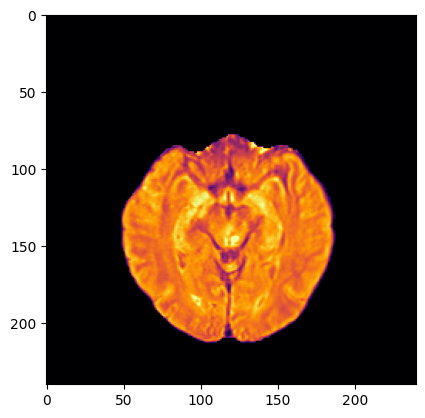

In [31]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensatz_RGB/regensburg_slices_tfrecords/all_pats_single_slice_gray/sub-02095303/sub-02095303_0.tfrecord"

num_images = 4

feature_description = {
    "image": tf.io.FixedLenFeature([240, 240, num_images], tf.float32),
    "sex": tf.io.FixedLenFeature([], tf.int64, default_value=[0]),
    "age": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "primary": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)
    # input = [example["image"], example["sex"], example["age"]]
    # label = example["primary"]
    image = example["image"]
    image = tf.reshape(image, [240, 240, num_images]) #[149, 185, 155, 4] = old size
    
    return image, example["sex"], example["age"], example["primary"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, sex, age, primary in test_image:
    print(sex.numpy())
    print(age.numpy())
    print(primary.numpy())
    numpy_image = image.numpy()
    plt.imshow(numpy_image[:,:,3], cmap = "inferno")

# sex
# m = 1, 0
# f = 0, 1

## Yale Dataset

In [3]:
path_to_yale_preprocessed_images = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_dataset_normalized")
path_to_met_slices = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/yale_metastases")
path_to_yale_excel = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/CIA metstobrain/Pretreat-MetsToBrain-Masks_clin_20240410.xlsx")

In [6]:
yale_training_patients = pd.read_excel(path_to_yale_excel, sheet_name="Data")

yale_patient_ids = yale_training_patients["BraTS_MET_ID"].tolist()
print(yale_patient_ids)
print(len(yale_training_patients))

# preprocessed_patients = [patient for patient in os.listdir(str(path_to_all_preprocessed_files)) if os.path.isdir(os.path.join(path_to_all_preprocessed_files / patient))]

# for patient in preprocessed_patients:
#     if patient not in patient_ids:
#         print(patient)

[86, 89, 90, 96, 97, 98, 100, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 258, 260, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310]
200


### Unify primary classes

count different primaries that exist within the Yale Dataset. As one can see, most primaries belong to lung cancer (86 + 17 = 103), after that Melanoma (41), then Breast Cancer (26), Renal cell carcinoma (16) and lastly Gastrointestinal cancers (16).

In [9]:
# primaries are written like this: 1, 2, 3, 4, 5
# explanation:
# 1 = Breast cancer; 2 = Gastrointestinal cancers;
# 3 = Small cell lung cancer; 4 = Melanoma;
# 5 = Non small cell lung cancer; 6 = Renal cell carcinoma; 7 = Other

# given a certain amount of classes, e.g. 3:
# create the following classes: lung, melanoma, other
yale_primaries_array = yale_training_patients["Primary"]
print(yale_primaries_array.value_counts())

Primary
5    86
4    41
1    26
3    17
6    16
2    14
Name: count, dtype: int64


Next we'll merge the two lung categories into one, meaning we combine category number 3 and category number 5 and turn it into a new category, 0.

In [14]:
# replace each 5 and 3 in the yale_primaries_array with a 0

yale_primaries_array = yale_primaries_array.replace(5, 0)
yale_primaries_array = yale_primaries_array.replace(3, 0)

print(yale_primaries_array.value_counts())

Primary
0    103
4     41
1     26
6     16
2     14
Name: count, dtype: int64


In [35]:
yale_class_primaries = return_specific_primaries(yale_primaries_array, specific_classes = [1], dataset="Yale")

print(yale_class_primaries.value_counts())

Primary
1    103
0     97
Name: count, dtype: int64
Primary
1    103
0     97
Name: count, dtype: int64


In [36]:
labels = yale_class_primaries.to_numpy()

classes = np.array([1, 0])

weights = class_weight.compute_class_weight(class_weight="balanced",
                                            classes=classes,
                                            y=labels)

print(weights)

[0.97087379 1.03092784]


### One hot encode sex
The sex in the yale dataset is encoded as such:\
0 = Male; 1 = Female\
Then it's time to adjust the dataset accordingly:

In [40]:
yale_sex_array = yale_training_patients["Sex"]

print(yale_sex_array.value_counts())

# str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
# str_lookup_layer.adapt(sex_array)
# sex_tensors = str_lookup_layer(sex_array)

# sex_test = sex_tensors[0].numpy()
# print(sex_test)

yale_sex_encoded = []
for sex in yale_sex_array:
    if sex == 0: # Male
        yale_sex_encoded.append([1, 0])
    elif sex == 1: # Femal
        yale_sex_encoded.append([0, 1])
    else:
        print(f"unknown sex: {sex}")
        yale_sex_encoded.append([0, 0])

print(yale_sex_encoded)

Sex
1    125
0     75
Name: count, dtype: int64
[[0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1],

### Prepare Images for training

#### 3D images

In [132]:
def load_yale_patient(patientID):
    images = []
    # get all four sequences

    if patientID < 100:
        patientID = "0" + str(patientID)

    patientID = str(patientID)

    patients = os.listdir(path_to_yale_preprocessed_images)
    patient_folder_name = [patient for patient in patients if patientID in patient][0]
    patient_path = Path(patient_folder_name)

    image_names = [file for file in os.listdir(path_to_yale_preprocessed_images / patient_path) if "normalized" in file]
    
    # load them
    for name in image_names:
        path_to_image = path_to_yale_preprocessed_images / patient_path / Path(name)
        image = nib.load(path_to_image)
        data = image.get_fdata()
        #tensor = tf.convert_to_tensor(data, dtype = float)
        images.append(data)
    
    if len(images) != 4:
        print(f"Warning: either too many or too few images for {patientID} (#{len(images)})")
    
    # return four images as array
    return images


def rotate_90_deg_yale(images):
    """rotates images by 90 degrees"""
    # rotate images
    rotated_images = []
    for image in images:
        rotated_image = ndimage.rotate(np.array(image), angle = 90)
        #rotated_images.append(tf.convert_to_tensor(rotated_image, dtype = float))
        rotated_images.append(rotated_image)
    
    # return back
    return rotated_images

def merge_and_transpose_images_yale(images):
    """merge images so that the fourth dimension used for the different sequences"""
    # merge image
    stacked = tf.stack(images, axis = -1)

    new_order = [2, 0, 1, 3]
    transposed = np.transpose(stacked, axes=new_order)

    # rearranges the sequence to order to the only correct one: T1, T1c, T2, FLAIR
    yale_sequence_order = [0, 2, 3, 1]
    new_sequence_images = transposed[..., yale_sequence_order]

    # transposed = tf.transpose(stacked, perm = new_order)
    return new_sequence_images

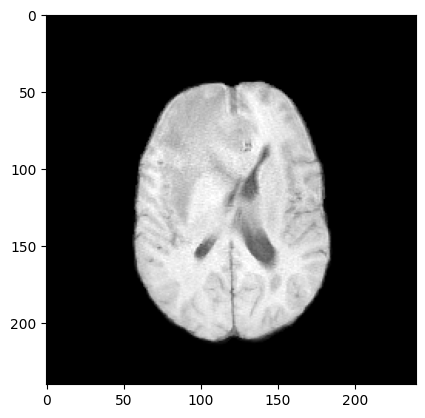

In [136]:
images = merge_and_transpose_images_yale(rotate_90_deg_yale(load_yale_patient(135)))
plt.imshow(images[80,:,:,0], cmap = "gray")

#### 2D images